# Key Project Strategy Simulator - ZTF Events

The essential procedure for this simulation follows that outlined in kp_simulator.ipynb and kp_simulator_gaia.ipynb, for Gaia events.  Here the simulator is updated with ZTF specific information, such as visibility data. 

In [43]:
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import healpy as hp
import random
import matplotlib.pyplot as plt
import csv
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels
from pyLIMA import microlmagnification
from pyLIMA import microlsimulator
from pyLIMA import microltoolbox
from pyLIMA import microloutputs
import jplhorizons_utils
import visibility_utils
import healpixel_functions
from scipy import interpolate, optimize
import h5py
from os import path
import copy

## ZTF Event Sky Locations

Rodriguez et al. 2022 2022ApJ...927..150R published a list of 60 microlensing events identified between 2018 and 2020 in the ZTF Data Release catalog.  

This list was input to the skymap_events code to convert this into an approximate map of event rate per year per HEALpixel (see code skymap_events.py).  

In [2]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
hp.nside2resol(NSIDE, arcmin = True)/60.0

0.9161297098179749

In [3]:
map_file_path = 'ztf/ztf_event_rate.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

coords = SkyCoord(data_table['RA'], data_table['Dec'], frame='icrs', unit=(u.hourangle, u.deg))

ztf_event_rate_table = Table([
                            Column(name="HP", data=data_table['hp_index'], dtype='int'),
                            Column(name="RA", data=data_table['RA'], dtype='str'),
                            Column(name="Dec", data=data_table['Dec'], dtype='str'),
                            Column(name="field_centre", data=coords),
                            Column(name="Gamma", data=data_table['gamma'], dtype='float'),
                            ])
ztf_event_rate_table

HP,RA,Dec,field_centre,Gamma
int64,str12,str12,object,float64
1,03:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (45., 89.26902778)>",0.0
2,09:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (135., 89.26902778)>",0.0
3,15:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (225., 89.26902778)>",0.0
4,21:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (315., 89.26902778)>",0.0
5,01:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (22.5, 88.53802778)>",0.0
6,04:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (67.5, 88.53802778)>",0.0
...,...,...,...,...
0,16:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (247.5, -88.53802778)>",0.0
0,19:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (292.5, -88.53802778)>",0.0


We need a smoother distribution function for events in RA, Dec.  We achieve this by downsampling the HEALpix map, then returning the map sampling to NSIDE=64. 

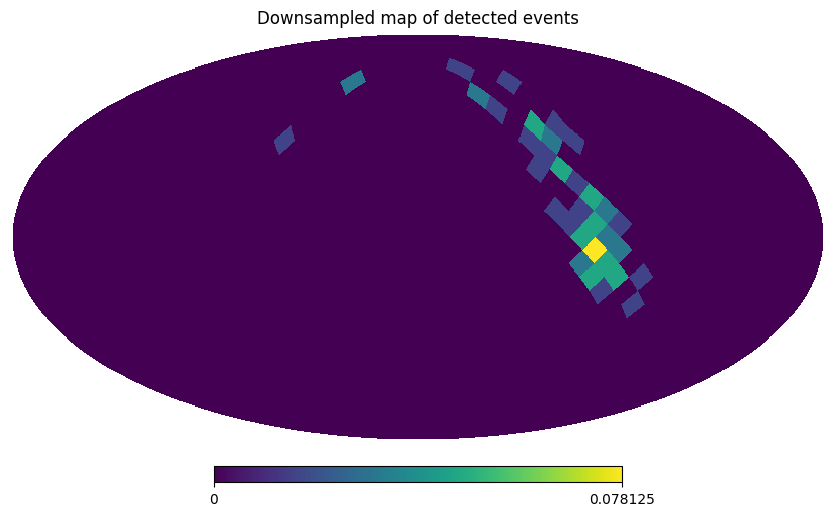

In [4]:
true_event_map = np.zeros(NPIX)
true_event_hp = np.where(ztf_event_rate_table['Gamma'] != 0.0)
true_event_map[true_event_hp] += 1.0

lores_true_event_map = hp.ud_grade(true_event_map, 8)
hp.mollview(lores_true_event_map, title='Downsampled map of detected events')
smooth_true_event_map = hp.ud_grade(lores_true_event_map, 64)

We want to draw a random sample of events, using this data to generate a realistic sample of where these targets will be located.  This should generate a list of HEALpixels where the simulated events are deemed to be located. 

In [5]:
n_samples = 1000
sim_event_hp = random.choices(np.arange(0,NPIX,1), weights=smooth_true_event_map, k=n_samples)

Now plot the original map of actual detected event positions and overplot the on-sky positions of the simulated event sample.

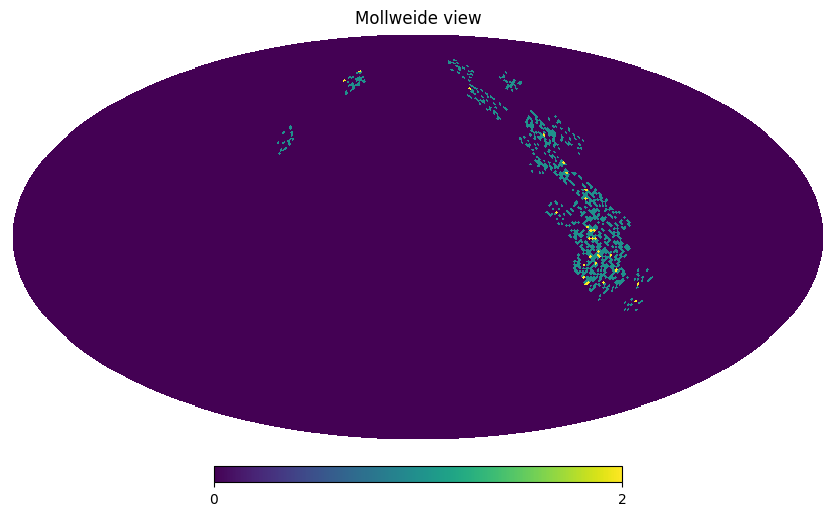

In [6]:
sim_event_map = np.zeros(NPIX)
sim_event_map[sim_event_hp] += 1.0

map_events = sim_event_map + true_event_map
hp.mollview(map_events)

Now convert the HEALpixel positions simulated for the sample of events to RA, Dec locations, assuming that the events are located at the HEALpixel centroids.  

In [7]:
sim_event_coords = ztf_event_rate_table['field_centre'][sim_event_hp]
sim_event_coords

"<SkyCoord (ICRS): (ra, dec) in deg\n (276.328125, 9.59406667)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (268.59375, 2.98550556)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (267.890625, -3.58331944)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (302.34375, 41.01449722)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (281.25, 18.83940278)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (269.296875, -4.78019167)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (270., -7.78271389)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (281.953125, 15.71385833)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (284.765625, -5.97915556)>"
...
"<SkyCoord (ICRS): (ra, dec) in deg\n (272.8125, -15.09478611)>"


## ZTF Event Baseline Magnitudes

Next we need to simulate the lightcurve data that ZTF would produce for these events.  

The first quantity we need is the baseline magnitude of the events.  Though the ZTF description paper does not seem to  offer a histogram of the number of stars per magnitude bin, it does state that the field of view is 47sq.deg, and the magnitude range in SDSS-r band is 8 - 21.0.  

Instead, we query the ZTF Data Release 15 archive (https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-dd) for a representative sample of detections, which we can download in ASCII format. 

In [8]:
def read_ztf_catalog(file_path):
    file_lines = open(file_path, 'r').readlines()
    data = []
    filterdata = []
    for line in file_lines[0:100]:
        if '/' not in line[0:1] and '|' not in line[0:1] and '\\' not in line[0:1]:
            entries = line.replace('\n','').split()
            row = []
            for x in entries:
                try:
                    row.append(float(x))
                except ValueError:
                    filterdata.append(x)
            data.append(row)
    data = np.array(data)
    
    columns = ['oid', 'ra', 'dec', 'field', 'ccdid', 'qid', 'ngoodobs', 'ngoodobsrel', 'nobs', 'nobsrel',
               'refmag', 'refmagerr', 'astrometricrms', 'chisq', 'magrms', 'maxmag', 'medianabsdev', 'medianmag', 
               'medmagerr', 'minmag', 'dist', 'angle']
    
    table_columns = []
    for i,col in enumerate(columns):
        table_columns.append(Column(name=col, data=data[:,i], dtype=float))
    table_columns.append(Column(name='filtercode', data=filterdata, dtype='str'))
    
    return Table(table_columns)

In [9]:
ztf_catalog_file = './ztf/ztf.ztf_objects_dr15_20188.tbl'
ztf_catalog = read_ztf_catalog(ztf_catalog_file)
ztf_catalog

oid,ra,dec,field,ccdid,qid,ngoodobs,ngoodobsrel,nobs,nobsrel,refmag,refmagerr,astrometricrms,chisq,magrms,maxmag,medianabsdev,medianmag,medmagerr,minmag,dist,angle,filtercode
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2
764204100004272.0,269.841766,45.354709,764.0,4.0,1.0,1143.0,1123.0,1209.0,1189.0,13.507,0.026,3.368616e-07,5.821794,0.05893348,13.69313,0.04128742,13.53447,0.01051441,13.36732,0.893531,148.223608,zr
764104100002941.0,269.8417783,45.3547074,764.0,4.0,1.0,1041.0,1029.0,1144.0,1132.0,14.336,0.01,2.903239e-07,6.287887,0.07182106,14.55145,0.05274963,14.34262,0.01243766,14.17182,0.915113,146.757169,zg
764304100005149.0,269.8417737,45.3547005,764.0,4.0,1.0,146.0,75.0,172.0,97.0,13.215,0.035,4.42677e-07,4.858943,0.06207819,13.34283,0.05088663,13.18402,0.01552694,13.05626,0.929804,148.196157,zi
1763209200008664.0,269.8417838,45.3547012,1763.0,9.0,2.0,56.0,56.0,58.0,58.0,13.554,0.024,3.892876e-07,7.810446,0.0593996,13.62613,0.05332756,13.52777,0.01012278,13.42431,0.941411,146.793604,zr
1763109200005299.0,269.8417887,45.3546935,1763.0,9.0,2.0,44.0,25.0,51.0,30.0,14.31,0.022,5.048048e-07,10.29805,0.06933714,14.4146,0.07483768,14.31047,0.0107743,14.21071,0.971404,147.077268,zg
1763209200047878.0,269.8399777,45.3568871,1763.0,9.0,2.0,0.0,0.0,0.0,0.0,22.026,0.213,0.0,nan,0.0,0.0,0.0,0.0,nan,0.0,8.159555,330.214417,zr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764204100037543.0,269.838482,45.3502772,764.0,4.0,1.0,18.0,18.0,18.0,18.0,22.417,0.322,5.396213e-06,1.839967,0.3860276,21.90929,0.2913923,21.50599,0.2347968,20.58989,18.460431,205.123847,zr
1763109200005325.0,269.8472827,45.3516467,1763.0,9.0,2.0,0.0,0.0,0.0,0.0,22.255,0.265,0.0,nan,0.0,0.0,0.0,0.0,nan,0.0,18.627824,129.239855,zg


Text(0, 0.5, 'Number of stars')

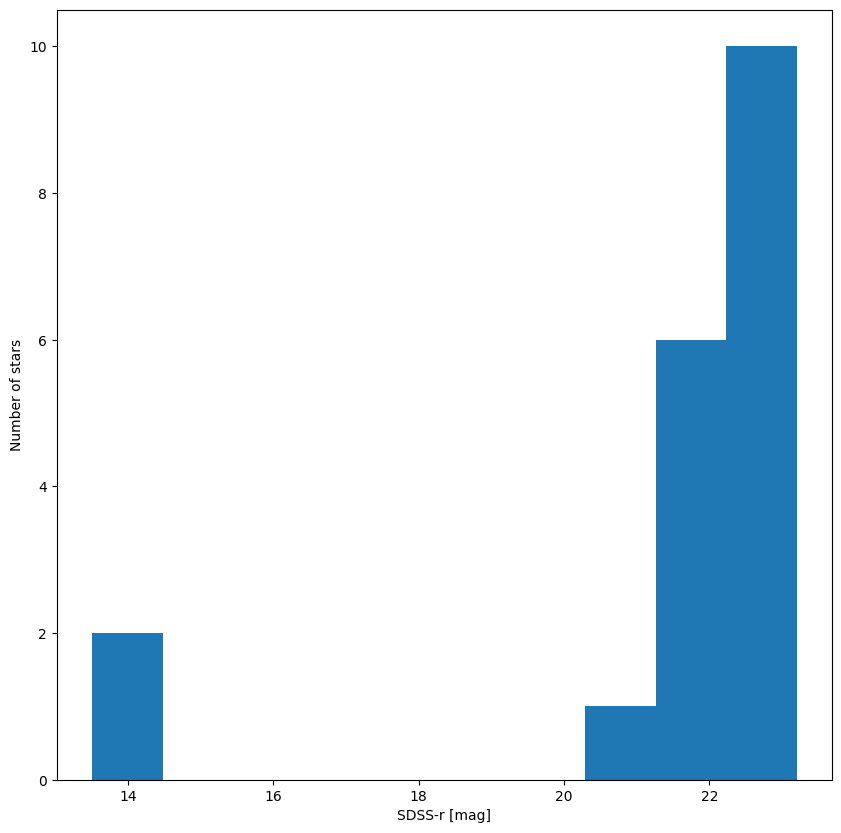

In [10]:
rdata = np.where(ztf_catalog['filtercode'] == 'zr')[0]
mags = ztf_catalog[rdata]['refmag']

fig = plt.figure(1,(10,10))
plt.hist(mags)
plt.xlabel('SDSS-r [mag]')
plt.ylabel('Number of stars')

Text(0.5, 1.0, 'Distribution of reference magnitudes of ZTF Detections')

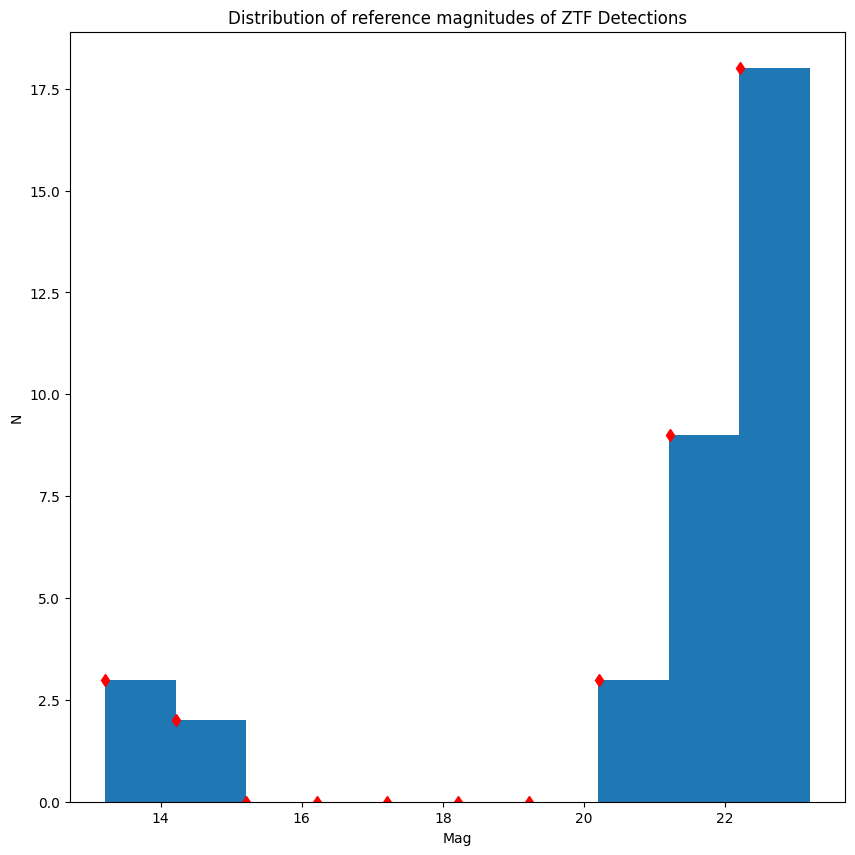

In [11]:
idx = np.where(ztf_catalog['refmag'] > 0.0)
mag_min = ztf_catalog['refmag'][idx].min()
mag_max = ztf_catalog['refmag'][idx].max() + 1.0
(mag_dist, mag_bins) = np.histogram(ztf_catalog['refmag'][idx], bins=np.arange(mag_min, mag_max, 1.0))


fig = plt.figure(1,(10,10))
plt.hist(ztf_catalog['refmag'][idx])
plt.plot(mag_bins[0:-1], mag_dist, 'rd')
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of reference magnitudes of ZTF Detections')

Now we can use this distribution to simulate a realistic range of baseline magnitudes for ZTF detections

Text(0.5, 1.0, 'Distribution of simulated ZTF detections')

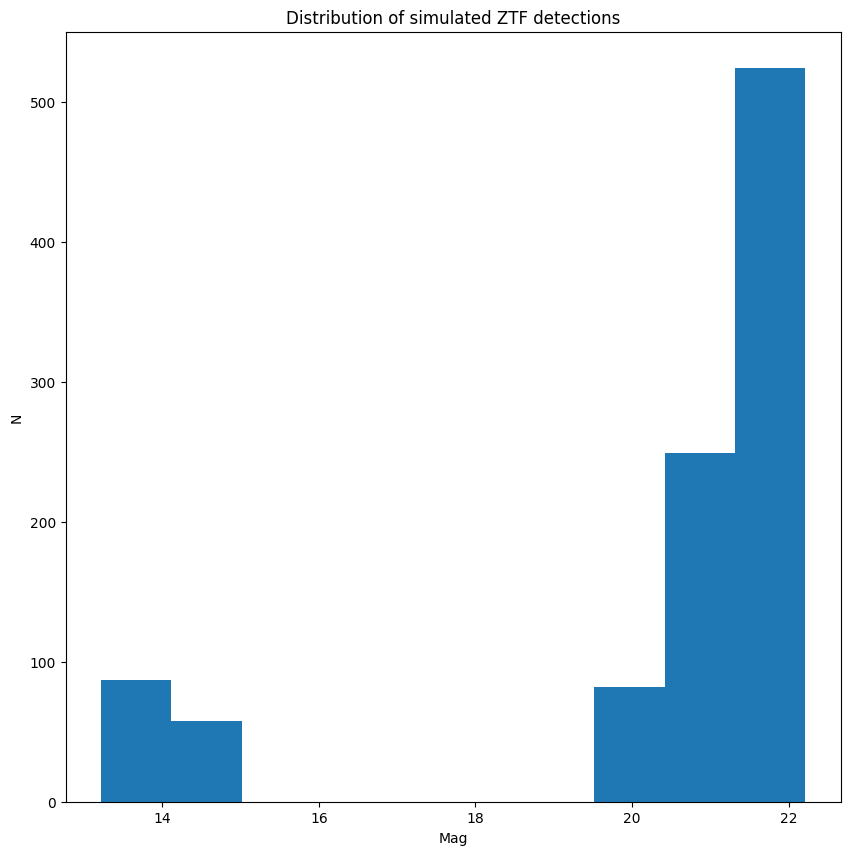

In [12]:
sim_event_mag = random.choices(mag_bins[0:-1], weights=mag_dist, k=n_samples)
fig = plt.figure(1,(10,10))
plt.hist(sim_event_mag)
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of simulated ZTF detections')

## ZTF Event Lensing Parameters

Next, we simulate a realistic range of microlensing event parameters.  We generate a timestamps array first, as the simulated events are constrained to have t0 within the range of the Key Project:

In [13]:
# Time stamps are in Julian Date
start_date = 2460157.50000
end_date = 2461252.50000

In [14]:
def simulate_event_parameters(start_date, end_date, n_sample):
    """Based on code by Markus Hundertmark, adapted to simulate stellar and stellar remnant PSPL events
    within ranges likely to be detected by Gaia
    """
    event_parameters = []
    for i in range(0,n_sample, 1):
        t0 = np.random.uniform(start_date, end_date)
        u0 = np.random.normal(0.141993,0.312678)
        if u0>1:
            u0 = 1
        if  u0<-1:
            u0 = -1
        te = 10.**np.random.normal(1.455351,0.379810)
        rho = abs(np.random.normal(0.008303,0.013883))
        piEN = np.random.normal(0.164267,0.749409)
        piEE = np.random.normal(0.044996,0.259390)
        event_parameters.append([t0,u0,te,rho,piEN,piEE])
    event_parameters = np.array(event_parameters)
    
    return event_parameters

In [15]:
event_parameters = simulate_event_parameters(start_date, end_date, n_samples)
params_list = ['t0','u0','te','rho','piEN','piEE']

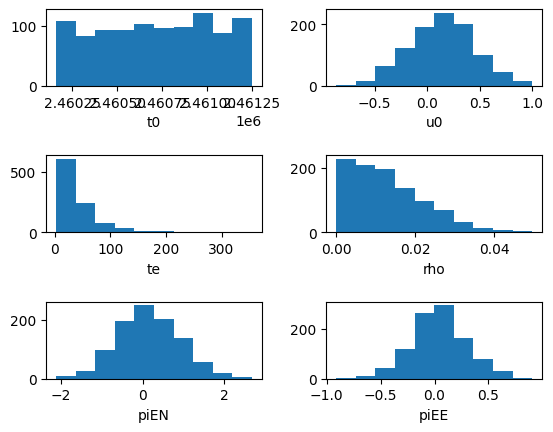

In [16]:
fig, axs = plt.subplots(3, 2)
plt.subplots_adjust(wspace=0.3,hspace=0.9)
idx = 0
for irow in range(0,3,1):
    for icol in range(0,2,1):
        axs[irow, icol].hist(event_parameters[:,idx])
        axs[irow, icol].set_xlabel(params_list[idx])
        idx += 1

Based on experience from previous year's of survey data, approximately 10% of events are binary lenses, which show anomalies, caustic crossings and other lightcurve features that need higher cadence observations in order to characterize them.  

To simulate this, and estimate the total amount of time this would require, ideally we would simulate a set of binary events but modeling 100 such events would be extremely time consuming.  Instead, we randomly nominate 10% of events in the table to be binaries, and use this flag to trigger more intensive observations over the event peak.  This effectively simulates the real-world observations that would be made of a subtle (planetary-style) anomaly. 

While binary stellar events often take longer (the gap between caustic entry and exit can be a few days), they do not need to be monitored as intensively the whole time.  Instead, intensive observations would be required over the caustic crossings, returning to moderate cadence in the gap.  The difference in the time requirements will be taken into account at a later stage.  

In [17]:
binaries = np.random.random_integers(0, n_samples-1, int(0.1*n_samples))
binary_index = np.zeros(n_samples, dtype=int)
binary_index[binaries] = 1

For ease of handling, let's combine these data into a single events table

In [18]:
def roundID(num):
    num = str(num)
    while (len(num) < 5):
        num = '0'+num
    return num

sim_event_names = []
for x in range(1,len(sim_event_hp)+1,1):
    sim_event_names.append('ZTFSim'+roundID(x))

In [19]:
events_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name="te", data=event_parameters[:,2], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        Column(name="binary_lens", data=binary_index, dtype='int'),
                        ])
events_table

EventID,HP,location,baseline_mag,t0,u0,te,rho,piEN,piEE,nvisits,binary_lens
str11,int64,object,str32,float64,float64,float64,float64,float64,float64,float64,int64
ZTFSim00001,20548,"<SkyCoord (ICRS): (ra, dec) in deg\n (276.328125, 9.59406667)>",20.215,2461023.733560292,0.08381129893023401,44.28527570813574,0.0038371487461939247,0.4844960714921078,-0.019202302641501946,0.0,0
ZTFSim00002,23359,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.59375, 2.98550556)>",22.215,2460417.0733396085,0.031126264428694483,63.99932982797067,0.02431204219684322,-0.5920850886987112,-0.31024048483479993,0.0,0
ZTFSim00003,26174,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.890625, -3.58331944)>",21.215,2460180.007580126,0.25599918796605037,147.9975295069092,0.024010464706062322,0.9258144359317724,-0.20861790017438223,0.0,0
ZTFSim00004,8535,"<SkyCoord (ICRS): (ra, dec) in deg\n (302.34375, 41.01449722)>",22.215,2460855.2639260585,-0.4023881713790807,60.37038745921802,0.007864142136612339,-0.261242908193355,0.07433734036204341,0.0,0
ZTFSim00005,16712,"<SkyCoord (ICRS): (ra, dec) in deg\n (281.25, 18.83940278)>",22.215,2460897.131356827,-0.008928037772003378,59.62217654180349,0.006026129254894834,1.7151165103529482,-0.15724729931902492,0.0,0
ZTFSim00006,26687,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.296875, -4.78019167)>",21.215,2460725.9532249663,0.2368600289628222,8.464742281807276,0.00037536139514484507,0.1300421634373687,0.4769270153230711,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
ZTFSim00994,23114,"<SkyCoord (ICRS): (ra, dec) in deg\n (284.765625, 3.58331944)>",21.215,2461148.416926002,0.2736056487571309,42.461950848063445,0.012084658576307918,1.0382159828202788,-0.4437160134651642,0.0,0
ZTFSim00995,22343,"<SkyCoord (ICRS): (ra, dec) in deg\n (279.84375, 5.37937778)>",22.215,2460198.233875863,-0.37588462797028455,9.440351443405572,0.002263339698874548,-0.33248931573717666,0.04379330549492315,0.0,0


### Blending

Note that we implicitly assume zero blending from background stars in the photometry for ZTF events.  Analysis offline has shown that this is a reasonable approximation for events outside the galactic centre, which are the majority of ZTF events. 


## ZTF Event Lightcurve sampling

In order to generate realistic ZTF lightcurves, we used the sampling of ZTF lightcurves from ZTF Data Release 14 to map the number of visits the survey made to each HEALpixel on the sky in the notebook ztf_survey_cadence.  This includes the total number of visits by ZTF between MJD=58194.0 to 59830.0, or 4.4 yrs.  Since this is a longer period than the Key Project, we scale the expected total numbers of visits per filter accordingly.  

In [20]:
ztf14_duration = 59830.0 - 58194.0
kp_duration = 365.24*3.0
scale_factor = kp_duration / ztf14_duration
scale_factor

0.6697555012224939

In [21]:
map_file_path = 'ztf/ztf_nvisits_healpix_table.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

ztf_nvisits = Table([
                        Column(name="HPid", data=data_table['HPid'], dtype='int'),
                        Column(name="Nvisits_all", data=data_table['Nvisits_all']*scale_factor, dtype='int'),
                        Column(name="Nvisits_g", data=data_table['Nvisits_g']*scale_factor, dtype='int'),
                        Column(name="Nvisits_r", data=data_table['Nvisits_r']*scale_factor, dtype='int'),
                        Column(name="Nvisits_i", data=data_table['Nvisits_i']*scale_factor, dtype='int'),
                        ])
ztf_nvisits

HPid,Nvisits_all,Nvisits_g,Nvisits_r,Nvisits_i
int64,int64,int64,int64,int64
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
5,71,32,39,0
6,0,0,0,0
...,...,...,...,...
49146,0,0,0,0
49147,0,0,0,0


Assign the numbers of visits to each simulated event, based on the HEALpixel where it was detected, and add this to the events_table.  

In [22]:
events_table['nvisits_g'] = ztf_nvisits['Nvisits_g'][events_table['HP']-1]  # Off-by-one to match Python's number-from-zero
events_table['nvisits_r'] = ztf_nvisits['Nvisits_r'][events_table['HP']-1]  # Off-by-one to match Python's number-from-zero
events_table['nvisits_i'] = ztf_nvisits['Nvisits_i'][events_table['HP']-1]  # Off-by-one to match Python's number-from-zero
events_table

EventID,HP,location,baseline_mag,t0,u0,te,rho,piEN,piEE,nvisits,binary_lens,nvisits_g,nvisits_r,nvisits_i
str11,int64,object,str32,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
ZTFSim00001,20548,"<SkyCoord (ICRS): (ra, dec) in deg\n (276.328125, 9.59406667)>",20.215,2461023.733560292,0.08381129893023401,44.28527570813574,0.0038371487461939247,0.4844960714921078,-0.019202302641501946,0.0,0,30,190,3
ZTFSim00002,23359,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.59375, 2.98550556)>",22.215,2460417.0733396085,0.031126264428694483,63.99932982797067,0.02431204219684322,-0.5920850886987112,-0.31024048483479993,0.0,0,186,462,1
ZTFSim00003,26174,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.890625, -3.58331944)>",21.215,2460180.007580126,0.25599918796605037,147.9975295069092,0.024010464706062322,0.9258144359317724,-0.20861790017438223,0.0,0,160,405,0
ZTFSim00004,8535,"<SkyCoord (ICRS): (ra, dec) in deg\n (302.34375, 41.01449722)>",22.215,2460855.2639260585,-0.4023881713790807,60.37038745921802,0.007864142136612339,-0.261242908193355,0.07433734036204341,0.0,0,840,1356,128
ZTFSim00005,16712,"<SkyCoord (ICRS): (ra, dec) in deg\n (281.25, 18.83940278)>",22.215,2460897.131356827,-0.008928037772003378,59.62217654180349,0.006026129254894834,1.7151165103529482,-0.15724729931902492,0.0,0,240,563,12
ZTFSim00006,26687,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.296875, -4.78019167)>",21.215,2460725.9532249663,0.2368600289628222,8.464742281807276,0.00037536139514484507,0.1300421634373687,0.4769270153230711,0.0,0,162,444,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFSim00994,23114,"<SkyCoord (ICRS): (ra, dec) in deg\n (284.765625, 3.58331944)>",21.215,2461148.416926002,0.2736056487571309,42.461950848063445,0.012084658576307918,1.0382159828202788,-0.4437160134651642,0.0,0,281,585,105
ZTFSim00995,22343,"<SkyCoord (ICRS): (ra, dec) in deg\n (279.84375, 5.37937778)>",22.215,2460198.233875863,-0.37588462797028455,9.440351443405572,0.002263339698874548,-0.33248931573717666,0.04379330549492315,0.0,0,463,1047,105


Store the table of simulated event parameters

In [24]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))
column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='nvisits_g', array=events_table['nvisits_g'], format='I5'))
column_list.append(fits.Column(name='nvisits_r', array=events_table['nvisits_r'], format='I5'))
column_list.append(fits.Column(name='nvisits_i', array=events_table['nvisits_i'], format='I5'))
column_list.append(fits.Column(name='binary_lens', array=events_table['binary_lens'], format='I1'))
hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_ztf_events_table.fits', overwrite=True)


## ZTF Event Lightcurves

Now we can simulate the lightcurves that ZTF would produce for these simulated events.  We assume that ZTF's survey strategy for the public Galactic Plane survey is roughly consistent with its previous strategy, and approximate the distribution of visits in the different filters as uniform.  

Firstly though, we need to establish a photometric noise function for the magnitude uncertainties in the lightcurve. This we can do using the photometry derived from the ZTF catalog above to derive noise model coefficients for the three bandpasses.  

In [25]:
gdata = np.where(ztf_catalog['filtercode']=='zg')[0]
rdata = np.where(ztf_catalog['filtercode']=='zr')[0]
idata = np.where(ztf_catalog['filtercode']=='zi')[0]

gmags = np.zeros((len(gdata),2))
rmags = np.zeros((len(rdata),2))
imags = np.zeros((len(idata),2))
gmags[:,0] = ztf_catalog[gdata]['refmag']
gmags[:,1] = np.log10(ztf_catalog[gdata]['refmagerr'])
rmags[:,0] = ztf_catalog[rdata]['refmag']
rmags[:,1] = np.log10(ztf_catalog[rdata]['refmagerr'])
imags[:,0] = ztf_catalog[idata]['refmag']
imags[:,1] = np.log10(ztf_catalog[idata]['refmagerr'])

In [26]:
def straight_line(x, a, b):
    return a + b*x

In [27]:
(gparam, gcov) = optimize.curve_fit(straight_line, gmags[:,0], gmags[:,1])
(rparam, rcov) = optimize.curve_fit(straight_line, rmags[:,0], rmags[:,1])
(iparam, icov) = optimize.curve_fit(straight_line, imags[:,0], imags[:,1])

Text(0, 0.5, 'Mag err')

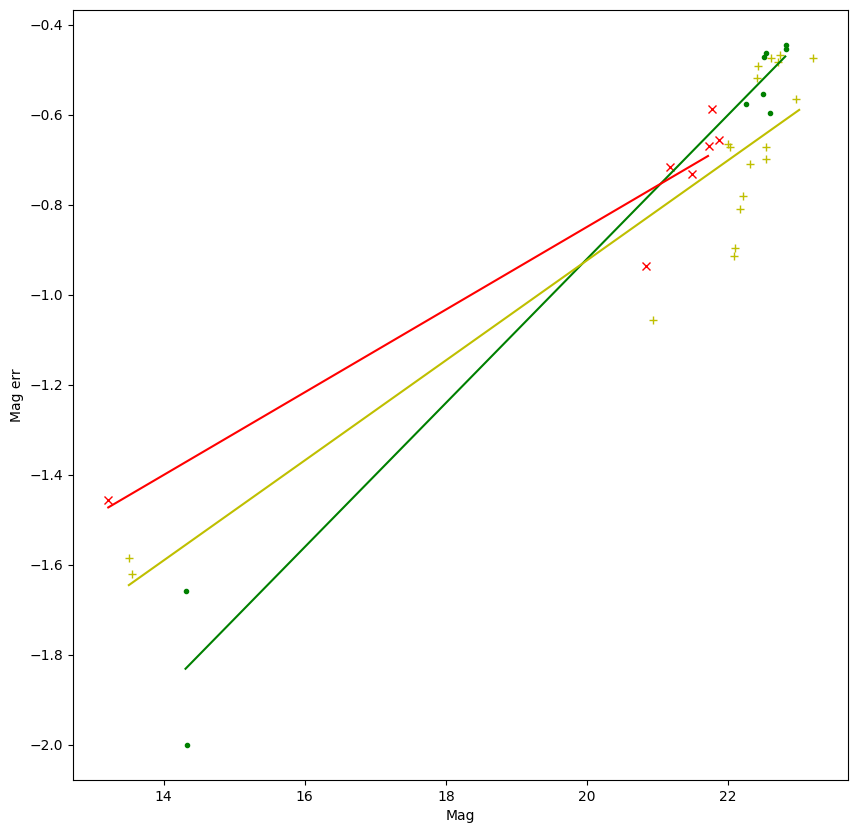

In [28]:
fig = plt.figure(2,(10,10))
plt.plot(gmags[:,0], gmags[:,1], 'g.', label='ZTF-g')
plt.plot(rmags[:,0], rmags[:,1], 'y+', label='ZTF-r')
plt.plot(imags[:,0], imags[:,1], 'rx', label='ZTF-i')

xdata = np.arange(gmags[:,0].min(), gmags[:,0].max(), 0.25)
ydata = straight_line(xdata, gparam[0], gparam[1])
plt.plot(xdata, ydata, 'g-')

xdata = np.arange(rmags[:,0].min(), rmags[:,0].max(), 0.25)
ydata = straight_line(xdata, rparam[0], rparam[1])
plt.plot(xdata, ydata, 'y-')

xdata = np.arange(imags[:,0].min(), imags[:,0].max(), 0.25)
ydata = straight_line(xdata, iparam[0], iparam[1])
plt.plot(xdata, ydata, 'r-')

plt.xlabel('Mag')
plt.ylabel('Mag err')

In [29]:
noise_model = {'g': gparam, 'r': rparam, 'i': iparam}

In [30]:
def simulate_event_ztf(event_params, noise_model, start_date, end_date, parallax=True):
    """Expects parameters from an entry in the events_table above.
    """
    
    # Loop over all three filters and simulate the event separately in the different passbands
    # to ensure the proper noise properties and sampling are handled correctly.  
    sim_events = {}
    for f in ['g', 'r', 'i']:
    
        # Simulate timestamps in this filter
        cadence = (end_date - start_date) / event_params['nvisits_'+f]
        timestamps = np.arange(start_date, end_date, cadence)
    
        # Create a PyLIMA event object
        sim_event = event.Event()
        sim_event.name = event_params['EventID']
        sim_event.ra = float(event_params['location'].ra.deg)
        sim_event.dec = float(event_params['location'].dec.deg)

        # Generate a constant lightcurve at the event's baseline magnitude (neglecting differences due to color), 
        # with fixed photometric uncertainties, since these will be replaced later
        lc = np.zeros((len(timestamps),3))
        lc[:,0] = timestamps
        lc[:,1] = [float(event_params['baseline_mag'])] * len(timestamps)
        lc[:,2] = [0.01] * len(timestamps)
        print(float(event_params['baseline_mag']), np.median(lc[:,1]))
    
        # Add a PyLIMA telescope object to the event with this lightcurve, and add it to the event
        tel = telescopes.Telescope(name='ZTF', camera_filter=f,
                                         light_curve_magnitude=lc,
                                         location='Earth',
                                         light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                         clean_the_lightcurve=False)

        sim_event.telescopes.append(tel)
        sim_event.find_survey('ZTF')
    
        # Add a PyLIMA model to the event, using the simulated parameters
        if parallax:
            sim_model = microlmodels.create_model('FSPL', sim_event,
                                              parallax=['Full',float(event_params['t0'])])
            lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                                  float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]

        else:
            sim_model = microlmodels.create_model('FSPL', sim_event)
            lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho'])]

        sim_model.define_model_parameters()
    
        if parallax:
            sim_model.event.compute_parallax_all_telescopes(sim_model.parallax_model)
        
        tel = sim_model.event.telescopes[0]
    
        pylima_parameters = sim_model.compute_pyLIMA_parameters(lensing_parameters)
        #print(event_params)
    
        # Use the PyLIMA model to add a lensing event into the lightcurve
        magnification = sim_model.model_magnification(tel, pylima_parameters)
        A = sim_model.model_magnification(tel,pylima_parameters)
        lightcurve = sim_event.telescopes[0].lightcurve_magnitude
        lightcurve[:,1] = lightcurve[:,1] + -2.5*np.log10(A)
        log_errors = straight_line(lightcurve[:,1], noise_model[f][0], noise_model[f][1])
        lightcurve[:,2] = 10**(log_errors)
        sim_event.telescopes[0].lightcurve_magnitude = lightcurve
        print(float(event_params['baseline_mag']), np.median(lightcurve[:,1]))
        
        sim_events[f] = sim_event
        
    # Microlensing lightcurves are independent of color to first order.  In the interests of re-using
    # code below, we combine the simulated lightcurve in different colors into a single array
    # for convenience
    
    ztf_event = event.Event()
    ztf_event.name = event_params['EventID']
    ztf_event.ra = float(event_params['location'].ra.deg)
    ztf_event.dec = float(event_params['location'].dec.deg)
    
    lightcurve = np.concatenate((sim_events['g'].telescopes[0].lightcurve_magnitude, 
                                 sim_events['r'].telescopes[0].lightcurve_magnitude))
    lightcurve = np.concatenate((lightcurve, 
                                 sim_events['i'].telescopes[0].lightcurve_magnitude))
    
    tel = telescopes.Telescope(name='ZTF', camera_filter=f,
                                     light_curve_magnitude=lightcurve,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    ztf_event.telescopes.append(tel)
    ztf_event.find_survey('ZTF')
    
    if parallax:
        ztf_model = microlmodels.create_model('FSPL', ztf_event,
                                          parallax=['Full',float(event_params['t0'])])
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]

    else:
        ztf_model = microlmodels.create_model('FSPL', ztf_event)
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                          float(event_params['rho'])]

    ztf_model.define_model_parameters()

    if parallax:
        ztf_model.event.compute_parallax_all_telescopes(ztf_model.parallax_model)

    pylima_parameters = ztf_model.compute_pyLIMA_parameters(lensing_parameters)

    return ztf_event, ztf_model, lensing_parameters

Parallax for ZTF events is predominately the annual parallax signature caused by the motion of the Earth during an event, which PyLIMA can calculate internally.  

In [31]:
# Pick a bright event as a test case:
event_number = 0
while (float(events_table[event_number]['baseline_mag']) > 18.0):
    event_number += 1
print('Picked bright event: ',event_number,' baseline_mag=',events_table[event_number]['baseline_mag'],'mag')

ztf_lens, ztf_lens_model, lens_model_pars = simulate_event_ztf(events_table[event_number], noise_model, start_date, end_date, parallax=True)



Picked bright event:  6  baseline_mag= 13.215 mag
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.21499995909157
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999960305729
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999643672789
Parallax(Full) estimated for the telescope ZTF: SUCCESS


  EventID     HP                            location                           baseline_mag         t0                 u0                 te                rho                  piEN                 piEE         nvisits binary_lens nvisits_g nvisits_r nvisits_i
----------- ----- ------------------------------------------------------------ ------------ ----------------- ------------------- ----------------- -------------------- ------------------- --------------------- ------- ----------- --------- --------- ---------
ZTFSim00007 27968 <SkyCoord (ICRS): (ra, dec) in deg\n    (270., -7.78271389)>       13.215 2460357.098182804 -0.7316413200771024 4.072765311574605 0.006547874004999087 -0.5551162584846547 -0.030386309421818365     0.0           0       137       399         0


Text(0.5, 1.0, 'Simulated event ZTFSim00007')

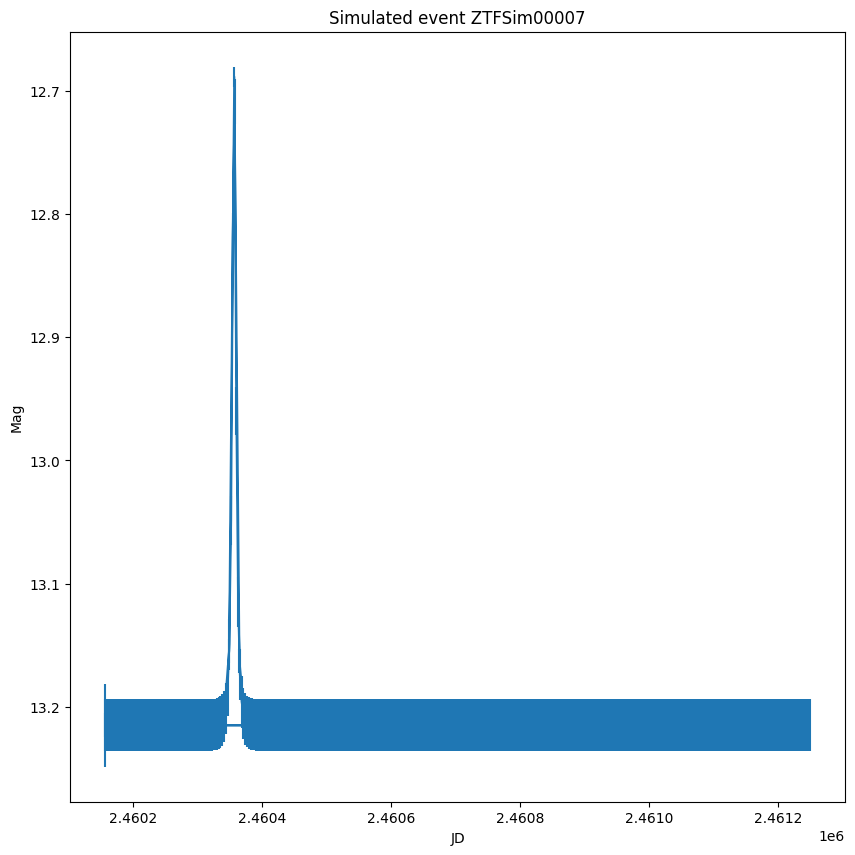

In [32]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc = ztf_lens.telescopes[0].lightcurve_magnitude
plt.errorbar(lc[:,0], lc[:,1], yerr=lc[:,2])
[xmin, xmax, ymin, ymax] = plt.axis()
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.title('Simulated event '+events_table[event_number]['EventID'])

Simulate all events

In [33]:
sim_ztf_lenses = []
sim_ztf_lens_models = []
sim_model_params = []

for ievent in range(0,len(events_table),1):
    (ztf_lens, ztf_lens_model, lens_model_pars) = simulate_event_ztf(events_table[ievent], noise_model, start_date, end_date, parallax=True)
    sim_ztf_lenses.append(ztf_lens)
    sim_ztf_lens_models.append(ztf_lens_model)
    sim_model_params.append(lens_model_pars)
    print(ievent, sim_model_params[-1])

20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214603689530996
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21454331846398
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214901037665147
Parallax(Full) estimated for the telescope ZTF: SUCCESS
0 [2461023.733560292, 0.08381129893023401, 44.28527570813574, 0.0038371487461939247, 0.4844960714921078, -0.019202302641501946]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213123621887352
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213155308908984
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.211843118052432
Parallax(Full) estimated for the telescope ZTF: SUCCESS
1 [2460417.0733396085, 0.031126264428694483, 63.99932982797067, 0.02431204219684322, -0.5920850886987112, -0.31024048483479993]
21.215 21.215
Parallax(Full) estimated for the telescope 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21497080608825
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21496273023238
Parallax(Full) estimated for the telescope ZTF: SUCCESS
18 [2460421.2853837903, 0.11717224488227955, 17.96188146635816, 0.014051360540127747, -0.24011742850615597, 0.11756722780628326]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499496533865
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499501995715
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499480610335
Parallax(Full) estimated for the telescope ZTF: SUCCESS
19 [2460275.979982884, 0.7427159679094749, 15.404986718220572, 0.015689027740718734, -1.1268024558708658, 0.17620821873652687]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.022751002437225
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.21

Parallax(Full) estimated for the telescope ZTF: SUCCESS
36 [2460568.54591188, -0.032491906801842135, 99.06580710485815, 0.024413228082830973, -0.7447112334580748, -0.07034594460626298]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214983144857795
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214983213830642
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214982502565253
Parallax(Full) estimated for the telescope ZTF: SUCCESS
37 [2460379.9572771178, -0.09488541078257681, 16.357442295338643, 0.030607973208666366, 0.3079631983663292, -0.03741676227356238]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.209821183884927
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.209805938465696
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.20988748265433
Parallax(Full) estimated for the telescope ZTF: SUCCES

Parallax(Full) estimated for the telescope ZTF: SUCCESS
54 [2460388.507243911, -0.30240785485971444, 3.7860093516435764, 0.0018261243904258706, 0.769251247743, -0.13065622835402343]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.103110110769407
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.102552352351804
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.10255235236917
Parallax(Full) estimated for the telescope ZTF: SUCCESS
55 [2460767.980824792, 0.17402580194134515, 123.21865816523879, 0.002170256760658981, 0.2598380657043842, 0.004895508106443951]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.2025563156149
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.202594981340496
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.201739193402826
Parallax(Full) estimated for the telescope ZTF: SUCCESS
56 [2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.207796899558538
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21445596963304
Parallax(Full) estimated for the telescope ZTF: SUCCESS
72 [2460734.506790566, -0.20503035928701943, 84.68809082409848, 0.015358292992322203, -0.1792099935737106, -0.13479952213976268]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999996520753
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999996536214
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999996429903
Parallax(Full) estimated for the telescope ZTF: SUCCESS
73 [2460175.085578977, 0.7539841221711545, 3.3449508162810435, 0.007674836495939453, 0.8810352478033112, -0.31602391788357276]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214998761824035
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21496916616192
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21496923930289
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214970165336887
Parallax(Full) estimated for the telescope ZTF: SUCCESS
91 [2460977.2057878184, 0.371676260278124, 23.07953633749068, 0.006107486606344352, 0.9869127204577195, 0.256651825597883]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214716000160983
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214716008175188
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214703623875618
Parallax(Full) estimated for the telescope ZTF: SUCCESS
92 [2460526.398510702, 0.46286603732262355, 30.10034428350537, 0.0009900936300544678, -0.03339240478151251, 0.01945446524059169]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215

Parallax(Full) estimated for the telescope ZTF: SUCCESS
108 [2460999.9155750126, 0.4142104354423386, 64.05520014881183, 0.018173350933905433, -0.6419020138239961, -0.117577397592112]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21487313723697
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21487499446578
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21486682856007
Parallax(Full) estimated for the telescope ZTF: SUCCESS
109 [2460393.201127443, 0.4674691837563232, 26.138375846348854, 0.02453096249458158, 0.025318953838952774, 0.3479181545269764]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214994405992247
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214994424734424
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214994426443536
Parallax(Full) estimated for the telescope ZTF: SUCCESS
110 [

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21497610095913
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499908398919
Parallax(Full) estimated for the telescope ZTF: SUCCESS
126 [2460780.620246558, -0.4737660299137597, 16.264328582224415, 0.009208396187006283, -0.21710961294248327, 0.02571147103687605]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.19233080825685
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.19226862829942
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.191356200927205
Parallax(Full) estimated for the telescope ZTF: SUCCESS
127 [2460442.6267322367, -0.10550432192696693, 56.38447956113295, 0.022683063254697593, 0.7794864493416305, 0.13363024114884187]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214481682648994
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21461387860313
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21446687962576
Parallax(Full) estimated for the telescope ZTF: SUCCESS
144 [2460414.188571043, 0.16220141978421515, 36.56658336939818, 0.002000075490993669, -0.267077399740212, -0.0857037647838802]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.191459686387667
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.191518602226015
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.191943288916885
Parallax(Full) estimated for the telescope ZTF: SUCCESS
145 [2460507.869988355, 0.9706358803823135, 190.27432988115942, 0.027924671225616073, 0.12784253816189586, 0.1668231566670767]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.212332432316302
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.2

22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214988114318547
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214988113470227
Parallax(Full) estimated for the telescope ZTF: SUCCESS
162 [2460879.0032730945, 0.3080952540745289, 13.03231000827327, 0.02186712052076338, -0.26135697487477727, -0.05594617365320224]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214913212714137
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214913208934906
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21435243447943
Parallax(Full) estimated for the telescope ZTF: SUCCESS
163 [2460555.2166135786, -0.015344972140311691, 22.324612981434502, 0.01980779713784204, 0.4822280184825584, -0.31538511293956567]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.211566700429884
22.215 22.215
Parallax(Full) estimated for the telesc

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21496506959003
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21496534832003
Parallax(Full) estimated for the telescope ZTF: SUCCESS
180 [2460235.6088111727, 0.09876660268437659, 29.867666525420354, 0.0007264438583899505, 0.03298474888842101, -0.04093218742915363]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214350557061657
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214350497876374
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214945083023903
Parallax(Full) estimated for the telescope ZTF: SUCCESS
181 [2460686.476558397, 0.5203625310900536, 40.75118423107393, 0.02591927315032312, -0.7126386626538206, 0.20714745822368166]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999902388023
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
198 [2460986.612873938, 0.2092804529444826, 19.626601163518654, 0.003653659521479547, 1.3003340107367463, 0.1971176279755809]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.207515288082305
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.207469636626794
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.20876782250546
Parallax(Full) estimated for the telescope ZTF: SUCCESS
199 [2461010.331911961, 0.46771961371508786, 126.0704937338748, 0.015094938001593648, 0.01980411559860973, -0.28771408566907697]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.186944133537654
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.18777424845841
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.13786810119952
Parallax(Full) estimated for the telescope ZTF: SUCCESS
200 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499894993079
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499895016013
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214998847309943
Parallax(Full) estimated for the telescope ZTF: SUCCESS
217 [2460557.840393049, 0.5250094723937292, 6.795609921083102, 0.001889251002249852, -0.6302053583819367, -0.04554303320586948]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214889985949387
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214890545847265
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21490569123496
Parallax(Full) estimated for the telescope ZTF: SUCCESS
218 [2460908.7157781236, 0.2489653349031064, 49.37475750321951, 0.020998728909859054, 1.4583922619259344, -0.49018686174544174]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.211525105558923
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21152934847858
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.211551777356668
Parallax(Full) estimated for the telescope ZTF: SUCCESS
235 [2460954.4617968076, -0.36356057944852016, 115.8791018068771, 0.017786521470760493, -1.1551385207523948, 0.020071806642095673]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.208912208957024
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.20890826633503
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.208922279762525
Parallax(Full) estimated for the telescope ZTF: SUCCESS
236 [2460779.679719375, 0.16444848410251917, 56.79190112030658, 0.001367484479794569, 0.6446607769485382, 0.2999201782311128]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214926389872577
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214925866334326
Parallax(Full) estimated for the telescope ZTF: SUCCESS
253 [2460978.666066948, 0.1374845610963536, 22.443124710937706, 0.01051191898963062, 0.2930475735404172, -0.11344923340513488]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21164293522307
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.211558498960017
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213166966305394
Parallax(Full) estimated for the telescope ZTF: SUCCESS
254 [2461111.875204561, 0.19014879643525412, 53.23494777175611, 0.006328906962415086, 0.8458285302734045, 0.39703797450250516]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21022937706706
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
270 [2461128.208056617, -0.14991898833998338, 6.257224744222421, 0.007058609121938485, -0.6978979109945356, 0.2570183912110607]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214658297542144
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214658506641697
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214654284106235
Parallax(Full) estimated for the telescope ZTF: SUCCESS
271 [2460773.9664911893, -0.1781552004852033, 36.32315972755206, 0.007356835776558419, -0.8337846922869556, -0.26519495406326876]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.2149974383157
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214997450738114
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214997364200663
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
288 [2460942.634734408, 0.4398113152754748, 52.0949782429715, 0.00881444046307441, 0.7932836764801499, 0.11469992420742647]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499988498924
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214999883955127
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214999883205042
Parallax(Full) estimated for the telescope ZTF: SUCCESS
289 [2461076.129926547, 0.45749069016517385, 5.490984410770317, 0.019177184781332384, 1.3298635038599789, 0.06601128974150035]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999859963285
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999857038546
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499986344172
Parallax(Full) estimated for the telescope ZTF: SUCCESS
290 [24

Parallax(Full) estimated for the telescope ZTF: SUCCESS
306 [2460325.06394155, -0.24333949058296137, 77.89133374490251, 0.010416560572918076, -0.19257895481807852, -0.16499559989469323]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21356331213105
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21356180725505
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.213552579322986
Parallax(Full) estimated for the telescope ZTF: SUCCESS
307 [2460570.1073852917, 0.1090881005741321, 42.348838123193396, 0.028831665183529857, -0.6522325493855048, 0.1117718784460347]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.19262591182333
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.19304851107659
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.192569017401752
Parallax(Full) estimated for the telescope ZTF: SUCCESS
30

Parallax(Full) estimated for the telescope ZTF: SUCCESS
326 [2460409.420659872, -0.22721549593475973, 39.474576548553884, 0.0068812772579914215, 1.1286921525216516, 0.4642358697089396]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214998959986463
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214998964937678
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499853291883
Parallax(Full) estimated for the telescope ZTF: SUCCESS
327 [2460203.011299098, 0.07819929801373204, 11.360915523800278, 0.02909652038141506, -1.2438718314429973, 0.07995760755753231]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213844248989055
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21384324612866
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213873584804666
Parallax(Full) estimated for the telescope ZTF: SUCCESS
3

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499987764266
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999877526825
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999876946873
Parallax(Full) estimated for the telescope ZTF: SUCCESS
344 [2461190.0907353195, 0.003474379500713748, 7.5424820307749485, 0.021297943591175053, -0.08753509473226406, 0.03956841652469177]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214986585340377
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21498657369595
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21498945283198
Parallax(Full) estimated for the telescope ZTF: SUCCESS
345 [2460944.397765098, -0.054496897617024365, 16.67821275422541, 0.01953931950271319, 0.7541163300519431, -0.17619287371827747]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCES

Parallax(Full) estimated for the telescope ZTF: SUCCESS
361 [2460175.442915988, -0.34926288048589915, 32.83815463084641, 0.01628300297791318, 0.9654184935055825, 0.45862340084298603]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214986490397354
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214986170749828
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21498611014852
Parallax(Full) estimated for the telescope ZTF: SUCCESS
362 [2460806.2116175843, 0.014105112474939674, 14.68238505503379, 0.0024358850789641647, -1.215660069613449, 0.053409299132890456]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21495595169462
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21495578588643
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214957441780268
Parallax(Full) estimated for the telescope ZTF: SUCCESS
3

Parallax(Full) estimated for the telescope ZTF: SUCCESS
379 [2460248.6948371376, -0.10976022510343761, 17.315004271880056, 0.02342822823291651, 0.48834993445974434, 0.17999990218954495]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21443438297725
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.2144425840655
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214191218664855
Parallax(Full) estimated for the telescope ZTF: SUCCESS
380 [2460252.32431597, 0.45985986136979584, 104.29244142713097, 0.0009133061080831353, 0.892277117521596, 0.0924725286034605]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214951997087121
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214952182934642
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214950702416006
Parallax(Full) estimated for the telescope ZTF: SUCCESS
381

Parallax(Full) estimated for the telescope ZTF: SUCCESS
397 [2460332.3818013165, 0.290236693495051, 61.62079513892554, 0.0017258238229001955, -0.8771700501610096, 0.14492260275031518]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21497725681643
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21497738128337
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 21.882061300316707
Parallax(Full) estimated for the telescope ZTF: SUCCESS
398 [2460177.1695881407, 0.17373249001450108, 35.08887616379395, 0.01654176391001983, 0.49101590446861765, 0.2176744575312632]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213355902189765
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21338633435197
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213440709933963
Parallax(Full) estimated for the telescope ZTF: SUCCESS
399 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
415 [2460919.712166157, -0.11774989489172347, 66.99348988471299, 0.016243992190532974, 0.6888731986358085, -0.2675257335811716]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214861891059705
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214863353215428
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214863339724246
Parallax(Full) estimated for the telescope ZTF: SUCCESS
416 [2460837.614426968, 0.5851469017000431, 28.61158103235492, 0.010928214041377554, -0.5316077424030061, 0.17713181419707402]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.1702061878028
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.170587562716825
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.133709056409835
Parallax(Full) estimated for the telescope ZTF: SUCCESS
417

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214889113591155
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214886933735343
Parallax(Full) estimated for the telescope ZTF: SUCCESS
434 [2460362.298550685, -0.4267547202559384, 27.52874366090482, 0.001688024421604403, 1.03501375736802, -0.04158889696834487]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214995842495448
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214995935749556
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.2149957374786
Parallax(Full) estimated for the telescope ZTF: SUCCESS
435 [2460404.662226424, -0.11895844367791489, 11.323270383267271, 0.017134720452746298, -0.2856424572929427, 0.06508186485415991]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214942473346245
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999427414376
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999447133874
Parallax(Full) estimated for the telescope ZTF: SUCCESS
452 [2461186.5997145115, -0.09098112857239582, 10.73343227519268, 0.011362897155203945, 0.17355117486412328, -0.10399333003610495]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21497417179631
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21497416400883
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214973829223258
Parallax(Full) estimated for the telescope ZTF: SUCCESS
453 [2460647.997096016, 0.2379822851361254, 20.7945313912002, 0.030536983147790873, 1.3551121264814339, 0.1397417768211994]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214490171447487
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214868970513894
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214906345827675
Parallax(Full) estimated for the telescope ZTF: SUCCESS
470 [2461170.0213782084, -0.01061725039373912, 29.458192354572407, 0.011366379197691354, 0.8116567613188241, -0.2064091971990951]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213059931749733
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213054707382057
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213099308026322
Parallax(Full) estimated for the telescope ZTF: SUCCESS
471 [2460848.278905536, -0.10893539439260039, 128.92825532821257, 0.0062395837149359385, 0.5664027404719024, 0.4801282598971487]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.211888504194924
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCE

Parallax(Full) estimated for the telescope ZTF: SUCCESS
488 [2460364.4851497468, 0.27912316430279627, 45.65564045060271, 0.016060025610645092, 0.5349566523437387, -0.2537616836057949]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214923176887442
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21492256458987
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214925032002657
Parallax(Full) estimated for the telescope ZTF: SUCCESS
489 [2461130.2978416625, 0.4320490298597236, 30.030001798516437, 0.0032856159628419854, 0.3739855591058361, -0.042803494725344886]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.20603729799769
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.20601082595909
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.204216838394593
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21495819650047
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21495408071075
Parallax(Full) estimated for the telescope ZTF: SUCCESS
507 [2460652.5586685105, 0.22331761548564735, 16.41538430606177, 0.012810378877357576, -0.012723425487759926, 0.3821162070482009]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214412739503032
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21441085921346
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214399141777186
Parallax(Full) estimated for the telescope ZTF: SUCCESS
508 [2460920.6672326103, 0.09396035458542487, 42.01701233339215, 0.007806656173213225, -0.5942561526574539, 0.3535343770742798]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214977675435456
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
524 [2460478.044465738, 0.19030558725799993, 21.423410524007263, 0.013834626442924606, 1.8503629434596451, 0.10107461022586325]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214939641559816
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214939723758327
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214997789127857
Parallax(Full) estimated for the telescope ZTF: SUCCESS
525 [2461106.233237562, -0.11577697228671105, 29.885663942614936, 0.008107273561547435, -0.6553045633478083, 0.02323180835089866]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214375343925653
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214379982705353
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214373809479852
Parallax(Full) estimated for the telescope ZTF: SUCCES

Parallax(Full) estimated for the telescope ZTF: SUCCESS
543 [2460955.2999730245, 0.3550159487596105, 39.74512787262575, 0.009529743654937153, 1.1144880572228077, -0.3990635189064232]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21427204111961
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214271016005725
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214557851243953
Parallax(Full) estimated for the telescope ZTF: SUCCESS
544 [2460960.283028143, -0.18681812668571204, 39.331500162046545, 0.01967326661727553, 0.12506957034248206, -0.1413564197817573]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214635338779242
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214634730773565
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214642988302955
Parallax(Full) estimated for the telescope ZTF: SUCCESS
5

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214832547109385
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 21.2115256009163
Parallax(Full) estimated for the telescope ZTF: SUCCESS
561 [2460186.746351708, -0.26593741298780693, 72.76286628047909, 0.031044378681438438, -0.480997267364298, 0.9070281744417604]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21379186433086
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213802604621353
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.207912289353757
Parallax(Full) estimated for the telescope ZTF: SUCCESS
562 [2460287.4189434326, -0.10180234661958834, 49.79112965067451, 0.0007160002597706213, -0.20349959773222875, 0.2789769137510518]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214993541690415
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21477819555556
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21478512233415
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214992066220514
Parallax(Full) estimated for the telescope ZTF: SUCCESS
579 [2460788.414677044, 0.05483029480303757, 27.50625429829157, 0.02388494160582153, 1.1458389880665552, 0.2986115303275575]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214853640178404
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214852793255844
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214860092329555
Parallax(Full) estimated for the telescope ZTF: SUCCESS
580 [2460978.9816664355, -0.1841519200318991, 19.949855842059574, 0.027112584349912247, -1.2612086123677066, 0.14598040471705154]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
597 [2460964.6240513325, 0.6654567574748689, 63.57682308294879, 0.008838372727546728, -0.5153708196264624, -0.07110488242705235]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.203053305368208
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.203271091580735
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.20306434946633
Parallax(Full) estimated for the telescope ZTF: SUCCESS
598 [2461060.3068691352, 0.25303924143542605, 53.074812687821726, 0.0050212253607356434, 0.3974653420555353, 0.5753224521809106]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.21489855785747
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214898598532715
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214834359311192
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
615 [2460860.9793324866, -0.10955929266321615, 60.07128010710465, 0.02276168633664638, -0.04720313638442686, -0.09353735230237709]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214468034570288
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21446624420129
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.213633489049464
Parallax(Full) estimated for the telescope ZTF: SUCCESS
616 [2460799.6223517223, -0.40866819389369846, 40.05825362889933, 0.013203945141122754, 1.5529873534541312, 0.005590981075989598]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999958256612
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999958574966
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999956307995
Parallax(Full) estimated for the telescope ZTF: SUCC

Parallax(Full) estimated for the telescope ZTF: SUCCESS
634 [2460555.372135537, 0.10095742980607275, 36.76626147299089, 0.01890387936966589, -0.3157659955156734, -0.0958339282607927]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214463989642482
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214463423555195
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214464574508494
Parallax(Full) estimated for the telescope ZTF: SUCCESS
635 [2460622.160592822, 0.3819986482228245, 34.51381135681195, 0.008267859402927917, 0.36121294110106505, 0.5223849778427846]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21484660054802
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214845301251124
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214848433176012
Parallax(Full) estimated for the telescope ZTF: SUCCESS
636 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214809819541983
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214810108793948
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214808052404912
Parallax(Full) estimated for the telescope ZTF: SUCCESS
652 [2460345.9437432033, 0.5910160653646109, 42.913183039352106, 0.0031860815630337987, 1.6621067024733593, -0.062447821149128495]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21485110141709
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21484680122548
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214994723711
Parallax(Full) estimated for the telescope ZTF: SUCCESS
653 [2460802.929513567, 0.0054627847896771276, 27.45932956991504, 0.011049655764373683, -0.2171570888425854, 0.12038993533782572]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
669 [2461108.2257901435, 0.27853521944823606, 39.02261392650135, 0.018077831216093958, -0.6195296862049537, -0.26523230076811843]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.211341476490844
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.211332615225928
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.211207475775808
Parallax(Full) estimated for the telescope ZTF: SUCCESS
670 [2460685.5342544476, -0.727722271440072, 195.36600917272648, 0.00710179050533328, 0.5049203057676181, -0.4522892947586567]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21475625298699
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214755503463053
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214760587897693
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.198960069754715
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.19896193291422
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.198764172974446
Parallax(Full) estimated for the telescope ZTF: SUCCESS
687 [2460876.9893594505, 0.1506615727352771, 46.681083774348146, 0.01565465986158337, 1.5393530343447877, 0.025354829199336796]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21260548132711
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21260057629471
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.212675192425145
Parallax(Full) estimated for the telescope ZTF: SUCCESS
688 [2461223.231335526, 0.9786265377235757, 83.96402684188031, 0.005174012407070271, 0.6075714087302426, -0.21334171914577352]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
704 [2461231.446800111, 0.1062245723069026, 4.786633448941961, 0.010075386356575062, 0.004238285841675293, 0.0800744240216745]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214999957928
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214999958068113
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21499995797634
Parallax(Full) estimated for the telescope ZTF: SUCCESS
705 [2460732.97621005, -0.13998116161344645, 3.1785062558955306, 0.005573563927137419, 0.6105987318454528, 0.13870905596602998]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.21499268840959
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214992648537315
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.21499365051962
Parallax(Full) estimated for the telescope ZTF: SUCCESS
706 [24

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214997979481808
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214998443741333
Parallax(Full) estimated for the telescope ZTF: SUCCESS
723 [2460960.578872688, 0.27702861058474276, 8.184128476062215, 0.01438570318120699, -0.4186014906599291, 0.04548680782591736]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214985655712592
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214985376592054
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214985841376098
Parallax(Full) estimated for the telescope ZTF: SUCCESS
724 [2460902.136753699, 0.6664110425231476, 13.369247663952551, 0.01854449155894606, -1.508450451493496, 0.10894009543370989]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21437864485832
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21494450688905
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214944475457557
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214945457448632
Parallax(Full) estimated for the telescope ZTF: SUCCESS
741 [2460756.882577167, 0.2929117538447573, 22.544539319696153, 0.021527648797294074, -0.5893590192107352, 0.26498003042435747]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213514619335776
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21351516403776
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213484766095632
Parallax(Full) estimated for the telescope ZTF: SUCCESS
742 [2460168.9619224826, 0.007707579021759586, 52.362741375798606, 0.005239847747954737, -0.13028876425795544, -0.4458905207295348]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCES

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214972579797287
Parallax(Full) estimated for the telescope ZTF: SUCCESS
758 [2460274.3807987142, 0.4065768173457246, 26.171749992082006, 0.038537504916066216, 0.42229288441774326, 0.5911702195519047]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214966822010336
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214967052409467
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214966430345502
Parallax(Full) estimated for the telescope ZTF: SUCCESS
759 [2460618.310607617, 0.03872315788101739, 15.566225516151324, 0.011521592273251382, -0.39409807797901936, 0.06553352613565555]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999069293988
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999068641422
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCES

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999880281194
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999850360023
Parallax(Full) estimated for the telescope ZTF: SUCCESS
777 [2460422.737675149, -0.5904520551310836, 4.180443021446255, 0.02012453707352459, 0.7307831054236011, -0.04838166368638613]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214825120011028
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21482477196553
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21481988300189
Parallax(Full) estimated for the telescope ZTF: SUCCESS
778 [2460804.209529692, -0.2954019713178855, 35.0367522192558, 0.005608897957389312, -0.8651642124221279, -0.03770584359663095]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214360402596434
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
795 [2460248.022510366, 0.26746069226305713, 18.017821644910338, 0.012838700917591353, 0.7605541231746684, -0.06439697694100746]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214971916733305
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21497224692687
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214978586562136
Parallax(Full) estimated for the telescope ZTF: SUCCESS
796 [2460448.819104458, 0.21272137839155936, 16.456483182986656, 0.021712056849644213, 0.24309397421016532, 0.09521091263069409]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214968408725454
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214968860862665
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214956236298704
Parallax(Full) estimated for the telescope ZTF: SUCCESS

Parallax(Full) estimated for the telescope ZTF: SUCCESS
813 [2461175.5429371605, 0.0004065758799434438, 15.238398838658311, 0.005719897742359651, 1.1076995715071705, 0.0665546979016245]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21497205305903
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21497185656171
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214971920981817
Parallax(Full) estimated for the telescope ZTF: SUCCESS
814 [2460840.844418736, 0.6205982550862555, 16.33948955623525, 0.014437443254399843, 0.7379513191808602, 0.3900783384975231]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214983636814974
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214983187602556
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214982540497346
Parallax(Full) estimated for the telescope ZTF: SUCCESS
815

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.183379437837406
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.18418209580328
Parallax(Full) estimated for the telescope ZTF: SUCCESS
831 [2460686.037756699, 0.5013400272343416, 97.09857379637542, 0.010144034745005857, -0.7719355845335985, 0.47931011686253716]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.191156891697553
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.190968483638002
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.19079016673947
Parallax(Full) estimated for the telescope ZTF: SUCCESS
832 [2460959.400824261, 0.5644467392602499, 102.456349026626, 0.000870568624689174, 0.031271406605415886, 0.1873975769834356]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.20583059535515
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215

Parallax(Full) estimated for the telescope ZTF: SUCCESS
848 [2460724.8198108072, -0.2762195589338762, 21.7333609900766, 0.031811547208292865, -1.2354829196506927, 0.029843116901771487]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214972561750052
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214972572116732
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21497239889065
Parallax(Full) estimated for the telescope ZTF: SUCCESS
849 [2460581.1060148953, 0.39206240580589813, 53.6442776632712, 0.03847589320947407, 2.371111317864599, -0.04332854666382085]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214994824312829
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.21499487059079
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214992717427824
Parallax(Full) estimated for the telescope ZTF: SUCCESS
850

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214987886931645
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214987697152853
Parallax(Full) estimated for the telescope ZTF: SUCCESS
867 [2460972.266789361, -0.06707830301764567, 13.172119822694729, 0.00616847560408567, -0.08614430899329562, -0.0447723384715138]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.212399124583339
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.212421267569798
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.212399124583136
Parallax(Full) estimated for the telescope ZTF: SUCCESS
868 [2460620.6322330465, 0.36566449100626, 63.66496624060417, 0.03590416434863173, 0.2846432245985126, 0.15220441491253608]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.2149994953494
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214992931052628
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214992954401072
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214964885874892
Parallax(Full) estimated for the telescope ZTF: SUCCESS
885 [2460323.8542343914, -0.02782094066725596, 18.119093750479003, 0.022472876786331406, 0.7038525581192516, 0.05190872450311574]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.196291634746856
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.196331094125537
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.196569919330177
Parallax(Full) estimated for the telescope ZTF: SUCCESS
886 [2460589.2029141583, 0.10746007185679986, 122.58873796016303, 0.005975917609459197, 0.2486979861254966, -0.08202481282535659]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCC

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499886831551
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214998648109294
Parallax(Full) estimated for the telescope ZTF: SUCCESS
903 [2460268.712946859, -0.331913435350236, 10.476988161976733, 0.032459002452144156, -0.7790051630434289, 0.43841650158255374]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214994031895255
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214994034773014
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214994035498187
Parallax(Full) estimated for the telescope ZTF: SUCCESS
904 [2460410.5693775527, 0.15669456921723962, 11.66996620150636, 0.008139381078585278, 0.24502640305999596, -0.2544453511866207]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999185227818
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21499824192722
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214998303892045
Parallax(Full) estimated for the telescope ZTF: SUCCESS
921 [2461073.8487096033, 0.1673168142524552, 12.41208526203911, 0.025332055777955158, -0.899787559603848, -0.24987293820589954]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.21488369913315
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214884949113559
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214878427983361
Parallax(Full) estimated for the telescope ZTF: SUCCESS
922 [2460951.3340125745, 0.04850921582377603, 23.97670957757357, 0.007178684540812167, -0.12785754491828577, -0.007292058493056974]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.211336731857731
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCES

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214949575255083
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21496389414233
Parallax(Full) estimated for the telescope ZTF: SUCCESS
939 [2461180.3239243706, -0.1933587167683493, 42.38882532483486, 0.011626313035259062, -0.2934007190516628, 0.5749447630993468]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999653863444
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999660819664
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499966083589
Parallax(Full) estimated for the telescope ZTF: SUCCESS
940 [2460218.5268839533, 0.6044693694676947, 9.951027864272726, 0.007423074970970066, 0.596720984026719, -0.1695486637819919]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.17894454311528
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.21

Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999435766687
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999460752704
Parallax(Full) estimated for the telescope ZTF: SUCCESS
958 [2460799.921469598, 0.15583534052317546, 6.50666313463192, 0.026125004713439183, -0.44041049364241197, 0.13653099889116596]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214193327443986
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21412930244683
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214345686616
Parallax(Full) estimated for the telescope ZTF: SUCCESS
959 [2461180.048418368, -0.33094587366444106, 96.61380232686335, 0.005807572045352552, -0.4707912815572422, 0.09731008276884084]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214672675490664
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
976 [2461114.457936301, -0.23884279749207651, 55.09381251831723, 0.018795338520451337, -0.42768151369024404, -0.12332563445635367]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214662685555197
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21465707434362
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214662995978742
Parallax(Full) estimated for the telescope ZTF: SUCCESS
977 [2460634.4970602957, 0.7056720674056411, 30.283690289623312, 0.004373939896905805, 0.37899296722664233, 0.1095234829200242]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.20904412216344
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.20909275410721
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.20915070587412
Parallax(Full) estimated for the telescope ZTF: SUCCESS
9

Parallax(Full) estimated for the telescope ZTF: SUCCESS
994 [2460198.233875863, -0.37588462797028455, 9.440351443405572, 0.002263339698874548, -0.33248931573717666, 0.04379330549492315]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214932721347722
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21493121332837
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21493228702254
Parallax(Full) estimated for the telescope ZTF: SUCCESS
995 [2460803.6122465613, 0.22428568072770577, 18.353877734184607, 0.012093346139574303, 0.024343536123573123, -0.4385208597621129]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21473490446335
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21485989623769
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21485989623769
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Store the simulated ZTF lightcurves

In [34]:
file_path = 'simulated_ztf_lightcurves.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(sim_ztf_lenses),1):
        lc = sim_ztf_lenses[ievent].telescopes[0].lightcurve_magnitude
        
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

## LCO Event Lightcurves

The next step is to simulate LCO observations for the same events, implementing the observing strategy, but also factoring in visibility of the targets from the LCO 1m network of telescopes, realistic weather loses, etc.  

The first step is to create a realistic model for the photometric uncertainties achievable from the 1m telescopes. 

In [35]:
def add_lco_noise(mag):
    
    # Configuration:
    gain = 1.0 # e- / ADU
    read_noise = 8.0 # e-
    ZP = 25.0
    tel_aperture = 1.0 # m
    phot_aperture_pixels = 10.0
    
    # Convert the lightcurve magnitudes to fluxes
    flux = ( 10**( (mag-ZP)/-2.5 ) ) * gain
    
    # Estimate photometric uncertainties:
    aperradius = phot_aperture_pixels/2.0
    npix_aper = np.pi*aperradius*aperradius
    read_noise = np.sqrt(read_noise*read_noise*npix_aper)
    possion_noise = np.sqrt(flux)
    sig_flux = np.sqrt(read_noise*read_noise + possion_noise*possion_noise )
    
    # Convert back to magnitudes:
    f = flux / gain
    idx = np.where(flux <= 0.0)
    flux[idx] = 0.0
    sig_flux[idx] = 0.0
    idx = np.where(flux > 0.0)
    mag_err = np.zeros(len(mag))
    
    mag_err[idx] = (2.5/np.log(10.0))*sig_flux[idx]/f[idx]

    return mag_err
    

Text(0, 0.5, 'log_10(Mag error)')

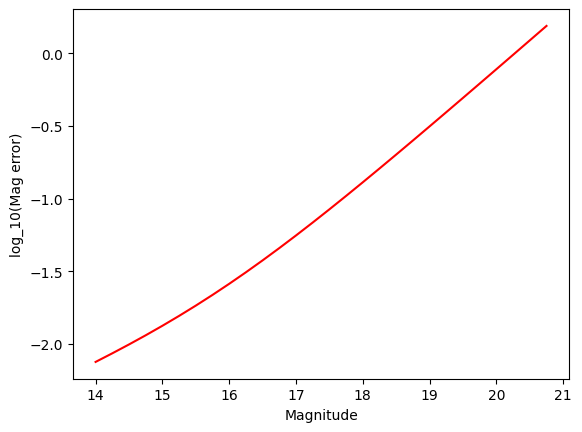

In [36]:
mag = np.arange(14.0, 21.0, 0.25)
mag_err = add_lco_noise(mag)

plt.plot(mag, np.log10(mag_err), 'r-')
plt.xlabel('Magnitude')
plt.ylabel('log_10(Mag error)')

The next step is to simulate what observations LCO could deliver for a given event.  
This naturally includes the visibility of that target from all network sites as a function of 
time, but this is computationally expensive, so we use a pre-calculated table.  This table is created from the notebook visibility_calculations.ipynb in this repository - see that notebook for full details. 

In [37]:
file_path = './lco_1m_network_visibility.hdf5'
visibility_data = visibility_utils.read_visibility_data(file_path)

The function below applies the pre-calculated visibility data to work out which simulated LCO datapoints would be viable observations and returns only those points. 

In [38]:
 def boundaries_check(times, interp_boundaries):
    idx = np.where(times < interp_boundaries[0])
    times[idx] = interp_boundaries[0]
    idx = np.where(times > interp_boundaries[1])
    times[idx] = interp_boundaries[1]
    return times

In [39]:
def observable_dates(input_ts, pixel_vis_func, interp_boundaries):
    """Function to determine whether or not a target is visible from the LCO 1m network 
    at the time stamps given, and return an array of timestamps with datapoints filtered 
    out if the target is not visible.  
    
    Note that this function is intended for multi-day arrays of timestamps, not intra-day.  
    
    While the input array of timestamps to interpolate for should be JD Time objects, 
    note that this is converted within the function into decimalyear, since this seasonal 
    visibility pattern can then be applied to any date.  
    """
        
    # Estimate the hours of visibility per timestamp.  
    ts = np.array([Time(t, format='jd') for t in input_ts])
    ts2 = np.array([(t.decimalyear-int(t.decimalyear)) for t in ts])
    ts2 = boundaries_check(ts2, interp_boundaries)
    hrs_visible = pixel_vis_func(ts2)
    
    # Filter out timestamps where the target isn't visible at all
    idx = np.where(hrs_visible > 0.0)
    
    return input_ts[idx]

The next function takes the simulated ZTF events, and generates a realistic set of LCO observations for that event, if it would be selected for observation using the Key Project strategy. 

In [46]:
def simulate_lco_observations(ztf_event, ztf_model, ztf_model_params, event_params, visibility_data, 
                              parallax=True):
    """Function to simulate LCO's observations of a given event.
    
    Observing strategy simulated:
    * Observe events only when brighter than 17.5mag
    * Cadence depends on event timescale:
    - tE <= 90d: cadence = once a day while  1.0tE <= |t-t0| <= 0.2tE, hourly 0.2tE <= |t-t0|
    - tE > 90d: cadence = once every two days
    * Declinations <= +10deg, simulate continuous cadence from 3 sites (24/7), modulo 10% random datapoints removed for weather
    * Declinations > +10deg, simulate continuous cadence from 1 site (8hrs out of 24), modulo weather
    """
    # Take a back-up copy of the original event object, since if no LCO observations are possible, 
    # this will be returned unchanged:
    original_event = copy.deepcopy(ztf_event)
    
    # First check whether the event ever gets bright enough for LCO 1-m observations. 
    # If observations are not viable, no additional lightcurve is added to the event
    ztf_lc = ztf_lens.telescopes[0].lightcurve_magnitude
    if len(ztf_lc) == 0:
        return original_event
    
    mag_threshold = 17.5
    bright_data = np.where(ztf_lc[:,1] <= mag_threshold)[0]
    if len(bright_data) == 0:
        print('Faint event, min '+str(ztf_lc[:,1].min())+' no LCO observations')
        return original_event
    
    # Unpack the lens model parameters:
    if parallax:
        [to, uo, te, rho, piEN, piEE] = ztf_model_params
        print('Event model parameters: ', to, uo, te, rho, piEN, piEE)
    else:
        [to, uo, te, rho] = ztf_model_params
    
    # Determine how many hours per day LCO can observe the target.  We use NSIDE=32 here, 
    # since this is the resolution of the pre-calculated visibility data, but note that 
    # the data is extracted using the Python array index ipix rather than the HP index.
    # This returns the HEALpixel's visibility as a function of date, which is used to create
    # an interpolation function.
    s = SkyCoord(ztf_event.ra, ztf_event.dec, frame='icrs', unit=(u.deg, u.deg))
    hpindex = healpixel_functions.skycoord_to_HPindex(s, 32, radius=2.0)
    ipix = hpindex[0]
    
    pixel_visibility = visibility_data['total_hrs_visible'][ipix,:]
    
    interp_boundaries = (visibility_data['decimalyear'].min(), visibility_data['decimalyear'].max())
    pixel_vis_func = interpolate.interp1d(visibility_data['decimalyear'], pixel_visibility)
    
    # Determine timestamps of LCO observations, with a cadence which depends on the event tE
    start_jd = ztf_lc[:,0].min()
    end_jd = ztf_lc[:,0].max()
    
    # Long timescale events
    if te > 90.0:
        cadence = 2.0
        ts = np.arange(start_jd, end_jd, cadence)
    
    # Short timescale events
    else:
        # Peak observations are defined as those between +/- 0.2tE of t0
        deltat = (ztf_lc[:,0] - to)/te
        
        # Pre-peak observations:
        # Figure out the timestamps when the event is in the pre-peak phase, taking LCO 
        # network visibility into account
        idx1 = np.where(deltat <= -0.2)[0]
        idx2 = np.where(deltat > -1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            pre_peak_start = ztf_lc[idx,0].min()
            pre_peak_end = ztf_lc[idx,0].max()
            cadence = 6.0/24.0 # days - 4x per day
            ts1 = np.arange(pre_peak_start, pre_peak_end, cadence)
            ts1 = observable_dates(ts1, pixel_vis_func, interp_boundaries)
        else:
            ts1 = np.array([])
            pre_peak_start = ztf_lc[:,0].min()
            pre_peak_end = ztf_lc[:,0].min()
            
        # Post-peak observations:
        idx1 = np.where(deltat >= 0.2)[0]
        idx2 = np.where(deltat < 1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            post_peak_start = ztf_lc[idx,0].min()
            post_peak_end = ztf_lc[idx,0].max()
            cadence = 6.0/24.0 # days - 4x per day
            ts3 = np.arange(post_peak_start, post_peak_end, cadence)
            ts3 = observable_dates(ts3, pixel_vis_func, interp_boundaries)
        else:
            ts3 = np.array([])
            post_peak_start = ztf_lc[:,0].max()
            post_peak_end = ztf_lc[:,0].max()
            
        # Peak observations
        cadence = 1.0/24.0
        ts2 = []
        day = pre_peak_end
        while (day < post_peak_start):
            # Estimate the number of hours that LCO can observe this target for
            t = Time(day, format='jd')
            t = t.decimalyear-int(t.decimalyear)
            t = boundaries_check(np.array([t]), interp_boundaries)[0]
            hours_per_night = pixel_vis_func(t)
            
            if hours_per_night > 0.0:
                # Simulate the timestamps of observations for one 24hr period, taking into account the numbers of 
                # hours that LCO can observe this target for:
                t = np.arange(day, day+(hours_per_night/24.0), cadence)
                ts2 += t.tolist()
                
            day += 1.0 # Increment the day number
        ts2 = np.array(ts2)
        
        # Binary lens events only
        # Make additional high cadence observations of two simulated caustic crossing events, 
        # each of which lasts 6hrs
        if event_params['binary_lens'] == 1:
            cadence = 15.0/(60.0*24.0) # Observe every 15mins
            caustic1 = np.arange(pre_peak_end, (pre_peak_end+(6.0/24.0)), cadence)
            caustic2 = np.arange(post_peak_start, (post_peak_start+(6.0/24.0)), cadence)
            ts4 = np.concatenate((caustic1, caustic2))
        else:
            ts4 = np.array([])
        
        ts = np.concatenate((ts1,ts2,ts3,ts4))
    
    # Randomly remove a certain fraction of points to simulate data losses due to weather:
    bad_weather_fraction = 0.1
    weathered_idx = np.random.randint(0, high=len(ts), size=int(len(ts)*bad_weather_fraction))
    ts = np.delete(ts, weathered_idx)
    
    # Its possible by now that we have no viable LCO observations.  If so, return the event without an 
    # LCO lightcurve attached
    if len(ts) == 0:
        print('No viable times for LCO observations')
        return original_event
    
    # Simulate the LCO photometry for these timestamps, assuming the same baseline magnitude as for ZTF
    lc = np.zeros((len(ts),3))
    lc[:,0] = ts
    lc[:,1] = [np.median(ztf_lc[:,1])] * len(ts)
    lc[:,2] = [0.01] * len(ts)
    tel = telescopes.Telescope(name='LCO', camera_filter='r',
                                     light_curve_magnitude=lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)
    ztf_event.telescopes.append(tel)
    
    if parallax:
        ztf_model.event.compute_parallax_all_telescopes(ztf_model.parallax_model)
        
    #tel = ztf_model.event.telescopes[-1]
    
    # Use the PyLIMA model to add a lensing event into the lightcurve
    pylima_parameters = ztf_model.compute_pyLIMA_parameters(ztf_model_params)
    magnification = ztf_model.model_magnification(tel, pylima_parameters)
    A = ztf_model.model_magnification(tel,pylima_parameters)
    lc[:,1] = lc[:,1] + -2.5*np.log10(A)
    
    # Remove any LCO observations for datapoints below the brightness threshold
    idx = np.where(lc[:,1] > mag_threshold)[0]
    lc = np.delete(lc, idx, axis=0)
    
    if len(lc) == 0:
        print('Event remains too faint for LCO observations even when magnified')
        return original_event
    
    # Predict the photometric scatter for each datapoint, based on its magnitude
    phot_scatter = add_lco_noise(lc[:,1])
    lc[:,1] += phot_scatter * np.random.randn(len(lc))
        
    # Calculate the photometric uncertainties
    lc[:,2] = add_lco_noise(lc[:,1])
    
    # Store the resulting lightcurve
    tel.lightcurve_magnitude = lc
    ztf_event.telescopes[1] = tel
    
    return ztf_event


As a test example, we apply the LCO data simulator to one of the simulated events.  This returns an updated version of the simulated event object, with the LCO lightcurve appended to the associated list of datasets. 

In [47]:
ztf_lens = sim_ztf_lenses[event_number]
ztf_lens_model = sim_ztf_lens_models[event_number]
lens_model_pars = sim_model_params[event_number]

updated_ztf_event = simulate_lco_observations(ztf_lens, ztf_lens_model, lens_model_pars, events_table[event_number], visibility_data)

Event model parameters:  2460357.098182804 -0.7316413200771024 4.072765311574605 0.006547874004999087 -0.5551162584846547 -0.030386309421818365
Parallax(Full) estimated for the telescope LCO: SUCCESS


  EventID     HP                            location                           baseline_mag         t0                 u0                 te                rho                  piEN                 piEE         nvisits binary_lens nvisits_g nvisits_r nvisits_i
----------- ----- ------------------------------------------------------------ ------------ ----------------- ------------------- ----------------- -------------------- ------------------- --------------------- ------- ----------- --------- --------- ---------
ZTFSim00007 27968 <SkyCoord (ICRS): (ra, dec) in deg\n    (270., -7.78271389)>       13.215 2460357.098182804 -0.7316413200771024 4.072765311574605 0.006547874004999087 -0.5551162584846547 -0.030386309421818365     0.0           0       137       399         0


Text(0.5, 1.0, 'Simulated event ZTFSim00007')

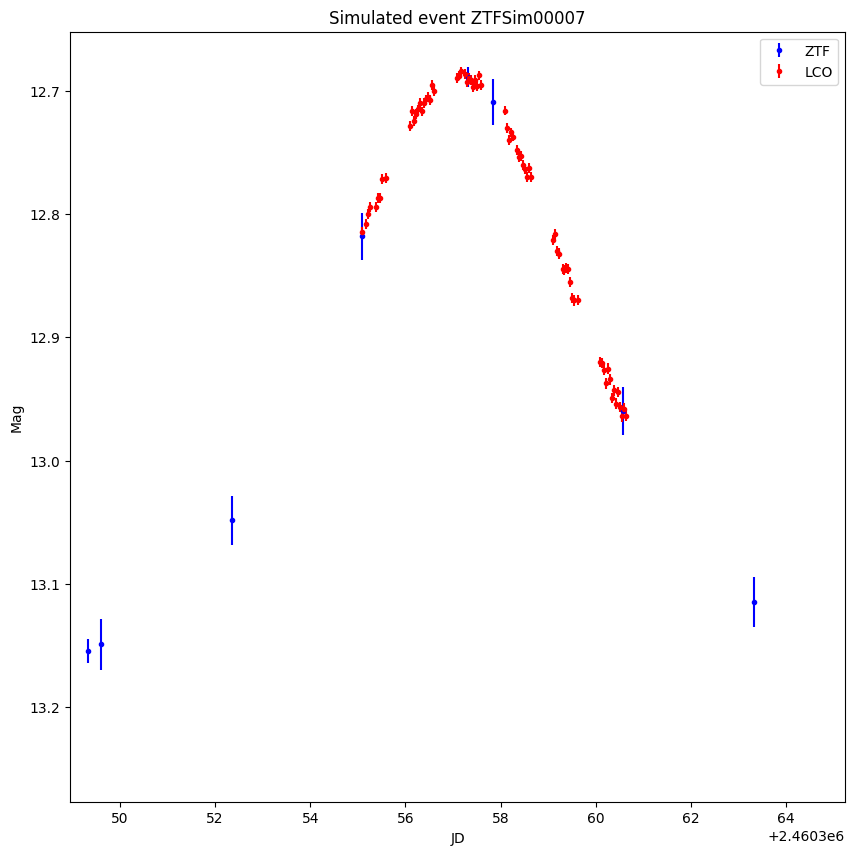

In [48]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc1 = updated_ztf_event.telescopes[0].lightcurve_magnitude
plt.errorbar(lc1[:,0], lc1[:,1], yerr=lc1[:,2], label='ZTF', fmt='b.')
lc2 = updated_ztf_event.telescopes[1].lightcurve_magnitude
plt.errorbar(lc2[:,0], lc2[:,1], yerr=lc2[:,2], label='LCO', fmt='r.')
[xmin, xmax, ymin, ymax] = plt.axis()
xmin = lens_model_pars[0] - 2.0*lens_model_pars[2]
xmax = lens_model_pars[0] + 2.0*lens_model_pars[2]
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.legend()
plt.title('Simulated event '+events_table[event_number]['EventID'])

We can now simulate LCO observations for the full set of simulated ZTF events

In [50]:
simulated_events_list = []

for ievent in range(0,len(events_table),1):
    updated_ztf_event = simulate_lco_observations(sim_ztf_lenses[ievent], 
                                                   sim_ztf_lens_models[ievent], 
                                                   sim_model_params[ievent], 
                                                   events_table[ievent],
                                                   visibility_data)
    simulated_events_list.append(updated_ztf_event)

Event model parameters:  2461023.733560292 0.08381129893023401 44.28527570813574 0.0038371487461939247 0.4844960714921078 -0.019202302641501946
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460417.0733396085 0.031126264428694483 63.99932982797067 0.02431204219684322 -0.5920850886987112 -0.31024048483479993
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460180.007580126 0.25599918796605037 147.9975295069092 0.024010464706062322 0.9258144359317724 -0.20861790017438223
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460855.2639260585 -0.4023881713790807 60.37038745921802 0.007864142136612339 -0.261242908193355 0.07433734036204341
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460897.131356827 -0.008928037772003378 59.62217654180349 0.006026129254894834 1.7151165103529482 -0.15724729931902492
Parallax(Full) estimated for the telescope LCO: SUCCESS
Even

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460265.8193162796 0.4103858777732502 33.76391689201591 0.015942402998894097 -1.255620379812052 0.2809439185369475
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460855.4528180817 0.2311996120670454 13.396608831000195 0.009683502098927354 0.09155927186171432 0.19053906979187438
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460733.7830475355 0.7099728094459449 17.742137428089766 0.008307106518107316 -0.10259011660673084 -0.22039851740828262
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461174.244794736 0.00379388277622153 25.055261717764516 0.004224658211057532 0.7555769214962302 -0.15588336623411952
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460325.738549016 -0.33631615110683544 34.86823923134443 0.019958893895008514 0.7326302674435976 0.2742750090062624
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460766.7064075987 -0.20235077052084385 43.43296777513428 0.025914389113723416 0.31589939116577465 -0.012952748650644531
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460264.6385075804 -0.37753250465225163 5.912369777690021 0.03684123858027163 -0.023630560405011103 -0.0010691363995014441
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460977.426775737 -0.08290297752122466 98.62988007689104 0.0003343936980041602 -0.2811756675849967 0.226999678079057
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460766.680695693 -0.2553911800680939 17.353603953933906 0.01847300078104695 -0.7101262851740955 -0.16330943195512082
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460977.2057878184 0.371676260278124 23.07953633749068 0.006107486606344352 0.9869127204577195 0.256651825597883
Par

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461052.5642444175 0.2855045611455638 10.479199185062749 0.027309494426674977 0.4825587464765916 0.34494281771583174
No viable times for LCO observations
Event model parameters:  2461187.729764047 0.0946907830741133 6.176847852689648 0.013652142696214611 0.898749230767657 0.0025648560853992336
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460344.481185255 -0.12006814798072066 25.465002935199983 0.024594641976167488 -0.8873999863870228 -0.1908602733444204
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460723.7223823653 0.06948802912794315 14.731053353173978 0.01689040688918799 -0.6007372043153956 -0.10003210207849958
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461108.8595197354 -0.038440606580341735 23.41311305525995 0.002046172411581875 -0.3269302807648586 -0.2681208086446335
Parallax(Full) estimate

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460216.0829885476 0.08635294144470432 4.136021038926139 0.025590939884732003 -0.3543922909271627 0.12233291303841931
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460310.8352898797 -0.005090758356368241 53.77620756669595 0.015482972992761013 0.17175352283292314 -0.020396848563335172
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461008.8723895876 0.3816251619989962 40.21360734432289 0.006063732009994285 0.24624499991627885 -0.15331062965043749
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460952.9663911643 0.562419452319546 145.626593318762 0.001589369065735681 0.3773708221201301 0.15051051472072519
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460235.6088111727 0.09876660268437659 29.867666525420354 0.0007264438583899505 0.03298474888842101 -0.04093218742915363
Pa

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460916.271905951 0.029305378383780695 64.1310258164735 0.014398354974155606 -0.022599960085877085 0.26718686083957804
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460525.85865183 0.1699263118753911 31.313335048589867 0.018770435255442336 -0.34086191299623997 -0.32254870403091024
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461023.583523195 0.2320494992983102 78.49977076982329 0.003701113972875156 0.2753420116487119 -0.37995554319214625
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460933.4349035043 -0.4111480629403802 23.37983877868055 0.00872360744715691 0.13958696936447731 -0.29712081785555156
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460961.156031686 -0.14252336322943113 31.095221297762457 0.01707157734103451 -0.04249499109116964 0.22623870540192262
Paral

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460579.2062902367 0.0971934411762597 29.572170819372218 0.009258708183028916 0.11068117464323189 -0.03643232948448372
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460634.184305266 -0.35527960897627475 18.44000565066786 0.040778272709807654 -0.8412032279332002 0.02152699971796198
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460290.394011042 -0.40367460822700085 16.86223908179208 0.017411239475009735 -0.19215819607129342 0.3212525942893986
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460266.031396965 0.35399432935395414 76.52639729045187 0.010605311344182914 1.6092105823173493 0.09284865503168863
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460233.6559505076 0.08905081717340158 13.697046025995464 0.02009323040446154 0.1972940322235367 0.24217923078379833
Paralla

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460320.6461922205 0.28818962629387096 180.34098544709607 0.004603633526522712 0.22572285084431548 -0.09313431690562457
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460251.6496418323 0.4195171556591958 57.910974568462635 0.013887551340739797 -0.45097074847129487 0.5533002285037261
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460347.262468592 0.11859698444438843 52.00750221168378 0.020835187977386822 -0.3974461699785194 0.08104899029400839
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460572.9875781774 0.5721354297735494 9.368621784990394 0.004874284319718013 -0.7514947481963854 0.43076886126155856
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460530.0620366978 0.2239588109638968 10.613504197399184 0.018458727505887153 -0.5435781146314669 0.24387787325162055
Paral

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460600.092341634 -0.3637264814783384 22.380669985676146 0.019634856760325795 -0.37145076825886164 0.3694080993234006
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461074.8809711146 -0.8645465570231383 18.071763266640765 0.01294593573862546 0.8320714740170485 -0.0473160826005409
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460568.2644117773 0.25323521925616077 12.90588032617445 0.004709654011091014 -0.16889565645257315 0.298348254316448
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460528.190896637 -0.05246603580635026 163.75110782736982 0.006864878019094388 -0.2756128705962594 0.019088754073215378
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460586.9795585684 0.1401727005221569 74.61301075807124 0.022143898312207304 -0.2766571699400618 0.05594796821306752
Parall

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460177.1695881407 0.17373249001450108 35.08887616379395 0.01654176391001983 0.49101590446861765 0.2176744575312632
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461054.1477327687 0.36212383571599416 56.74784637053765 0.010046465392605019 0.32599469121253455 0.10696331922807784
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460553.1032075677 -0.4813260794369739 82.49427900138977 0.01427548324035129 -0.2922611743847065 0.21407774576189464
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460290.5663501816 -0.11964387292442616 18.63220347996593 0.0016270342600317091 -0.44242508867948943 0.01749808404621958
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460463.5482171373 -0.27210640267519215 137.69801027037389 0.011727465218670083 -0.15813525998464523 -0.12134289973761428
P

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460431.679021463 0.841925167552744 14.28847777098126 0.004180421815809595 -1.3163128624647427 0.09125541137748971
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460798.481640238 0.13062507868202494 34.43732833199924 0.007639127034792109 1.0085684950483698 0.25038748846762127
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461237.210033311 -0.10488665755924717 50.457536607265816 0.00031415465137927916 0.6253134848344324 0.33955726104353884
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460677.877424847 -0.0007942940516185437 306.1569876186454 0.01782726218620731 -0.4209714512574742 -0.04156676150699757
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460393.228081933 0.0770219488864474 17.34806268189525 0.01845098510067767 -1.6145001207160656 0.3471218327817556
Parallax(F

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460481.549850666 0.2547369836893253 25.47058247005614 0.004072179216291345 0.5556686537842013 -0.26067141671781746
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460436.2949124365 0.6696343327783092 18.72734031249284 0.006309953204810911 0.13392322842542592 0.47382978231153133
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460364.4851497468 0.27912316430279627 45.65564045060271 0.016060025610645092 0.5349566523437387 -0.2537616836057949
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461130.2978416625 0.4320490298597236 30.030001798516437 0.0032856159628419854 0.3739855591058361 -0.042803494725344886
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460752.7738816747 0.19277224293983922 42.287172382915706 0.01761727931177855 1.4213649994262836 0.017323004919690754
Paralla

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460598.1304257424 0.07638867050751319 11.323773081132483 0.020816747928587856 1.0636006446378985 0.2802297987151249
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460234.563381106 0.3941709634540199 77.41503568676445 0.004648960800609678 1.1514266203843397 -0.1266043838417872
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461224.970281784 -0.18504133530800568 48.983310393566406 0.002490285648539802 -0.2811138924354356 -0.0023042540495339936
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460801.129050982 -0.07206284903927548 17.663006925052724 0.0020436613741492 0.7561750025720246 -0.2900382037678983
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460798.8142575156 0.41020089287160566 28.04651736701887 0.014149795928681682 0.47012535625730223 0.057179479683205775
Parall

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460535.573039546 0.6665553837216537 22.829496387166817 0.010662253818426401 0.3985555809151582 0.5378824341483174
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460467.305512006 0.23099806526758368 45.2612682894059 0.017142610716227413 2.2146278941184443 -0.000366585466460935
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461157.73351223 -0.47501933795319373 31.572130311972227 0.005445351818022796 -0.9949879963352968 -0.18128425824991823
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460332.9196769064 0.41556325077442136 48.65274575829587 0.01526151441893577 -0.8973734079590017 0.33187502813928565
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460594.129103793 0.33469191281298494 66.20194104160655 0.0029242526292229034 0.4411170171131 0.2224847527534059
Parallax(Full)

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460799.6223517223 -0.40866819389369846 40.05825362889933 0.013203945141122754 1.5529873534541312 0.005590981075989598
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460390.3611523863 0.5807965785680793 3.7575918155058385 0.0001253973556000973 -0.4804692441720018 0.1644801380292488
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461002.0361728533 0.19845656672471382 23.682765434976364 0.027001425556665196 -0.5000466083576658 0.46883618337255795
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460728.8751483215 0.04897194345480854 9.523051286053535 0.028663527310217048 -0.18119354561737644 -0.4616968141564359
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460501.2269484405 0.5038656106870387 85.5689923353182 0.009326086630563417 1.4268140575604462 0.34168777868106076
Paral

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461220.42908191 0.016581526793988055 46.0952260367323 0.014189768985452666 0.1524515976466446 0.04377682343189156
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460455.0054048873 0.5822016839345157 15.74846351638017 0.011019999918235783 -0.29112406165993365 0.12758810555487407
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460813.3639576975 0.1405358144284889 12.139474309564248 0.025518088267630787 -0.3719714800679252 -0.020442551528842022
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461003.1421783078 0.32178814558084434 3.6936853741154225 0.02061796248346775 1.4694612963267573 -0.16332546094697428
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460859.0017989874 0.7457043430252801 101.62376486747425 0.012323239892197437 -0.3798506398795813 0.2655448182345331
Paralla

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461099.419404327 0.8664875274305929 146.53318682989524 0.03203336586204883 -0.4288068556333768 0.5985943546023644
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460370.556350309 -0.08621417797403394 46.27031368542174 0.035024562555995516 -0.5106410463570832 -0.33081152161516336
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461021.1674248115 0.10774022803206158 31.71723124061357 0.0059654689487920985 -0.827379070228782 0.19707118827961267
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460934.8409023373 0.6836925336456869 22.46622093229368 0.008180759076149128 -0.5678583345688344 0.22718348949105194
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461100.5557117946 -0.0489559186956815 49.671946263111984 0.00678915253359245 0.036143807772784836 -0.06640048199493723
Parall

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460643.5376508706 0.1808437329633198 29.705887215565774 0.006085302916025623 -0.211552559077611 0.025909391897444796
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461224.9916834184 0.6725253843914756 38.70309718287826 0.004981447061664226 0.43206828329115227 -0.15195775587209326
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460652.7087903223 0.09548356159141339 20.849091797497266 0.009130933564501616 0.34021748616588726 -0.03926149751956221
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460693.4748009914 -0.18313543784968175 4.82142460086786 0.015744502180793974 -0.6840652750983884 0.13031541437851243
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460680.269788189 0.21203725956395286 49.63523247311821 0.008704482200982138 1.1060724209366022 0.05413641300126083
Paral

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460160.682838061 -0.15440432872747187 106.18219653948096 0.016137772482388353 -0.15490674766198348 -0.016306801404488383
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461049.969751246 0.09161150533647823 5.237633867279468 0.02539579616430957 -1.0290959614016792 -0.1323800058550233
No viable times for LCO observations
Event model parameters:  2460618.0652812053 0.31688734564984533 14.529764367840725 0.0044119135807095065 0.2713677294403484 0.1610710640096125
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460501.476594455 0.18257898326971755 63.06521639560241 0.02463938474427172 0.5548741318511508 0.2730731463511984
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460848.4565362986 -0.12154838902555318 16.107586714287308 0.026463094011060027 -0.3731524385884987 0.08169511288116296
Parallax(Full) estimated

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461227.336064045 0.42764550468905027 18.957985183499776 0.01615051526996468 -0.8653193804354564 -0.21629636559844292
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460369.559485439 -0.06156949826833505 132.04096098403838 0.007301487457802208 0.7224857748198026 0.0645009803661289
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461041.529541627 -0.2856306747784043 12.469803501474797 0.0027588582421544895 -0.1549007540635548 0.16059387914511453
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461161.960420956 0.03547398028992352 36.34405497683095 0.004720392384899151 -0.09340549325964359 -0.3382630650567588
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460506.925960611 0.5256548865635883 23.068690653424422 0.006658124047527126 -0.42019747389802703 -0.02080223505845282
Para

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461243.331988153 -0.5930501023920112 6.212809701276627 0.01307968317944263 1.3902172015769365 0.1620358089203832
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460595.6878817403 0.09130895121643381 16.519830325592725 0.020427886199108736 1.8056778305155405 -0.41869207738355313
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460323.8542343914 -0.02782094066725596 18.119093750479003 0.022472876786331406 0.7038525581192516 0.05190872450311574
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460589.2029141583 0.10746007185679986 122.58873796016303 0.005975917609459197 0.2486979861254966 -0.08202481282535659
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461207.634646852 0.046935462315844875 54.589816997103654 0.023928361182262735 -0.6457602954313271 -0.16201824298010997
Para

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460582.743899733 -0.11709432540132317 86.83945374431285 0.0042243742289517616 0.9004678750063235 -0.2803657601802653
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460649.9826874584 -0.2529513178592756 214.24645320137418 0.014355085316350227 -0.3877828947079152 0.19672134768105162
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461176.76540756 0.21132907246071797 6.246956154172089 0.011196532039729878 1.1311882625976037 0.06245421792341831
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461179.4627234177 0.08222155746031184 70.48676816840569 0.004797936672401906 -0.5926617193584871 0.13245103169676276
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460448.9295996614 0.4410320048570928 293.93530837106067 0.0151259637321427 0.3794444796038791 0.31716426943712495
Parallax(F

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460784.0076759737 0.17313955120045382 25.629964984438782 0.008105550123538328 1.0948046538837388 -0.2010618149343331
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460293.7117997087 -0.020916627900096102 12.926986561778495 0.021353310843062197 -0.30703855495374544 -0.28186209466732665
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460959.2717192094 -0.20088107472340902 48.29513596726424 0.01975481346477036 0.31134926507770744 -0.1911745209591534
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461119.119075654 0.14436536198088798 51.416957709657375 0.007544581513337988 0.13105642365848197 0.2591253544213641
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461114.457936301 -0.23884279749207651 55.09381251831723 0.018795338520451337 -0.42768151369024404 -0.12332563445635367

In [51]:
file_path = 'simulated_lco_lightcurves_ztf_events.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(simulated_events_list),1):
        if len(simulated_events_list[ievent].telescopes) == 2:
            lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        else:
            lc = np.array([])
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

## Evalulating how well we can characterize events

A key test of the observing strategy is how well we can constraint the event parameters as a result of the lightcurves produced.  

In order to evaluate this, we fit a microlensing model to the two lightcurves for each simulated event, as we would with real data, and then evaluate the fitted parameters of that model in comparison with the input simulated event parameters, as well as evaluating the uncertainties on the parameters key to measuring the mass of the events. 

In [52]:
class FitParams():
    """Object containing the fitted parameters and errors of a model fitted
    to a microlensing lightcurve"""
    
    def __init__(self):
        
        self.to = None
        self.toerr = None
        self.delta_to = None
        self.prop_delta_to = None
        self.to_within_range = None
        self.uo = None
        self.uoerr = None
        self.delta_uo = None
        self.prop_delta_uo = None
        self.uo_within_range = None
        self.tE= None
        self.tEerr = None
        self.delta_tE = None
        self.prop_delta_tE = None
        self.tE_within_range = None
        self.rho = None
        self.rhoerr = None
        self.piEN = None
        self.piENerr = None
        self.delta_piEN = None
        self.prop_delta_piEN = None
        self.piEN_within_range = None
        self.piEE= None
        self.piEEerr = None
        self.delta_piEE = None
        self.prop_delta_piEE = None
        self.piEE_within_range = None
        self.s = None
        self.serr = None
        self.q = None
        self.qerr = None
        self.logs = None
        self.logserr = None
        self.logq = None
        self.logqerr = None
        self.alpha = None
        self.alphaerr = None
        self.chichi = None
        self.bic = None
        self.nparam = 0
        self.type = None
        self.teerr_ok = None
        self.piEN_constrained = None
        self.piEE_constrained = None
    
    def extract_parameters_from_fit(self, fit, tel_list):
        fit_params = microloutputs.parameters_result(fit)
        fit_errors = microloutputs.fit_errors(fit)
    
        self.to = fit_params.to
        self.toerr = fit_errors.err_to
        self.tE = fit_params.tE
        self.tEerr = fit_errors.err_tE
        self.rho = fit_params.rho
        self.rhoerr = fit_errors.err_rho
        self.uo = fit_params.uo
        self.uoerr = fit_errors.err_uo
        self.piEN = fit_params.piEN
        self.piENerr = fit_errors.err_piEN
        self.piEE= fit_params.piEE
        self.piEEerr = fit_errors.err_piEE
        
        for tel in tel_list:
            fs = getattr(fit_params, 'fs_'+tel)
            fserr = getattr(fit_errors, 'err_fs_'+tel)
            setattr(self,'fs_'+tel, fs)
            setattr(self,'fs_'+tel+'_err', fserr)
            fb = getattr(fit_params, 'fb_'+tel)
            fberr = getattr(fit_errors, 'err_fb_'+tel)
            setattr(self,'fb_'+tel, fb)
            setattr(self,'fb_'+tel+'_err', fberr)
        
        self.chichi = fit_params.chichi

    def compare_parameters(self, event_params, params={'to':'t0','tE':'te','uo':'u0','piEN':'piEN','piEE':'piEE'}):
        
        result = ''
        
        for par_fit,par_expect in params.items():
            fitted_value = getattr(self,par_fit)
            fitted_error = getattr(self,par_fit+'err')
            fitted_range = [fitted_value - fitted_error, fitted_value + fitted_error]
            expected_value = event_params[par_expect]
            
            result += par_expect+': Fitted value='+str(fitted_value)+'+/-'+str(fitted_error)\
                    +' expected value='+str(expected_value)+'\n'
            
            delta = abs(expected_value - fitted_value)
            prop_delta = (delta/expected_value)*100.0
            if expected_value >= fitted_range[0] and expected_value <= fitted_range[1]:
                within_range = True
            else:
                within_range = False
        
            result += par_expect+': delta='+str(delta)\
                        +' prop_delta='+str(prop_delta)\
                        +'% within_range? '+repr(within_range)+'\n'
        
            setattr(self, 'delta_'+par_fit, delta)
            setattr(self, 'prop_delta_'+par_fit, prop_delta)
            setattr(self, par_fit+'_within_range', within_range)
            
        # Require that the tE be well constrained, meaning that the uncertainty is less than 25% of the value
        if (self.tEerr/event_params['te'])<0.25:
            teerr_ok = True
        else:
            teerr_ok = False
        result += 'tE constrained='+repr(teerr_ok)
        self.teerr_ok = teerr_ok
        
        # Require that the fitted uncertainties on the parallax parameters are smaller
        # than the measured values, i.e. are constrained
        piE_ok = []
        for par in ['piEE', 'piEN']:
            fitted_value = getattr(self,par)
            fitted_error = getattr(self,par+'err')
            
            if (np.abs(fitted_value) - 2.0*fitted_error > 0):
                piE_ok.append(True)
            else:
                piE_ok.append(False)
            result += ' '+par+' constrained='+repr(piE_ok[-1])
            
            setattr(self, par+'_constrained', piE_ok[-1])
            
        print(result)
        
    def summary(self, tel_list):
        
        line = 'tE = '+str(self.tE)+'+/-'+str(self.tEerr)+'\n'+\
                'to = '+str(self.to)+'+/-'+str(self.toerr)+'\n'+\
                'uo = '+str(self.uo)+'+/-'+str(self.uoerr)+'\n'+\
                'rho = '+str(self.rho)+'+/-'+str(self.rhoerr)+'\n'+\
                'piEN = '+str(self.piEN)+'+/-'+str(self.piENerr)+'\n'+\
                'piEE = '+str(self.piEE)+'+/-'+str(self.piEEerr)+'\n'
        
        for tel in tel_list:
            fs = getattr(self,'fs_'+tel)
            fserr = getattr(self,'fs_'+tel+'_err')
            fb = getattr(self,'fb_'+tel)
            fberr = getattr(self,'fb_'+tel+'_err')
            
            line += 'fs_'+tel+' = '+str(fs)+'+/-'+str(fserr)+'\n'
            line += 'fb_'+tel+' = '+str(fb)+'+/-'+str(fberr)+'\n'
        
        line += 'chi^2 = '+str(self.chichi)
        
        return line


In [53]:
def fit_event_model(event_params, model_type, ztf_lc, lco_lc):
    
    e = event.Event()
    e.name = event_params['EventID']
    e.ra = float(event_params['location'].ra.deg)
    e.dec = float(event_params['location'].dec.deg)

    # Add a PyLIMA telescope object to the event with the ZTF lightcurve
    tel1 = telescopes.Telescope(name='ZTF', camera_filter='r',
                                     light_curve_magnitude=ztf_lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    e.telescopes.append(tel1)
    
    
    # Add a PyLIMA telescope object to the event with the LCO lightcurve
    tel2 = telescopes.Telescope(name='LCO', camera_filter='r',
                                     light_curve_magnitude=lco_lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    e.telescopes.append(tel2)
    
    # Identify which dataset to use as the baseline:
    e.find_survey('ZTF')
    e.check_event()

    fit_method = 'LM'
    fit_method = 'DE'

    # Create a model object with parallax
    model = microlmodels.create_model(model_type, e, 
                                          parallax=['Full', event_params['t0']], 
                                          blend_flux_ratio=False)
    model.define_model_parameters()
    
    # Give the model initial guess values somewhere near their actual values so that the fit doesn't take all day
    lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]
        
    model.parameters_guess = lensing_parameters 
    for idx in range(6):    
        model.parameters_boundaries[idx]= [lensing_parameters[idx]-3e-4,
                                             lensing_parameters[idx]+3e-4]
    model.event.compute_parallax_all_telescopes(model.parallax_model)
    
    # Fit the model to the data:
    e.fit(model,fit_method)
    fit_flag = e.fits[-1].check_fit()
    print('Fit flag: '+repr(fit_flag))
    print('Telescopes: '+str(len(e.telescopes)))
    print('Fit results: '+repr(e.fits[-1].fit_results))
    
    # Compare the fitted model with the input event parameters
    tel_list = ['ZTF', 'LCO']
    fit = FitParams()
    fit.extract_parameters_from_fit(e.fits[-1], tel_list)
   
    fit.compare_parameters(event_params)
    
    return fit, e


Using our example simulated event, we fit an event model and demonstrate the comparision between the input and fitted parameters

In [54]:
ztf_lc = updated_ztf_event.telescopes[0].lightcurve_magnitude
lco_lc = updated_ztf_event.telescopes[1].lightcurve_magnitude
model_type = 'FSPL'

print(events_table[event_number])
(fit_params, e) = fit_event_model(events_table[event_number], model_type, ztf_lc, lco_lc)

  EventID     HP                            location                           baseline_mag         t0                 u0                 te                rho                  piEN                 piEE         nvisits binary_lens nvisits_g nvisits_r nvisits_i
----------- ----- ------------------------------------------------------------ ------------ ----------------- ------------------- ----------------- -------------------- ------------------- --------------------- ------- ----------- --------- --------- ---------
ZTFSim00007 27968 <SkyCoord (ICRS): (ra, dec) in deg\n    (270., -7.78271389)>       13.215 2460357.098182804 -0.7316413200771024 4.072765311574605 0.006547874004999087 -0.5551162584846547 -0.030386309421818365     0.0           0       137       399         0
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00007, with model FSPL

Now we can model all of the events in the simulation, storing the model fitted parameters and the comparison information

In [56]:
modeling_results = []
model_type = 'FSPL'

for ievent in range(0,len(events_table),1):
    print('\nModeling event '+str(ievent)+' number of lightcurves '+str(len(simulated_events_list[ievent].telescopes)))
    if len(simulated_events_list[ievent].telescopes) == 2:
        ztf_lc = simulated_events_list[ievent].telescopes[0].lightcurve_magnitude
        lco_lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude

        (fit_params, e) = fit_event_model(events_table[ievent], model_type, ztf_lc, lco_lc)
    else:
        fit_params = FitParams()
        print('No LCO lightcurve so not fitted')
        
    modeling_results.append(fit_params)
    


Modeling event 0 number of lightcurves 2
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00001, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 342.739
differential_evolution step 2: f(x)= 342.7
differential_evolution step 3: f(x)= 342.7
differential_evolution step 4: f(x)= 342.665
differential_evolution step 5: f(x)= 342.665
DE converge to objective function : f(x) =  342.49837106190364
DE converge to parameters : =  ['2461023.733860292' '0.08387957479077135' '44.28514118798521'
 '0.0037502533341854938' '0.4841960714921078' '-0.019502302641501948']
trust_region_reflective  : TRF fit SUCCESS
[2461023.7336860825, 0.08388345981980135, 44.28513489993849, 0.004026857371020487, 0.4841960715822784, -0.01950230254912429, 748.3918738797021, -0.2266404943222409, 472239

differential_evolution step 1: f(x)= 860.231
differential_evolution step 2: f(x)= 860.231
differential_evolution step 3: f(x)= 855.222
differential_evolution step 4: f(x)= 854.995
differential_evolution step 5: f(x)= 854.692
differential_evolution step 6: f(x)= 854.692
differential_evolution step 7: f(x)= 854.692
differential_evolution step 8: f(x)= 854.692
differential_evolution step 9: f(x)= 854.692
differential_evolution step 10: f(x)= 854.692
differential_evolution step 11: f(x)= 854.609
differential_evolution step 12: f(x)= 852.713
differential_evolution step 13: f(x)= 852.713
differential_evolution step 14: f(x)= 852.713
differential_evolution step 15: f(x)= 852.713
differential_evolution step 16: f(x)= 852.713
differential_evolution step 17: f(x)= 852.713
differential_evolution step 18: f(x)= 852.713
differential_evolution step 19: f(x)= 852.713
differential_evolution step 20: f(x)= 852.713
differential_evolution step 21: f(x)= 852.713
differential_evolution step 22: f(x)= 852.7

differential_evolution step 1: f(x)= 76.4349
DE converge to objective function : f(x) =  76.39587570593982
DE converge to parameters : =  ['2460288.5340926247' '-0.5814205253969695' '11.152655220817122'
 '0.03204490591425075' '0.5640412937259065' '0.05374808501170823']
trust_region_reflective  : TRF fit SUCCESS
[2460288.534092686, -0.5814205253969924, 11.152655220817133, 0.03204490591421898, 0.564041293725944, 0.053748085011670346, 118.502412327318, 0.07468143000081894, 474668.54564068856, -4232.449047036184, 76.39589292042551]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460288.534092686, -0.5814205253969924, 11.152655220817133, 0.03204490591421898, 0.564041293725944, 0.053748085011670346, 118.502412327318, 0.07468143000081894, 474668.54564068856, -4232.449047036184, 76.39589292042551]
t0: Fitted value=2460288.534092686+/-0.0054383865938791714 expected value=2460288.5343926246
t0: delta=0.00029993848875164986 prop_delta

differential_evolution step 1: f(x)= 687.114
differential_evolution step 2: f(x)= 687.114
differential_evolution step 3: f(x)= 687.114
differential_evolution step 4: f(x)= 687.114
differential_evolution step 5: f(x)= 687.114
DE converge to objective function : f(x) =  686.9856193190077
DE converge to parameters : =  ['2460570.8653139602' '0.13317578266020616' '49.022693123364625'
 '0.012858435649032027' '-0.3189774948778814' '-0.053935038873971955']
trust_region_reflective  : TRF fit SUCCESS
[2460570.8653119975, 0.13316253483522184, 49.02256705372362, 0.012273027445707213, -0.31897749487776483, -0.053935038873972364, 297.85540655418555, -0.003700873281922739, 472021.1124000067, 120.83330390588198, 686.9832668008859]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460570.8653119975, 0.13316253483522184, 49.02256705372362, 0.012273027445707213, -0.31897749487776483, -0.053935038873972364, 297.85540655418555, -0.00370087328192

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00017, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 439.606
DE converge to objective function : f(x) =  439.5312159872762
DE converge to parameters : =  ['2461207.987326962' '0.3731778114618313' '26.583789634818405'
 '0.007778526030668311' '0.22662403011044394' '0.13904756035792534']
trust_region_reflective  : TRF fit SUCCESS
[2461207.9873269643, 0.37317781146183127, 26.5837896348184, 0.007778526030668312, 0.2266240301104441, 0.1390475603579254, 188073.45872449497, -143.0524502454985, 472622.27473184344, -622.1194180991154, 439.53121624961534]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461207.9873269643, 0.37317781146183127, 26.5837896348184, 0.007778526030668312, 0.2266240301104441, 0.1390475603579254, 188073.45872449497, -143.0524502454985, 472622.27473184344

differential_evolution step 1: f(x)= 507.096
differential_evolution step 2: f(x)= 507.096
differential_evolution step 3: f(x)= 507.096
differential_evolution step 4: f(x)= 507.096
differential_evolution step 5: f(x)= 507.013
differential_evolution step 6: f(x)= 507.013
differential_evolution step 7: f(x)= 506.981
differential_evolution step 8: f(x)= 506.981
differential_evolution step 9: f(x)= 506.886
DE converge to objective function : f(x) =  506.7172359260444
DE converge to parameters : =  ['2460510.630846866' '0.5328549437219943' '206.5653994157068'
 '0.025400354218582964' '0.18306602030468078' '-0.3150726353987529']
trust_region_reflective  : TRF fit SUCCESS
[2460510.630972965, 0.5328549437219953, 206.56492016019297, 0.025857956167667367, 0.1830674483996695, -0.3150700816303555, 471660.03561413527, 401.8687992160388, 471969.72483328736, 48.990773812962495, 506.7139078625303]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results

differential_evolution step 1: f(x)= 193.754
DE converge to objective function : f(x) =  193.74036151317299
DE converge to parameters : =  ['2460816.599273473' '0.1940454713491827' '13.023049227053605'
 '0.02673051105883119' '0.9911969409898751' '-0.02728132955116265']
trust_region_reflective  : TRF fit SUCCESS
[2460816.59927578, 0.19403693897530955, 13.023049227049107, 0.026484459943164295, 0.9911969409898075, -0.027281329551207635, 118.55101307309886, 0.026003413658865056, 472058.46207019885, -91.1447912870398, 193.74030674416235]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460816.59927578, 0.19403693897530955, 13.023049227049107, 0.026484459943164295, 0.9911969409898075, -0.027281329551207635, 118.55101307309886, 0.026003413658865056, 472058.46207019885, -91.1447912870398, 193.74030674416235]
t0: Fitted value=2460816.59927578+/-0.0005981476738328754 expected value=2460816.5991737787
t0: delta=0.00010200124233961105 p

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00029, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 914.67
differential_evolution step 2: f(x)= 914.67
differential_evolution step 3: f(x)= 914.607
differential_evolution step 4: f(x)= 914.607
differential_evolution step 5: f(x)= 914.607
differential_evolution step 6: f(x)= 914.577
DE converge to objective function : f(x) =  914.5426793397858
DE converge to parameters : =  ['2460503.13038911' '0.19848241645957698' '65.39676376138956'
 '0.011498523895184303' '0.1645366252459333' '0.3574279580355249']
trust_region_reflective  : TRF fit SUCCESS
[2460503.1303890753, 0.19847706036245685, 65.39676376136221, 0.011123761557554056, 0.1645366252459223, 0.3574279580355269, 118.67242467859472, -0.0989099702415238, 472843.92149041296, -1263.0940973303793, 914.5425974173895]
differentia

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00033, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 504.436
DE converge to objective function : f(x) =  504.372110969798
DE converge to parameters : =  ['2460498.3221215387' '0.6983801502480329' '112.90477033005085'
 '0.012163084204132472' '-1.3209127867241002' '-0.11770867802662399']
trust_region_reflective  : TRF fit SUCCESS
[2460498.3221205566, 0.6983801502478153, 112.90477033001, 0.012163084204285272, -1.3209127867246258, -0.11770867802621515, 298.0171295042943, -0.1687701280030761, 472793.0675421727, -656.8191699690974, 504.3721231573742]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460498.3221205566, 0.6983801502478153, 112.90477033001, 0.012163084204285272, -1.3209127867246258, -0.11770867802621515, 2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00037, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 498.834
differential_evolution step 2: f(x)= 497.6
differential_evolution step 3: f(x)= 497.6
differential_evolution step 4: f(x)= 496.087
differential_evolution step 5: f(x)= 496.087
differential_evolution step 6: f(x)= 495.857
differential_evolution step 7: f(x)= 495.857
differential_evolution step 8: f(x)= 495.857
differential_evolution step 9: f(x)= 495.857
differential_evolution step 10: f(x)= 495.857
differential_evolution step 11: f(x)= 495.857
differential_evolution step 12: f(x)= 495.857
differential_evolution step 13: f(x)= 495.857
differential_evolution step 14: f(x)= 495.857
differential_evolution step 15: f(x)= 495.857
differential_evolution step 16: f(x)= 495.857
differential_evolution step 17: f(x)= 495.754

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00041, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 711.701
DE converge to objective function : f(x) =  711.678834681245
DE converge to parameters : =  ['2460583.6433319054' '0.7680337143129679' '52.09266782874759'
 '0.03812901598917748' '-0.2012459620052108' '-0.17727710457427792']
trust_region_reflective  : TRF fit SUCCESS
[2460583.6433321703, 0.768033714312971, 52.09266782874948, 0.038129015988766744, -0.2012459620052481, -0.1772771045743246, 118.51494003648236, 0.06294098218009309, 471560.42580406903, 638.5160687770242, 711.6788374625718]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460583.6433321703, 0.768033714312971, 52.09266782874948, 0.038129015988766744, -0.2012459620052481, -0.1772771045743246, 11

differential_evolution step 1: f(x)= 272.378
differential_evolution step 2: f(x)= 272.378
DE converge to objective function : f(x) =  272.3231123132888
DE converge to parameters : =  ['2460855.4525180818' '0.2308996120670454' '13.396908831000195'
 '0.009983502098927354' '0.09185927186171432' '0.19083906979187437']
trust_region_reflective  : TRF fit SUCCESS
[2460855.452527232, 0.23090109852629917, 13.396908513624757, 0.009983502018160617, 0.09184301199344647, 0.19083906976201936, 118.46740247145004, 0.110152324237974, 471033.10136677, 2130.257378074904, 272.3282564330243]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460855.452527232, 0.23090109852629917, 13.396908513624757, 0.009983502018160617, 0.09184301199344647, 0.19083906976201936, 118.46740247145004, 0.110152324237974, 471033.10136677, 2130.257378074904, 272.3282564330243]
t0: Fitted value=2460855.452527232+/-0.0007731602056946365 expected value=2460855.4528180817
t

differential_evolution step 1: f(x)= 227.159
DE converge to objective function : f(x) =  227.03425711326412
DE converge to parameters : =  ['2460325.738249016' '-0.3362113038634899' '34.868539231344435'
 '0.020117948855921042' '0.7329302674435976' '0.2745750090062624']
trust_region_reflective  : TRF fit SUCCESS
[2460325.7382490165, -0.336213335077256, 34.86853923134443, 0.020258892623604436, 0.7329302674435975, 0.27457500900626225, 297.76295358491444, 0.08855131039202654, 472112.90252304793, -599.1034901807519, 227.0340070023823]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460325.7382490165, -0.336213335077256, 34.86853923134443, 0.020258892623604436, 0.7329302674435975, 0.27457500900626225, 297.76295358491444, 0.08855131039202654, 472112.90252304793, -599.1034901807519, 227.0340070023823]
t0: Fitted value=2460325.7382490165+/-0.0050495654066121986 expected value=2460325.738549016
t0: delta=0.00029999949038028717 prop_d

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00052, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 444.962
DE converge to objective function : f(x) =  444.8800470678898
DE converge to parameters : =  ['2460374.723065074' '0.40917361328839846' '57.211682443794125'
 '0.001247966454992327' '-0.24940473901277685' '0.4061092996246492']
trust_region_reflective  : TRF fit SUCCESS
[2460374.722820443, 0.4091736132883418, 57.211682438163656, 0.001247966454992327, -0.2494047389171271, 0.40610929959731973, 298.0670225581167, -0.2186906733127074, 472844.89699473104, -1055.246223657616, 444.8807018465053]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460374.722820443, 0.4091736132883418, 57.211682438163656, 0.0012

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00056, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 465.438
differential_evolution step 2: f(x)= 465.438
DE converge to objective function : f(x) =  465.364964287646
DE converge to parameters : =  ['2460767.980524792' '0.1738967912181349' '123.21895816523879'
 '0.0024676017629506448' '0.26013806570438425' '0.005104680640995925']
trust_region_reflective  : TRF fit SUCCESS
[2460767.9805248776, 0.17389681302596272, 123.21895816523755, 0.0024702566866730215, 0.2601380657043735, 0.005104703501005008, 118.5191819527424, 0.057234875279313396, 471887.99587818305, 285.4441151656284, 465.36496663970246]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460767.9805248776, 0.17389681302596272, 123.21895816523755, 0.002470256

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00060, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 937.429
differential_evolution step 2: f(x)= 937.429
differential_evolution step 3: f(x)= 937.429
differential_evolution step 4: f(x)= 937.429
differential_evolution step 5: f(x)= 937.429
differential_evolution step 6: f(x)= 905.401
differential_evolution step 7: f(x)= 905.401
differential_evolution step 8: f(x)= 905.401
differential_evolution step 9: f(x)= 905.401
differential_evolution step 10: f(x)= 903.253
differential_evolution step 11: f(x)= 903.253
differential_evolution step 12: f(x)= 901.297
differential_evolution step 13: f(x)= 900.514
differential_evolution step 14: f(x)= 900.514
differential_evolution step 15: f(x)= 900.514
differential_evolution step 16: f(x)= 900.514
differential_evolution step 17: f(x)= 900

differential_evolution step 1: f(x)= 597.934
differential_evolution step 2: f(x)= 597.934
differential_evolution step 3: f(x)= 597.926
differential_evolution step 4: f(x)= 597.926
differential_evolution step 5: f(x)= 597.798
differential_evolution step 6: f(x)= 597.735
differential_evolution step 7: f(x)= 597.735
differential_evolution step 8: f(x)= 597.735
differential_evolution step 9: f(x)= 597.732
differential_evolution step 10: f(x)= 597.732
differential_evolution step 11: f(x)= 597.711
DE converge to objective function : f(x) =  597.6348894902105
DE converge to parameters : =  ['2460778.937333429' '0.10169087934676102' '62.13656861940543'
 '0.0008851222005138623' '-0.0653747316461897' '-0.20388082438447713']
trust_region_reflective  : TRF fit SUCCESS
[2460778.937575971, 0.10169013186953484, 62.13656862561885, 0.0008851222005138623, -0.06537473174609404, -0.20388207681090845, 118.56477758680315, 0.011604517787509448, 471930.97664514807, 136.72920969968106, 597.888405431916]
differ

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00067, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 512.852
differential_evolution step 2: f(x)= 512.852
differential_evolution step 3: f(x)= 511.476
differential_evolution step 4: f(x)= 511.476
differential_evolution step 5: f(x)= 511.441
differential_evolution step 6: f(x)= 511.441
differential_evolution step 7: f(x)= 511.441
differential_evolution step 8: f(x)= 511.441
differential_evolution step 9: f(x)= 511.441
differential_evolution step 10: f(x)= 511.441
differential_evolution step 11: f(x)= 511.176
differential_evolution step 12: f(x)= 511.176
differential_evolution step 13: f(x)= 511.176
differential_evolution step 14: f(x)= 511.176
differential_evolution step 15: f(x)= 511.176
differential_evolution step 16: f(x)= 511.176
DE converge to objective function : f(x) 

differential_evolution step 13: f(x)= 410.977
differential_evolution step 14: f(x)= 410.977
DE converge to objective function : f(x) =  410.93615192213355
DE converge to parameters : =  ['2460965.2300137333' '0.03821332763576979' '29.25334616756719'
 '0.009019784645152204' '-0.8034638916356212' '0.1815444791367244']
trust_region_reflective  : TRF fit SUCCESS
[2460965.23001587, 0.038242543760507376, 29.253498338766907, 0.009494001240029441, -0.8034638916356408, 0.18154447913672292, 297.88502006828605, -0.034058983706385576, 472213.346897596, -368.18210880163093, 410.9144397926875]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460965.23001587, 0.038242543760507376, 29.253498338766907, 0.009494001240029441, -0.8034638916356408, 0.18154447913672292, 297.88502006828605, -0.034058983706385576, 472213.346897596, -368.18210880163093, 410.9144397926875]
t0: Fitted value=2460965.23001587+/-0.0001508412150226612 expected value=24609

differential_evolution step 1: f(x)= 66.885
DE converge to objective function : f(x) =  66.88504016705532
DE converge to parameters : =  ['2460175.0858428366' '0.7538803122732595' '3.3447665946863054'
 '0.007628174766636375' '0.8809140457067315' '-0.31630789339926185']
trust_region_reflective  : TRF fit SUCCESS
[2460175.0858785217, 0.7538437755952944, 3.3448327774690694, 0.007856507944978212, 0.8811366893984737, -0.3163171408905016, 118.55832479165731, 0.01853244675680772, 475204.2668777845, -4390.683880187333, 66.88809325913716]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460175.0858785217, 0.7538437755952944, 3.3448327774690694, 0.007856507944978212, 0.8811366893984737, -0.3163171408905016, 118.55832479165731, 0.01853244675680772, 475204.2668777845, -4390.683880187333, 66.88809325913716]
t0: Fitted value=2460175.0858785217+/-0.002939647734143078 expected value=2460175.085578977
t0: delta=0.0002995445393025875 prop_del

trust_region_reflective  : TRF fit SUCCESS
[2460378.87606545, -0.011785962011762692, 33.94710124981513, 0.009638735685829932, 1.0281585456442093, -0.009819715807515615, 118.57316295159467, 0.003838833294787325, 472107.2948755845, -76.88571358430015, 432.04154419732356]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460378.87606545, -0.011785962011762692, 33.94710124981513, 0.009638735685829932, 1.0281585456442093, -0.009819715807515615, 118.57316295159467, 0.003838833294787325, 472107.2948755845, -76.88571358430015, 432.04154419732356]
t0: Fitted value=2460378.87606545+/-7.596146076915104e-05 expected value=2460378.8762131836
t0: delta=0.00014773383736610413 prop_delta=6.0045157595192865e-09% within_range? False
te: Fitted value=33.94710124981513+/-0.0038065273930711478 expected value=33.947401249490845
te: delta=0.00029999967571825437 prop_delta=0.0008837191203929163% within_range? True
u0: Fitted value=-0.011785962011762

differential_evolution step 1: f(x)= 202.141
differential_evolution step 2: f(x)= 202.107
differential_evolution step 3: f(x)= 202.107
differential_evolution step 4: f(x)= 202.077
differential_evolution step 5: f(x)= 202.069
differential_evolution step 6: f(x)= 202.069
differential_evolution step 7: f(x)= 202.069
differential_evolution step 8: f(x)= 202.069
differential_evolution step 9: f(x)= 202.055
differential_evolution step 10: f(x)= 202.055
DE converge to objective function : f(x) =  202.02074714783268
DE converge to parameters : =  ['2460746.547455256' '0.06310704886631094' '17.504461088569382'
 '0.011955859273626926' '0.8818894957180192' '0.4153377902237808']
trust_region_reflective  : TRF fit SUCCESS
[2460746.5474552563, 0.06310705004880586, 17.50446108856938, 0.011955859273626907, 0.8818894957181561, 0.41533779022378087, 118.57036524009725, 0.006557011577535862, 472008.28480215574, 200.3078536118676, 202.02074785110398]
differential_evolution  : Differential evolution fit SUC

differential_evolution step 25: f(x)= 711.838
differential_evolution step 26: f(x)= 711.838
differential_evolution step 27: f(x)= 711.838
differential_evolution step 28: f(x)= 711.838
differential_evolution step 29: f(x)= 711.838
differential_evolution step 30: f(x)= 711.838
differential_evolution step 31: f(x)= 711.656
differential_evolution step 32: f(x)= 711.656
differential_evolution step 33: f(x)= 711.656
differential_evolution step 34: f(x)= 711.656
differential_evolution step 35: f(x)= 711.656
differential_evolution step 36: f(x)= 711.656
differential_evolution step 37: f(x)= 711.656
differential_evolution step 38: f(x)= 711.656
DE converge to objective function : f(x) =  711.6556838521453
DE converge to parameters : =  ['2461203.0104838004' '0.008041988671916286' '41.97133579075276'
 '0.004771517199592753' '0.10098382738169721' '-0.09720520075209575']
trust_region_reflective  : TRF fit SUCCESS
[2461203.010484761, 0.008038037185309497, 41.97156188384188, 0.004748779504195378, 0.

differential_evolution step 1: f(x)= 583.816
differential_evolution step 2: f(x)= 583.816
DE converge to objective function : f(x) =  583.7508026944909
DE converge to parameters : =  ['2460766.7067075986' '-0.2023641346833135' '43.43326777513428'
 '0.02575085702294074' '0.3155993911657746' '-0.013252748650644531']
trust_region_reflective  : TRF fit SUCCESS
[2460766.706706615, -0.20237908619690692, 43.43326777513312, 0.026211460768190756, 0.3155993911657747, -0.013252748650643086, 748.2034160959151, -0.03427528882115201, 472054.95448310574, 192.23322560088687, 583.7508773186925]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460766.706706615, -0.20237908619690692, 43.43326777513312, 0.026211460768190756, 0.3155993911657747, -0.013252748650643086, 748.2034160959151, -0.03427528882115201, 472054.95448310574, 192.23322560088687, 583.7508773186925]
t0: Fitted value=2460766.706706615+/-0.0017127274084628216 expected value=246076

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00092, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 250.992
DE converge to objective function : f(x) =  250.99179715769046
DE converge to parameters : =  ['2460977.2054878185' '0.371976260278124' '23.07983633749068'
 '0.005807486606344352' '0.9866127204577195' '0.256351825597883']
trust_region_reflective  : TRF fit SUCCESS
[2460977.20548782, 0.37197626027812336, 23.079836337490676, 0.005807486606344721, 0.9866127204577196, 0.25635182559788305, 118.66644931123528, -0.09027260160221305, 472204.5243912484, 225.15975128953835, 250.99179779344888]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460977.20548782, 0.37197626027812336, 23.079836337490676, 0.005807486606344721, 0.9866127204577196, 0.25635182559788305, 118.66644931123528, -0.09027260160221305, 472204.524391248

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00096, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 129.477
DE converge to objective function : f(x) =  129.43752608129077
DE converge to parameters : =  ['2460857.333010401' '0.28057196483659064' '6.0213952817630565'
 '0.024074534852353734' '0.039122965836796676' '0.15931921678068459']
trust_region_reflective  : TRF fit SUCCESS
[2460857.3330104006, 0.28056421832985495, 6.021416406043752, 0.023742999728496816, 0.03912296583679666, 0.15950771512610346, 297.6287497534638, 0.22338561236126903, 470656.515641928, 2768.9765445832318, 129.4374797710645]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460857.3330104006, 0.28056421832985495, 6.021416406043752, 0.023742999728496816, 0.03912296583679666, 0.15950771512610346, 297.6287497534638, 0.22338561236126903, 470656.51564

differential_evolution step 1: f(x)= 426.133
differential_evolution step 2: f(x)= 426.039
differential_evolution step 3: f(x)= 426.039
differential_evolution step 4: f(x)= 426.039
differential_evolution step 5: f(x)= 426.018
differential_evolution step 6: f(x)= 426.018
differential_evolution step 7: f(x)= 426.018
differential_evolution step 8: f(x)= 426.018
differential_evolution step 9: f(x)= 426.018
differential_evolution step 10: f(x)= 426.018
differential_evolution step 11: f(x)= 426.018
differential_evolution step 12: f(x)= 426.018
DE converge to objective function : f(x) =  426.0059203676439
DE converge to parameters : =  ['2461189.4942476577' '0.05213381699384885' '25.842338461571348'
 '0.0019646751590541747' '0.089131279988281' '-0.6451893419223815']
trust_region_reflective  : TRF fit SUCCESS
[2461189.4942460656, 0.05213094098835604, 25.842350464087385, 0.0015927089174227523, 0.08868891239353968, -0.6452245961641022, 472076.0421497919, -14.065709454128557, 472149.4333695728, -6

differential_evolution step 1: f(x)= 171.97
DE converge to objective function : f(x) =  171.94031740644243
DE converge to parameters : =  ['2461239.9417039584' '0.48057929128103155' '30.59371565644465'
 '0.027977133474604128' '-0.2800355817705257' '0.03537432838544846']
trust_region_reflective  : TRF fit SUCCESS
[2461239.9417040325, 0.4805792912810315, 30.593715656444648, 0.02797713347460413, -0.28003558177052573, 0.035374328385448454, 298.07382926400123, -0.22322364151240587, 472968.6738338504, -1269.0926236532032, 171.9403177695337]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461239.9417040325, 0.4805792912810315, 30.593715656444648, 0.02797713347460413, -0.28003558177052573, 0.035374328385448454, 298.07382926400123, -0.22322364151240587, 472968.6738338504, -1269.0926236532032, 171.9403177695337]
t0: Fitted value=2461239.9417040325+/-0.01341497305551363 expected value=2461239.9420039584
t0: delta=0.0002999259158968925

differential_evolution step 1: f(x)= 535.821
differential_evolution step 2: f(x)= 535.792
differential_evolution step 3: f(x)= 535.687
differential_evolution step 4: f(x)= 535.687
differential_evolution step 5: f(x)= 535.687
differential_evolution step 6: f(x)= 535.532
differential_evolution step 7: f(x)= 535.532
differential_evolution step 8: f(x)= 535.514
differential_evolution step 9: f(x)= 535.514
DE converge to objective function : f(x) =  535.4284884373046
DE converge to parameters : =  ['2460786.90617798' '-0.08573879203819856' '32.318739036850104'
 '0.013863603111920171' '1.191310121954111' '0.255352192593434']
trust_region_reflective  : TRF fit SUCCESS
[2460786.9061779776, -0.08573576694845703, 32.31846610779392, 0.013771781398630487, 1.1913101219541111, 0.25535219259343406, 118.56861599666176, 0.008448581290244403, 471878.24438457255, 860.6334126339682, 535.4257491860026]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit resul

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00112, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1019.2
differential_evolution step 2: f(x)= 1019.2
differential_evolution step 3: f(x)= 1019.19
DE converge to objective function : f(x) =  1019.1926153112198
DE converge to parameters : =  ['2460894.0690037487' '-0.30105046326931967' '62.19314886413099'
 '0.005334284874455755' '-0.3297991838881242' '-0.023622881002690766']
trust_region_reflective  : TRF fit SUCCESS
[2460894.068914331, -0.3011019469765331, 62.19338125972986, 0.005070188425349615, -0.3298732859236814, -0.023619440264830004, 118.66529523599499, -0.09073000311200567, 472689.03758769244, -1009.3763520089703, 1018.896405872729]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460894.068914331, -0.30

differential_evolution step 1: f(x)= 95.3558
DE converge to objective function : f(x) =  95.33012943059178
DE converge to parameters : =  ['2460382.0650633234' '0.8215333685193954' '9.479026537211196'
 '0.010630693613182852' '-0.5746371264798247' '0.03282716202462835']
trust_region_reflective  : TRF fit SUCCESS
[2460382.065061646, 0.8215333684543864, 9.479026536299909, 0.010630693513815462, -0.5746371263799945, 0.03282716192704537, 748.5723279459963, -0.40349635968117725, 471839.84471875406, 734.8674849939271, 95.33053921090189]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460382.065061646, 0.8215333684543864, 9.479026536299909, 0.010630693513815462, -0.5746371263799945, 0.03282716192704537, 748.5723279459963, -0.40349635968117725, 471839.84471875406, 734.8674849939271, 95.33053921090189]
t0: Fitted value=2460382.065061646+/-0.006247000064855004 expected value=2460382.0647633234
t0: delta=0.000298322644084692 prop_delta=

differential_evolution step 1: f(x)= 64.7624
DE converge to objective function : f(x) =  64.7189498958515
DE converge to parameters : =  ['2460169.84568579' '-0.22061907319116858' '2.134950947715928'
 '0.013637772930849742' '1.3161711193728967' '0.004337279322325887']
trust_region_reflective  : TRF fit SUCCESS
[2460169.845686032, -0.22061907319116855, 2.1349509477159274, 0.013637772930850186, 1.316171119372865, 0.004188332305685166, 118.71167115759368, -0.13496720240405283, 472566.1725420523, -695.5322676290857, 64.71890337335304]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460169.845686032, -0.22061907319116855, 2.1349509477159274, 0.013637772930850186, 1.316171119372865, 0.004188332305685166, 118.71167115759368, -0.13496720240405283, 472566.1725420523, -695.5322676290857, 64.71890337335304]
t0: Fitted value=2460169.845686032+/-0.00023677747415441094 expected value=2460169.8459581607
t0: delta=0.00027212873101234436 pr

differential_evolution step 1: f(x)= 456.897
differential_evolution step 2: f(x)= 456.897
differential_evolution step 3: f(x)= 456.897
differential_evolution step 4: f(x)= 456.635
differential_evolution step 5: f(x)= 455.391
differential_evolution step 6: f(x)= 455.391
differential_evolution step 7: f(x)= 455.391
differential_evolution step 8: f(x)= 455.191
differential_evolution step 9: f(x)= 455.086
differential_evolution step 10: f(x)= 455.086
differential_evolution step 11: f(x)= 455.061
differential_evolution step 12: f(x)= 455.055
differential_evolution step 13: f(x)= 455.011
differential_evolution step 14: f(x)= 455.011
differential_evolution step 15: f(x)= 454.957
differential_evolution step 16: f(x)= 454.957
DE converge to objective function : f(x) =  454.8611247754261
DE converge to parameters : =  ['2461073.033518549' '0.015916774115743087' '38.73298605626813'
 '0.0002945785307842497' '0.23199208410006544' '-0.185215184160041']
trust_region_reflective  : TRF fit SUCCESS
[246

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00128, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 602.841
differential_evolution step 2: f(x)= 602.666
differential_evolution step 3: f(x)= 602.666
differential_evolution step 4: f(x)= 602.108
differential_evolution step 5: f(x)= 601.911
differential_evolution step 6: f(x)= 601.911
differential_evolution step 7: f(x)= 601.911
differential_evolution step 8: f(x)= 601.911
differential_evolution step 9: f(x)= 601.911
DE converge to objective function : f(x) =  601.7371648818148
DE converge to parameters : =  ['2460442.6270322367' '-0.1054598982978519' '56.38454246691208'
 '0.02257225351981477' '0.7794982307294285' '0.13364041619149963']
trust_region_reflective  : TRF fit SUCCESS
[2460442.6270298674, -0.10545966613084667, 56.384632191932376, 0.022576150490711884, 0.779496802

differential_evolution step 1: f(x)= 121.226
differential_evolution step 2: f(x)= 121.199
differential_evolution step 3: f(x)= 121.179
differential_evolution step 4: f(x)= 121.164
differential_evolution step 5: f(x)= 121.164
differential_evolution step 6: f(x)= 121.164
differential_evolution step 7: f(x)= 121.157
DE converge to objective function : f(x) =  121.14234531232343
DE converge to parameters : =  ['2461187.729773299' '0.09462078283584502' '6.176547852689648'
 '0.013352142696214611' '0.898449230767657' '0.0022648560853992337']
trust_region_reflective  : TRF fit SUCCESS
[2461187.7297732695, 0.09462079040145, 6.17654785269111, 0.013352142698420156, 0.8984492307680465, 0.0022648560857869084, 748.0543148497368, 0.11598945997177672, 471821.3003695742, 776.5326727140227, 121.1423453243672]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461187.7297732695, 0.09462079040145, 6.17654785269111, 0.013352142698420156, 0.8984492

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00137, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 481.097
DE converge to objective function : f(x) =  481.03411541558097
DE converge to parameters : =  ['2460859.35192075' '-0.5006746990049324' '32.9392508610673'
 '0.01636302174689571' '-0.8030697948999861' '0.11093372205775176']
trust_region_reflective  : TRF fit SUCCESS
[2460859.3519207826, -0.5006746990055508, 32.939250861069524, 0.01636302174314786, -0.8030697948993019, 0.1109337220587052, 187805.3261321214, 127.41161980191514, 471083.21763168584, 1474.6130718791278, 481.03413163688765]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460859.3519207826, -0.5006746990055508, 32.939250861069524, 0.01636302174314786, -0.8030697948993019, 0.1109337220587052, 187805.3261321214, 127.41161980191514, 471083.21763168584

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00141, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 393.589
DE converge to objective function : f(x) =  393.53578776489417
DE converge to parameters : =  ['2460302.10268455' '0.4655518193481668' '44.99897364680163'
 '0.006636659215502676' '0.3262052985567419' '0.1687015186847198']
trust_region_reflective  : TRF fit SUCCESS
[2460302.1026845733, 0.4655518254856014, 44.99897364678167, 0.006636659215502319, 0.32620529855672864, 0.16870151868470323, 297.65301303726704, 0.20040813115130893, 472476.1240743346, -815.1007510736887, 393.53578929719316]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460302.1026845733, 0.4655518254856014, 44.99897364678167, 0.006636659215502319, 0.32620529855672864, 0.16870151868470323, 2

differential_evolution step 1: f(x)= 558.607
differential_evolution step 2: f(x)= 558.607
differential_evolution step 3: f(x)= 558.603
differential_evolution step 4: f(x)= 558.562
differential_evolution step 5: f(x)= 558.447
differential_evolution step 6: f(x)= 558.447
differential_evolution step 7: f(x)= 558.377
DE converge to objective function : f(x) =  558.2554999502163
DE converge to parameters : =  ['2460414.188871043' '0.16223070315831406' '36.56628336939818'
 '0.001804560767628092' '-0.266777399740212' '-0.0854037647838802']
trust_region_reflective  : TRF fit SUCCESS
[2460414.1888710423, 0.16223282929628677, 36.566311014525034, 0.0023000753017655908, -0.26677739974021203, -0.08540376478388022, 118.58978474929184, -0.013201387116839994, 472173.3396363334, -356.65195638358983, 558.2859334750449]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460414.1888710423, 0.16223282929628677, 36.566311014525034, 0.00230007530176

differential_evolution step 1: f(x)= 600.672
DE converge to objective function : f(x) =  600.6342499324403
DE converge to parameters : =  ['2460994.038004341' '0.38679372276917506' '54.818843615615684'
 '0.02226891474260189' '-0.19131141734197285' '0.3232149054191427']
trust_region_reflective  : TRF fit SUCCESS
[2460994.0380043546, 0.3867937227820727, 54.81884361561569, 0.02182366285717455, -0.19131141734197066, 0.3232149054191428, 118.49380678530304, 0.08695244793564409, 471479.9675742685, 938.3219917128868, 600.6341950180854]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460994.0380043546, 0.3867937227820727, 54.81884361561569, 0.02182366285717455, -0.19131141734197066, 0.3232149054191428, 118.49380678530304, 0.08695244793564409, 471479.9675742685, 938.3219917128868, 600.6341950180854]
t0: Fitted value=2460994.0380043546+/-0.010110137166075504 expected value=2460994.038304341
t0: delta=0.00029998645186424255 prop_delta=

differential_evolution step 1: f(x)= 140.523
differential_evolution step 2: f(x)= 140.523
DE converge to objective function : f(x) =  140.4947104250234
DE converge to parameters : =  ['2460335.7889282564' '0.165831394638615' '21.69499157536647'
 '0.014740978414735123' '0.9527641881435782' '0.13235227920027315']
trust_region_reflective  : TRF fit SUCCESS
[2460335.788928257, 0.16582901193765745, 21.694991575366465, 0.014630914589767506, 0.9527641881435781, 0.13235227920027318, 118.68479707567282, -0.10943676383474278, 473161.98255905864, -1825.917602926787, 140.49469827051968]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460335.788928257, 0.16582901193765745, 21.694991575366465, 0.014630914589767506, 0.9527641881435781, 0.13235227920027318, 118.68479707567282, -0.10943676383474278, 473161.98255905864, -1825.917602926787, 140.49469827051968]
t0: Fitted value=2460335.788928257+/-0.0010371505055005036 expected value=2460335.7

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00157, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 691.434
differential_evolution step 2: f(x)= 691.434
differential_evolution step 3: f(x)= 691.434
differential_evolution step 4: f(x)= 691.419
differential_evolution step 5: f(x)= 691.409
DE converge to objective function : f(x) =  691.3805500305587
DE converge to parameters : =  ['2460442.545799166' '0.13170963650294157' '44.47082885664926'
 '0.013408917994754431' '-1.0923142622640634' '0.2502709344821659']
trust_region_reflective  : TRF fit SUCCESS
[2460442.5457991995, 0.13171550446939198, 44.470480830251006, 0.013587214022338395, -1.0923142627760387, 0.25027093448216586, 748.2342355433145, -0.06625779980330627, 472078.1356391344, 83.60921925700339, 691.3798546567695]
differential_evolution  : Differential evolution fit

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00161, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 917.389
differential_evolution step 2: f(x)= 917.133
differential_evolution step 3: f(x)= 917.133
differential_evolution step 4: f(x)= 916.981
differential_evolution step 5: f(x)= 916.981
differential_evolution step 6: f(x)= 916.981
differential_evolution step 7: f(x)= 916.981
differential_evolution step 8: f(x)= 916.981
differential_evolution step 9: f(x)= 916.96
differential_evolution step 10: f(x)= 916.809
differential_evolution step 11: f(x)= 916.809
differential_evolution step 12: f(x)= 916.809
differential_evolution step 13: f(x)= 916.809
differential_evolution step 14: f(x)= 916.809
DE converge to objective function : f(x) =  916.766455561289
DE converge to parameters : =  ['2460822.0547379004' '0.04186856529170323

differential_evolution step 11: f(x)= 367.456
differential_evolution step 12: f(x)= 363.039
differential_evolution step 13: f(x)= 363.039
differential_evolution step 14: f(x)= 363.039
differential_evolution step 15: f(x)= 363.039
differential_evolution step 16: f(x)= 362.977
differential_evolution step 17: f(x)= 362.977
differential_evolution step 18: f(x)= 362.267
differential_evolution step 19: f(x)= 361.641
differential_evolution step 20: f(x)= 361.419
differential_evolution step 21: f(x)= 361.419
differential_evolution step 22: f(x)= 361.164
differential_evolution step 23: f(x)= 361.164
differential_evolution step 24: f(x)= 361.164
differential_evolution step 25: f(x)= 361.164
differential_evolution step 26: f(x)= 361.164
differential_evolution step 27: f(x)= 361.164
differential_evolution step 28: f(x)= 361.164
differential_evolution step 29: f(x)= 361.164
differential_evolution step 30: f(x)= 361.051
differential_evolution step 31: f(x)= 360.733
differential_evolution step 32: f(

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00168, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 896.569
DE converge to objective function : f(x) =  896.2070398645366
DE converge to parameters : =  ['2460213.511921917' '-0.30721771089876887' '74.00283178585535'
 '0.005499122832722982' '0.7337633410873114' '0.05917667379484113']
trust_region_reflective  : TRF fit SUCCESS
[2460213.5119219176, -0.30722318326510273, 74.00265209854648, 0.005523055264022973, 0.7337633410873116, 0.05917667379484111, 118.63281054793413, -0.05669167302589633, 472355.99837006937, -283.69636149285895, 896.218550469111]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460213.5119219176, -0.30722318326510273, 74.00265209854648, 0.005523055264022973, 0.7337633410873116, 0.05917667379484111, 118.63281054793413, -0.05669167302589633, 472355.99

differential_evolution step 1: f(x)= 116.434
DE converge to objective function : f(x) =  116.43382752987033
DE converge to parameters : =  ['2460669.136861538' '-0.23954059557418383' '15.91962875797074'
 '0.008996003908707396' '0.6981013986561433' '0.08675865898254993']
trust_region_reflective  : TRF fit SUCCESS
[2460669.136846834, -0.23952206496773146, 15.919292889775733, 0.009191546017920708, 0.6984972858359829, 0.08677453918125606, 297.6724814125194, 0.1806473898880628, 471336.4846304911, 837.7555088515084, 116.41171302805365]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460669.136846834, -0.23952206496773146, 15.919292889775733, 0.009191546017920708, 0.6984972858359829, 0.08677453918125606, 297.6724814125194, 0.1806473898880628, 471336.4846304911, 837.7555088515084, 116.41171302805365]
t0: Fitted value=2460669.136846834+/-0.001090353769115001 expected value=2460669.1371468315
t0: delta=0.00029999762773513794 prop_del

differential_evolution step 1: f(x)= 247.18
differential_evolution step 2: f(x)= 247.18
differential_evolution step 3: f(x)= 247.18
differential_evolution step 4: f(x)= 247.18
differential_evolution step 5: f(x)= 247.18
differential_evolution step 6: f(x)= 247.18
differential_evolution step 7: f(x)= 247.18
differential_evolution step 8: f(x)= 247.18
differential_evolution step 9: f(x)= 247.18
DE converge to objective function : f(x) =  247.17911742502815
DE converge to parameters : =  ['2460988.674785795' '0.06990899193397908' '24.27115897186483'
 '0.0017714763986972951' '0.10902781351286756' '0.615487936413059']
trust_region_reflective  : TRF fit SUCCESS
[2460988.674824058, 0.06991051523924226, 24.271035778189155, 0.0017708377544511649, 0.10894042607167162, 0.6153536139628135, 297.87035859083596, -0.01874004218727254, 472058.99136126746, 65.79636672026624, 247.1350628438523]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00180, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 486.291
DE converge to objective function : f(x) =  486.2578224083075
DE converge to parameters : =  ['2460952.9666911643' '0.5621194523195461' '145.62629331876198'
 '0.0013429640021650163' '0.37767082212013015' '0.1502105147207252']
trust_region_reflective  : TRF fit SUCCESS
[2460952.966445665, 0.5621194523269893, 145.6262933332738, 0.0013429640021650163, 0.37767082211963016, 0.15021051481835426, 297.67131119035236, 0.18995908639285297, 471685.518468228, 446.41469824451997, 486.2583330683472]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460952.966445665, 0.5621194523269893, 145.6262933332738, 0.0013429640021650163, 0.37767082211963016, 0.15021051481835426,

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00184, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 214.666
DE converge to objective function : f(x) =  214.57970014770635
DE converge to parameters : =  ['2460772.1200478496' '0.4072001711731423' '15.862673784647264'
 '0.008444997588402928' '-1.1387326418615467' '-0.03602402461678596']
trust_region_reflective  : TRF fit SUCCESS
[2460772.12004785, 0.4072001711731422, 15.862673784647262, 0.00844499758840293, -1.1387326418615464, -0.03602402461678595, 298.0670271424989, -0.2164620380808975, 472765.77709522273, -1003.5579702720686, 214.57970032764686]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460772.12004785, 0.4072001711731422, 15.862673784647262, 0.00844499758840293, -1.1387326418615464, -0.036024024616785

differential_evolution step 2: f(x)= 53.0821
differential_evolution step 3: f(x)= 53.0513
differential_evolution step 4: f(x)= 53.0513
differential_evolution step 5: f(x)= 53.0501
differential_evolution step 6: f(x)= 53.0501
differential_evolution step 7: f(x)= 53.0501
differential_evolution step 8: f(x)= 53.0383
DE converge to objective function : f(x) =  52.984010570899834
DE converge to parameters : =  ['2461002.8580056005' '-0.027771622480552892' '6.909975714542235'
 '0.008663800366256068' '0.05295755904682368' '-0.026234663999300314']
trust_region_reflective  : TRF fit SUCCESS
[2461002.8580056, -0.027744181825863308, 6.90997571457045, 0.008311185505920657, 0.05295755904682367, -0.026234663999300318, 297.9121825629068, -0.06067979433824934, 472314.3972748984, 20.99914885416135, 52.97487001900183]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461002.8580056, -0.027744181825863308, 6.90997571457045, 0.008311185505920657

differential_evolution step 1: f(x)= 503.23
DE converge to objective function : f(x) =  503.1605689943507
DE converge to parameters : =  ['2460614.290142865' '0.6275692960686927' '119.12745900823967'
 '0.029352412435470633' '1.0472205675015305' '0.17323620422218386']
trust_region_reflective  : TRF fit SUCCESS
[2460614.2901416374, 0.6275692960683827, 119.12745900819492, 0.02935241243575964, 1.04722056750191, 0.17323620422212704, 118.65388306013688, -0.07822939054255224, 473297.47934993624, -1170.2093557264805, 503.16057465645326]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460614.2901416374, 0.6275692960683827, 119.12745900819492, 0.02935241243575964, 1.04722056750191, 0.17323620422212704, 118.65388306013688, -0.07822939054255224, 473297.47934993624, -1170.2093557264805, 503.16057465645326]
t0: Fitted value=2460614.2901416374+/-0.23602134483378032 expected value=2460614.289842865
t0: delta=0.0002987724728882313 prop_delt

DE converge to objective function : f(x) =  598.6389358379715
DE converge to parameters : =  ['2460448.848051241' '-0.012010218503365347' '35.952518839837985'
 '0.033140798354496646' '-0.1024285466604957' '0.13213922516279722']
trust_region_reflective  : TRF fit SUCCESS
[2460448.8480520006, -0.012010164327386346, 35.9526607175232, 0.03314065686627199, -0.1027293178516183, 0.13213922516279725, 297.9021931096914, -0.05261029820907544, 472142.8715819588, -346.3275673269273, 598.6282455777873]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460448.8480520006, -0.012010164327386346, 35.9526607175232, 0.03314065686627199, -0.1027293178516183, 0.13213922516279725, 297.9021931096914, -0.05261029820907544, 472142.8715819588, -346.3275673269273, 598.6282455777873]
t0: Fitted value=2460448.8480520006+/-0.00011234403595631205 expected value=2460448.8479008195
t0: delta=0.00015118112787604332 prop_delta=6.144453196213629e-09% within_ran

differential_evolution step 1: f(x)= 179.57
DE converge to objective function : f(x) =  179.493349769772
DE converge to parameters : =  ['2460986.613173938' '0.2094850489661045' '19.62683563403633'
 '0.0035430200148412264' '1.3001870036201335' '0.1971901589277886']
trust_region_reflective  : TRF fit SUCCESS
[2460986.6131739374, 0.2094806591265362, 19.62690112392347, 0.003953635693462195, 1.3000340112812332, 0.1974176279716042, 748.6140584705959, -0.44921883641174853, 472934.1494711271, -1691.410680939133, 179.49893247194726]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460986.6131739374, 0.2094806591265362, 19.62690112392347, 0.003953635693462195, 1.3000340112812332, 0.1974176279716042, 748.6140584705959, -0.44921883641174853, 472934.1494711271, -1691.410680939133, 179.49893247194726]
t0: Fitted value=2460986.6131739374+/-0.001544716871718948 expected value=2460986.612873938
t0: delta=0.00029999949038028717 prop_delta=1.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00203, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 506.352
DE converge to objective function : f(x) =  506.31889691971435
DE converge to parameters : =  ['2460332.2842656733' '0.3632113221196525' '83.0698426656186'
 '0.016729907840086787' '0.05019913897917314' '0.008557007353493068']
trust_region_reflective  : TRF fit SUCCESS
[2460332.2842656802, 0.3632058692042024, 83.06976728500197, 0.016197126685129876, 0.050199138979174815, 0.008557007353493105, 118.55132071535645, 0.029282461847472938, 471769.38409665885, 441.8717498159494, 506.3187278108418]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460332.2842656802, 0.3632058692042024, 83.06976728500197, 0.016197126685129876, 0.050199138979174815, 0.0085570073534

differential_evolution step 1: f(x)= 78.4907
DE converge to objective function : f(x) =  78.42736895754247
DE converge to parameters : =  ['2460723.3401526622' '0.30025088722860177' '8.381326265624127'
 '0.006666012674780327' '0.5504615464983633' '0.01589557085465986']
trust_region_reflective  : TRF fit SUCCESS
[2460723.3401527037, 0.30025079187782694, 8.381326265514327, 0.006597394390795785, 0.5504615464983617, 0.01589557085466189, 297.88400002046905, -0.0325633281854241, 471778.7492178435, 392.86832869009845, 78.42754805676022]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460723.3401527037, 0.30025079187782694, 8.381326265514327, 0.006597394390795785, 0.5504615464983617, 0.01589557085466189, 297.88400002046905, -0.0325633281854241, 471778.7492178435, 392.86832869009845, 78.42754805676022]
t0: Fitted value=2460723.3401527037+/-0.0012229769953810777 expected value=2460723.340452662
t0: delta=0.0002999585121870041 prop_de

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00212, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 435.719
differential_evolution step 2: f(x)= 435.67
differential_evolution step 3: f(x)= 435.667
differential_evolution step 4: f(x)= 435.438
differential_evolution step 5: f(x)= 435.205
differential_evolution step 6: f(x)= 435.205
differential_evolution step 7: f(x)= 435.205
differential_evolution step 8: f(x)= 435.079
differential_evolution step 9: f(x)= 435.079
DE converge to objective function : f(x) =  434.98275200731206
DE converge to parameters : =  ['2460299.9067321713' '-0.06940127502052956' '66.22149756111378'
 '0.0008738678706086604' '-0.6601787241125998' '0.24170947328855638']
trust_region_reflective  : TRF fit SUCCESS
[2460299.906784841, -0.06939913275823072, 66.2219014722848, 0.0005636617653654551, -0.660178

differential_evolution step 1: f(x)= 271.41
DE converge to objective function : f(x) =  271.3610842442047
DE converge to parameters : =  ['2460159.802658482' '-0.30534586051822493' '28.095495427678564'
 '0.01685076057752951' '-0.03193402449251675' '0.03009317858394111']
trust_region_reflective  : TRF fit SUCCESS
[2460159.8026928985, -0.3053458605181937, 28.09549542767856, 0.016850760577566508, -0.03193402449251723, 0.030093178583940405, 472502.02107425174, -441.9587973461126, 472402.0127730259, -225.20609508681267, 271.3611812475817]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460159.8026928985, -0.3053458605181937, 28.09549542767856, 0.016850760577566508, -0.03193402449251723, 0.030093178583940405, 472502.02107425174, -441.9587973461126, 472402.0127730259, -225.20609508681267, 271.3611812475817]
t0: Fitted value=2460159.8026928985+/-0.00428500297528805 expected value=2460159.802958482
t0: delta=0.0002655833959579468 pr

differential_evolution step 1: f(x)= 994.225
differential_evolution step 2: f(x)= 994.225
differential_evolution step 3: f(x)= 994.225
differential_evolution step 4: f(x)= 994.225
differential_evolution step 5: f(x)= 994.225
differential_evolution step 6: f(x)= 994.225
differential_evolution step 7: f(x)= 994.225
differential_evolution step 8: f(x)= 994.101
differential_evolution step 9: f(x)= 993.93
differential_evolution step 10: f(x)= 993.93
differential_evolution step 11: f(x)= 993.735
differential_evolution step 12: f(x)= 993.735
differential_evolution step 13: f(x)= 993.469
differential_evolution step 14: f(x)= 993.469
differential_evolution step 15: f(x)= 993.469
differential_evolution step 16: f(x)= 993.469
differential_evolution step 17: f(x)= 993.469
differential_evolution step 18: f(x)= 993.41
differential_evolution step 19: f(x)= 993.41
differential_evolution step 20: f(x)= 993.384
differential_evolution step 21: f(x)= 993.384
differential_evolution step 22: f(x)= 993.384
d

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00224, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 493.576
differential_evolution step 2: f(x)= 493.524
differential_evolution step 3: f(x)= 493.524
differential_evolution step 4: f(x)= 493.524
differential_evolution step 5: f(x)= 493.41
differential_evolution step 6: f(x)= 493.41
DE converge to objective function : f(x) =  493.34068269811684
DE converge to parameters : =  ['2460961.155731686' '-0.14241809482244272' '31.095521297762456'
 '0.017069294745167007' '-0.042194991091169635' '0.2265387054019226']
trust_region_reflective  : TRF fit SUCCESS
[2460961.1557316864, -0.14242280761080436, 31.09552129776201, 0.017224598298253582, -0.0421949910911697, 0.22653870540192247, 118.52904906890207, 0.04869349532549973, 471792.74677778035, 520.113257955044, 493.34060879410805]
dif

differential_evolution step 1: f(x)= 489.444
differential_evolution step 2: f(x)= 488.027
differential_evolution step 3: f(x)= 488.027
differential_evolution step 4: f(x)= 488.027
differential_evolution step 5: f(x)= 487.405
differential_evolution step 6: f(x)= 487.405
differential_evolution step 7: f(x)= 487.405
differential_evolution step 8: f(x)= 487.405
differential_evolution step 9: f(x)= 487.405
differential_evolution step 10: f(x)= 487.405
differential_evolution step 11: f(x)= 487.405
differential_evolution step 12: f(x)= 487.405
differential_evolution step 13: f(x)= 487.405
differential_evolution step 14: f(x)= 487.405
differential_evolution step 15: f(x)= 487.405
differential_evolution step 16: f(x)= 487.405
differential_evolution step 17: f(x)= 487.375
differential_evolution step 18: f(x)= 487.375
differential_evolution step 19: f(x)= 487.332
differential_evolution step 20: f(x)= 486.972
differential_evolution step 21: f(x)= 486.972
DE converge to objective function : f(x) = 

differential_evolution step 1: f(x)= 404.215
differential_evolution step 2: f(x)= 404.215
differential_evolution step 3: f(x)= 404.215
differential_evolution step 4: f(x)= 403.794
differential_evolution step 5: f(x)= 403.794
differential_evolution step 6: f(x)= 403.794
differential_evolution step 7: f(x)= 403.794
differential_evolution step 8: f(x)= 402.573
differential_evolution step 9: f(x)= 402.573
differential_evolution step 10: f(x)= 402.553
differential_evolution step 11: f(x)= 402.497
differential_evolution step 12: f(x)= 402.497
differential_evolution step 13: f(x)= 402.497
differential_evolution step 14: f(x)= 402.497
differential_evolution step 15: f(x)= 402.497
differential_evolution step 16: f(x)= 402.497
differential_evolution step 17: f(x)= 402.497
differential_evolution step 18: f(x)= 402.497
differential_evolution step 19: f(x)= 402.497
differential_evolution step 20: f(x)= 402.497
differential_evolution step 21: f(x)= 402.497
differential_evolution step 22: f(x)= 402.4

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00236, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 426.609
DE converge to objective function : f(x) =  426.6093817768322
DE converge to parameters : =  ['2460954.461941993' '-0.3634188744380429' '115.8788282730721'
 '0.017574504755022848' '-1.1548755428407167' '0.0203419831321014']
trust_region_reflective  : TRF fit SUCCESS
[2460954.461496808, -0.36381252754887017, 115.8788018068886, 0.018068003764782157, -1.1548385218641304, 0.02037180641968647, 298.0121869629656, -0.17003314780331455, 472132.3620459142, -207.4487552644466, 426.37597951223563]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460954.461496808, -0.36381252754887017, 115.8788018068886, 0.018068003764782157, -1.1548385218641304, 0.0203718064196864

differential_evolution step 1: f(x)= 147.429
DE converge to objective function : f(x) =  147.41394627964536
DE converge to parameters : =  ['2460804.8184082448' '0.7729681494369136' '14.722271161731092'
 '0.010879971628589271' '1.058732431052386' '0.2570157245339701']
trust_region_reflective  : TRF fit SUCCESS
[2460804.818408245, 0.7729681494370823, 14.7222711617322, 0.010941094494462145, 1.0587324310524429, 0.25701572453399785, 471804.19079785666, 259.7105153083806, 472009.95847472164, -81.48314008791989, 147.4083255613643]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460804.818408245, 0.7729681494370823, 14.7222711617322, 0.010941094494462145, 1.0587324310524429, 0.25701572453399785, 471804.19079785666, 259.7105153083806, 472009.95847472164, -81.48314008791989, 147.4083255613643]
t0: Fitted value=2460804.818408245+/-0.008067112811985326 expected value=2460804.8187082447
t0: delta=0.00029999949038028717 prop_delta=1.219

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00244, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1160.76
differential_evolution step 2: f(x)= 1160.47
differential_evolution step 3: f(x)= 1160.47
differential_evolution step 4: f(x)= 1160.47
differential_evolution step 5: f(x)= 1160.47
differential_evolution step 6: f(x)= 1160.47
differential_evolution step 7: f(x)= 1160.47
differential_evolution step 8: f(x)= 1160.28
differential_evolution step 9: f(x)= 1160.28
differential_evolution step 10: f(x)= 1160.27
differential_evolution step 11: f(x)= 1160.27
differential_evolution step 12: f(x)= 1160.19
differential_evolution step 13: f(x)= 1160.19
differential_evolution step 14: f(x)= 1160.19
differential_evolution step 15: f(x)= 1160.16
differential_evolution step 16: f(x)= 1160.16
differential_evolution step 17: f(x)= 1160.08
differential_evolution step 18: f(x)= 1160.08
diffe

differential_evolution step 2: f(x)= 96.071
differential_evolution step 3: f(x)= 96.0246
differential_evolution step 4: f(x)= 96.022
differential_evolution step 5: f(x)= 96.022
differential_evolution step 6: f(x)= 96.022
DE converge to objective function : f(x) =  96.0082312736729
DE converge to parameters : =  ['2460212.6584477965' '0.0880966776370253' '5.037379443268143'
 '0.006475263673649285' '0.15454285682013538' '-0.08491767311002782']
trust_region_reflective  : TRF fit SUCCESS
[2460212.658437865, 0.08810482176690536, 5.037411536932992, 0.006967093138095693, 0.1543874001013917, -0.08524796694256592, 747.4334458385038, 0.7381454391632476, 471327.77699310466, 2211.7989862815425, 96.00276842180436]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460212.658437865, 0.08810482176690536, 5.037411536932992, 0.006967093138095693, 0.1543874001013917, -0.08524796694256592, 747.4334458385038, 0.7381454391632476, 471327.7769931046

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00252, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 733.3
differential_evolution step 2: f(x)= 733.189
differential_evolution step 3: f(x)= 733.189
differential_evolution step 4: f(x)= 733.189
differential_evolution step 5: f(x)= 733.189
differential_evolution step 6: f(x)= 733.189
DE converge to objective function : f(x) =  732.9846828933055
DE converge to parameters : =  ['2460243.8854896966' '0.23909641186776454' '63.371091119599036'
 '0.01704474744075055' '-1.2160010136078496' '-0.10600458320377448']
trust_region_reflective  : TRF fit SUCCESS
[2460243.885489734, 0.23909641186776906, 63.37109111959938, 0.017044747440746254, -1.2160010136078494, -0.10600458320377446, 118.48083934631454, 0.10002576195526441, 471419.6852093356, 980.1407440910644, 732.9846910965884]
differe

differential_evolution step 1: f(x)= 487.697
DE converge to objective function : f(x) =  487.69690104485716
DE converge to parameters : =  ['2460680.0393751203' '0.2625957670471903' '137.72214230327592'
 '0.027469220775368185' '-0.4445315989138049' '0.43941329756172126']
trust_region_reflective  : TRF fit SUCCESS
[2460680.0395048484, 0.26267192444349086, 137.72160512199426, 0.027698731171806077, -0.4445047187954657, 0.43941320007174445, 118.63122536448911, -0.05859279753098852, 472056.8644351131, -145.53824616500071, 487.59740789771655]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460680.0395048484, 0.26267192444349086, 137.72160512199426, 0.027698731171806077, -0.4445047187954657, 0.43941320007174445, 118.63122536448911, -0.05859279753098852, 472056.8644351131, -145.53824616500071, 487.59740789771655]
t0: Fitted value=2460680.0395048484+/-0.03455494177350325 expected value=2460680.039204849
t0: delta=0.00029999949038028

differential_evolution step 1: f(x)= 364.469
DE converge to objective function : f(x) =  364.42621436035944
DE converge to parameters : =  ['2460401.287671686' '0.5809937627240369' '31.758201329553735'
 '0.04081779846539057' '0.17523858254684052' '0.12663981614602032']
trust_region_reflective  : TRF fit SUCCESS
[2460401.28762551, 0.5809937626307627, 31.758201326401434, 0.040817798565224016, 0.17523876859956938, 0.12663981614552033, 298.04199067550474, -0.1921995710877839, 472961.00377013907, -1325.2417355588325, 364.43365743440677]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460401.28762551, 0.5809937626307627, 31.758201326401434, 0.040817798565224016, 0.17523876859956938, 0.12663981614552033, 298.04199067550474, -0.1921995710877839, 472961.00377013907, -1325.2417355588325, 364.43365743440677]
t0: Fitted value=2460401.28762551+/-0.010234324341751777 expected value=2460401.287371686
t0: delta=0.00025382358580827713 prop_

differential_evolution step 1: f(x)= 175.021
DE converge to objective function : f(x) =  175.01775451323073
DE converge to parameters : =  ['2461203.3313526562' '0.29092376927785807' '10.248281365988216'
 '0.003937323353691543' '-0.1275669817909397' '0.09281878812591483']
trust_region_reflective  : TRF fit SUCCESS
[2461203.3313526567, 0.2909237692778581, 10.248281365988218, 0.003937323353691542, -0.12756698179093967, 0.09281878812591485, 118.48237193601217, 0.09495299844078044, 470740.72122486157, 2897.587683727814, 175.01775455692962]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461203.3313526567, 0.2909237692778581, 10.248281365988218, 0.003937323353691542, -0.12756698179093967, 0.09281878812591485, 118.48237193601217, 0.09495299844078044, 470740.72122486157, 2897.587683727814, 175.01775455692962]
t0: Fitted value=2461203.3313526567+/-0.0008795591706258711 expected value=2461203.331652656
t0: delta=0.000299999490380287

differential_evolution step 1: f(x)= 127.256
DE converge to objective function : f(x) =  127.20246000732877
DE converge to parameters : =  ['2460634.184605266' '-0.3555796089762748' '18.44030565066786'
 '0.04047827270980765' '-0.8409032279332003' '0.021226999717961978']
trust_region_reflective  : TRF fit SUCCESS
[2460634.1846052655, -0.3555796089762747, 18.440305650667856, 0.04047827270980766, -0.8409032279332004, 0.02122699971796198, 118.66893468206592, -0.09269119674355457, 473240.0593454153, -1820.1300384253439, 127.20246009321902]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460634.1846052655, -0.3555796089762747, 18.440305650667856, 0.04047827270980766, -0.8409032279332004, 0.02122699971796198, 118.66893468206592, -0.09269119674355457, 473240.0593454153, -1820.1300384253439, 127.20246009321902]
t0: Fitted value=2460634.1846052655+/-0.005221083234639615 expected value=2460634.184305266
t0: delta=0.0002999994903802871

differential_evolution step 1: f(x)= 117.438
DE converge to objective function : f(x) =  117.41963949469495
DE converge to parameters : =  ['2461128.2079289765' '-0.14990598922355752' '6.257085267088021'
 '0.007010995540609531' '-0.698050996869009' '0.2567753705012225']
trust_region_reflective  : TRF fit SUCCESS
[2461128.2079439303, -0.14990252616500366, 6.25695340986587, 0.0068763836745173584, -0.698197905296019, 0.2567184112780838, 118.57125651081091, 0.005685702214774078, 471930.8517138056, 150.91560340405755, 117.4158661042689]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461128.2079439303, -0.14990252616500366, 6.25695340986587, 0.0068763836745173584, -0.698197905296019, 0.2567184112780838, 118.57125651081091, 0.005685702214774078, 471930.8517138056, 150.91560340405755, 117.4158661042689]
t0: Fitted value=2461128.2079439303+/-0.00036636481048358085 expected value=2461128.208056617
t0: delta=0.00011268677189946175 pr

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00275, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 599.001
DE converge to objective function : f(x) =  598.7133155180542
DE converge to parameters : =  ['2460713.0262392224' '0.4808615163430969' '83.82921693799669'
 '0.03255839513548257' '-0.12415237617927596' '-0.18850493778426444']
trust_region_reflective  : TRF fit SUCCESS
[2460713.026239223, 0.48086151634309693, 83.8292169379967, 0.032558395135482567, -0.12415237617927598, -0.18850493778426441, 118.4925440577917, 0.08660768066049211, 471172.02353870263, 1220.0674626078373, 598.7133156152288]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460713.026239223, 0.48086151634309693, 83.8292169379967, 0.032558395135482567, -0.12415237617927598, -0.188504937784264

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00279, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 850.845
differential_evolution step 2: f(x)= 850.771
differential_evolution step 3: f(x)= 850.676
differential_evolution step 4: f(x)= 850.676
differential_evolution step 5: f(x)= 850.676
differential_evolution step 6: f(x)= 850.676
DE converge to objective function : f(x) =  850.4060810080113
DE converge to parameters : =  ['2460448.3674942674' '-0.1633825066885355' '63.13359138608388'
 '0.011031991627481834' '-0.22770678191360041' '-0.16950647195269275']
trust_region_reflective  : TRF fit SUCCESS
[2460448.367494264, -0.1633730839063074, 63.133591386084724, 0.010459137415169871, -0.22770678191360183, -0.16950647195269336, 187842.94766052783, 93.94075694027039, 471793.90523991996, 180.46493153449546, 850.3912663586605]
differential_evolution  : Differential evolution fit SUCCE

differential_evolution step 1: f(x)= 86.4804
differential_evolution step 2: f(x)= 86.4392
differential_evolution step 3: f(x)= 86.1326
differential_evolution step 4: f(x)= 85.655
differential_evolution step 5: f(x)= 85.2179
differential_evolution step 6: f(x)= 85.1315
differential_evolution step 7: f(x)= 85.1315
differential_evolution step 8: f(x)= 85.1315
differential_evolution step 9: f(x)= 85.1315
differential_evolution step 10: f(x)= 85.1315
DE converge to objective function : f(x) =  84.61860889060515
DE converge to parameters : =  ['2460294.470681877' '0.04579203347610865' '13.465507520753945'
 '0.03444594350058618' '1.0279044287137868' '-0.05285130139119079']
trust_region_reflective  : TRF fit SUCCESS
[2460294.4706818764, 0.045792038469498725, 13.465507520753947, 0.03444594350058619, 1.0279044287137866, -0.0528513013911908, 118.58301252251839, -0.006142681683828703, 472240.82760687993, -620.129936785164, 84.6186119605385]
differential_evolution  : Differential evolution fit SUCC

differential_evolution step 1: f(x)= 114.699
DE converge to objective function : f(x) =  114.67970386676862
DE converge to parameters : =  ['2460697.919482762' '0.41544913120431487' '16.182334281396958'
 '0.013193902534426033' '-0.9585539851505396' '0.1409779421150227']
trust_region_reflective  : TRF fit SUCCESS
[2460697.9195017284, 0.41544913120702237, 16.182334281440106, 0.013193902531714223, -0.9585539851487468, 0.14097794211498385, 118.49295338476472, 0.08436963783940188, 470463.99521308515, 2271.702190292115, 114.67971141398804]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460697.9195017284, 0.41544913120702237, 16.182334281440106, 0.013193902531714223, -0.9585539851487468, 0.14097794211498385, 118.49295338476472, 0.08436963783940188, 470463.99521308515, 2271.702190292115, 114.67971141398804]
t0: Fitted value=2460697.9195017284+/-0.0037931735748997614 expected value=2460697.919611814
t0: delta=0.00011008558794856071

differential_evolution step 1: f(x)= 30.7887
DE converge to objective function : f(x) =  30.780619565800723
DE converge to parameters : =  ['2461020.970444007' '0.1976219540730372' '5.005035747780775'
 '0.02640424308370168' '0.461051708627453' '0.17490215284924512']
trust_region_reflective  : TRF fit SUCCESS
[2461020.970562407, 0.19762195411498876, 5.005035748276512, 0.026404242985477704, 0.4610517087271518, 0.1749021529488541, 118.44862712429102, 0.12864313019389775, 470502.1014097618, 3300.9683039311835, 30.790548176736095]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461020.970562407, 0.19762195411498876, 5.005035748276512, 0.026404242985477704, 0.4610517087271518, 0.1749021529488541, 118.44862712429102, 0.12864313019389775, 470502.1014097618, 3300.9683039311835, 30.790548176736095]
t0: Fitted value=2461020.970562407+/-0.0004956774649290536 expected value=2461020.970744007
t0: delta=0.00018159998580813408 prop_delta=7

differential_evolution step 1: f(x)= 503.122
differential_evolution step 2: f(x)= 503.122
differential_evolution step 3: f(x)= 503.122
differential_evolution step 4: f(x)= 503.111
differential_evolution step 5: f(x)= 503.111
differential_evolution step 6: f(x)= 503.111
differential_evolution step 7: f(x)= 503.003
differential_evolution step 8: f(x)= 503.003
differential_evolution step 9: f(x)= 503.003
differential_evolution step 10: f(x)= 503.003
differential_evolution step 11: f(x)= 503.003
DE converge to objective function : f(x) =  502.8856576015929
DE converge to parameters : =  ['2460436.9751564194' '0.06178901945192499' '36.120626549984'
 '0.014914823904795087' '0.672263263265372' '-0.3093914601614903']
trust_region_reflective  : TRF fit SUCCESS
[2460436.9751560916, 0.06176546505301305, 36.120325773502096, 0.014517439254279391, 0.6722632632653719, -0.30939146016149033, 118.57665206202306, 0.0005339267866728486, 471993.68320539495, 630.0966159859862, 502.87459095219907]
differenti

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00299, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1039.31
differential_evolution step 2: f(x)= 1039.31
DE converge to objective function : f(x) =  1039.1647980067464
DE converge to parameters : =  ['2460902.8471896364' '0.3435045511565556' '80.91007420575312'
 '0.003061520040791054' '0.3946017744829409' '-0.19432203154429598']
trust_region_reflective  : TRF fit SUCCESS
[2460902.847429201, 0.3435045511560556, 80.91007419768677, 0.003061520040791054, 0.3946017745577396, -0.19431795747307706, 298.0724102373072, -0.2332022435852958, 472716.6994663088, -1033.3782623440195, 1039.193092462812]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460902.847429201, 0.

differential_evolution step 1: f(x)= 481.959
DE converge to objective function : f(x) =  481.89718002222014
DE converge to parameters : =  ['2460902.809528973' '0.3170745665157851' '32.987971208960985'
 '0.015578066927835229' '0.7605576884095522' '0.1952675105510287']
trust_region_reflective  : TRF fit SUCCESS
[2460902.8095188197, 0.31707456651386523, 32.98797120889206, 0.015578066929752755, 0.7605576884105998, 0.1952675105509536, 118.67379744379213, -0.09804643509913033, 472445.874524606, -530.5906589367759, 481.89718605540475]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460902.8095188197, 0.31707456651386523, 32.98797120889206, 0.015578066929752755, 0.7605576884105998, 0.1952675105509536, 118.67379744379213, -0.09804643509913033, 472445.874524606, -530.5906589367759, 481.89718605540475]
t0: Fitted value=2460902.8095188197+/-0.0029911863219843427 expected value=2460902.8094226853
t0: delta=9.613437578082085e-05 prop_de

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00307, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 553.734
differential_evolution step 2: f(x)= 553.734
differential_evolution step 3: f(x)= 553.734
DE converge to objective function : f(x) =  553.5288344552821
DE converge to parameters : =  ['2460325.06424155' '-0.24306842850982321' '77.8916337449025'
 '0.010716560572918076' '-0.1928789548180785' '-0.16469559989469323']
trust_region_reflective  : TRF fit SUCCESS
[2460325.0642415294, -0.24306847467241588, 77.89163374490015, 0.010716560572802633, -0.19287895481807654, -0.16469559989469537, 118.47722622327338, 0.10206471127094986, 471279.02175527, 1017.0349074736578, 553.5288384907823]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460325.0642415294, -0.24306847467241588, 77.89163374490015, 0.010716560572802633, -0.

differential_evolution step 1: f(x)= 291.755
differential_evolution step 2: f(x)= 291.755
differential_evolution step 3: f(x)= 291.755
differential_evolution step 4: f(x)= 291.755
differential_evolution step 5: f(x)= 291.731
differential_evolution step 6: f(x)= 291.729
DE converge to objective function : f(x) =  291.68697080525567
DE converge to parameters : =  ['2460347.2627685918' '0.11839265494631385' '52.00771557786636'
 '0.021096624792658964' '-0.3977461699785194' '0.08123666840736801']
trust_region_reflective  : TRF fit SUCCESS
[2460347.2627685913, 0.11836695651428027, 52.00780193097865, 0.020538514656127795, -0.39774616997815915, 0.08129459630979217, 471616.4256002324, 461.68012111612086, 471635.3120705695, 636.5832230968877, 291.6859137183212]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460347.2627685913, 0.11836695651428027, 52.00780193097865, 0.020538514656127795, -0.39774616997815915, 0.08129459630979217, 471

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00315, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 895.174
DE converge to objective function : f(x) =  894.9821277552751
DE converge to parameters : =  ['2460967.0946138343' '0.3806816566246863' '71.06588573347119'
 '0.013839829444674927' '-0.1962349143774881' '-0.22099247739658212']
trust_region_reflective  : TRF fit SUCCESS
[2460967.0946138347, 0.3806816566246862, 71.06588573347118, 0.013839829444674928, -0.196234914377488, -0.22099242956255885, 118.64809611402265, -0.08357614149948149, 472502.1940401591, -522.7539079498382, 894.9821283166422]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460967.0946138347, 0.3806816566246862, 71.06588573347118, 0.013839829444674928, -0.196234914377488, -0.2209924295625588

differential_evolution step 1: f(x)= 51.2228
DE converge to objective function : f(x) =  51.17970030274317
DE converge to parameters : =  ['2460305.1576156435' '0.25835304134551357' '6.414726916789861'
 '0.002277790555202998' '-0.7182542238584135' '-0.10893574593166866']
trust_region_reflective  : TRF fit SUCCESS
[2460305.15764045, 0.2583530413455135, 6.414726916525427, 0.002277790655202998, -0.7182542237608542, -0.10893574583257234, 118.6757097360924, -0.09917526066597972, 473196.82387083257, -2397.230541134447, 51.17999565002634]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460305.15764045, 0.2583530413455135, 6.414726916525427, 0.002277790655202998, -0.7182542237608542, -0.10893574583257234, 118.6757097360924, -0.09917526066597972, 473196.82387083257, -2397.230541134447, 51.17999565002634]
t0: Fitted value=2460305.15764045+/-0.00040925913325967 expected value=246

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00323, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 361.364
DE converge to objective function : f(x) =  361.3300823385402
DE converge to parameters : =  ['2461184.0169385867' '0.2199595833066672' '23.571288524501398'
 '0.013600772905720992' '0.2604908660164557' '-0.04197625290330696']
trust_region_reflective  : TRF fit SUCCESS
[2461184.016938589, 0.2199668152996807, 23.571288524501394, 0.01406415752775084, 0.26049086601645566, -0.04197625290330697, 297.73842102856486, 0.11451993628588229, 471826.8834896969, 272.76867661418873, 361.32982764249385]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461184.016938589, 0.2199668152996807, 23.571288524501394, 0.01406415752775084, 0.26049086601645566, -0.0419762529033069

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00327, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 512.935
DE converge to objective function : f(x) =  512.8477844327032
DE converge to parameters : =  ['2460409.4209598717' '-0.22722004662557277' '39.47427654855388'
 '0.007181277257991421' '1.1289921525216515' '0.4639358697089396']
trust_region_reflective  : TRF fit SUCCESS
[2460409.4209598713, -0.22722004527057868, 39.47427654855389, 0.007181277257991416, 1.1289921525216513, 0.46393586970893963, 748.2025576314302, -0.029245532844952446, 471987.4909801452, 512.7917576231032, 512.847784881208]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460409.4209598713, -0.22722004527057868, 39.47427654855389, 0.007181277257991416, 1.1289921525216513, 0.46393586970893963

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00331, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 376.937
DE converge to objective function : f(x) =  376.8924532421291
DE converge to parameters : =  ['2460513.441798321' '0.2582549937428357' '19.87951181900412'
 '0.026161656934559213' '-0.28497794368695395' '0.4944195715053403']
trust_region_reflective  : TRF fit SUCCESS
[2460513.4417983214, 0.2582700351942621, 19.8795094371731, 0.026750181240446553, -0.284977943686953, 0.49441957150534027, 118.57669696606261, 0.00014375777121059978, 472344.5040021841, -1024.29069246387, 376.89227124199914]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460513.4417983214, 0.2582700351942621, 19.8795094371731, 0.026750181240446553, -0.284977943686953, 0.49441957150534027, 1

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00335, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 696.347
DE converge to objective function : f(x) =  696.3141063912155
DE converge to parameters : =  ['2460189.9441188597' '0.3094943643809041' '45.0520347624293'
 '0.022133250451884252' '0.18744241482175625' '0.13713975013681912']
trust_region_reflective  : TRF fit SUCCESS
[2460189.9441188565, 0.30949397194113687, 45.05162413351539, 0.021929035147866125, 0.18744241482175644, 0.1371397501368191, 747.9920266343152, 0.18038730320231228, 472059.8807322983, -298.70936686530007, 696.3135567669628]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460189.9441188565, 0.30949397194113687, 45.05162413351539, 0.021929035147866125, 0.18744241482175644, 0.1371397501368191, 

differential_evolution step 1: f(x)= 516.894
DE converge to objective function : f(x) =  516.8458254795217
DE converge to parameters : =  ['2461195.4386165827' '-0.4915151243515116' '134.72663488768134'
 '0.010511048382935886' '-1.4548704653347881' '0.09260739971007882']
trust_region_reflective  : TRF fit SUCCESS
[2461195.4386165068, -0.4915151181743866, 134.72663488770235, 0.010511048383057586, -1.4548704653348532, 0.0926073997100005, 118.62495535425526, -0.04939778977472036, 472239.6481488331, -15.691343944206647, 516.8458261061853]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461195.4386165068, -0.4915151181743866, 134.72663488770235, 0.010511048383057586, -1.4548704653348532, 0.0926073997100005, 118.62495535425526, -0.04939778977472036, 472239.6481488331, -15.691343944206647, 516.8458261061853]
t0: Fitted value=2461195.4386165068+/-0.08390270638095933 expected value=2461195.4383165827
t0: delta=0.0002999240532517433 

differential_evolution step 1: f(x)= 192.211
DE converge to objective function : f(x) =  192.20568098813536
DE converge to parameters : =  ['2460357.680044422' '0.5846335711891667' '14.7941874059141'
 '0.023705033008252493' '-0.6512221166241909' '0.12263562044077414']
trust_region_reflective  : TRF fit SUCCESS
[2460357.6800444247, 0.5846335711894609, 14.794187405914066, 0.024259191045471064, -0.6512221166241908, 0.12263562044077328, 118.49933969498021, 0.07777021319240689, 471064.3462112265, 1333.3389979020833, 192.20566748427802]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460357.6800444247, 0.5846335711894609, 14.794187405914066, 0.024259191045471064, -0.6512221166241908, 0.12263562044077328, 118.49933969498021, 0.07777021319240689, 471064.3462112265, 1333.3389979020833, 192.20566748427802]
t0: Fitted value=2460357.6800444247+/-0.0072665464870566646 expected value=2460357.680344422
t0: delta=0.00029999716207385063 pro

differential_evolution step 9: f(x)= 242.25
differential_evolution step 10: f(x)= 242.245
DE converge to objective function : f(x) =  242.21137404919557
DE converge to parameters : =  ['2460944.3977155033' '-0.054526988704172705' '16.678293623471845'
 '0.01983931950271319' '0.7544163300519431' '-0.17649287371827746']
trust_region_reflective  : TRF fit SUCCESS
[2460944.3977155345, -0.05452623951505467, 16.678512749708307, 0.019839319502711037, 0.7544163300519332, -0.17649287371826738, 118.57490327754033, 0.0019370673759269627, 472008.18679644866, -26.558679536035825, 242.21066672579403]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460944.3977155345, -0.05452623951505467, 16.678512749708307, 0.019839319502711037, 0.7544163300519332, -0.17649287371826738, 118.57490327754033, 0.0019370673759269627, 472008.18679644866, -26.558679536035825, 242.21066672579403]
t0: Fitted value=2460944.3977155345+/-0.00016566175258047656 expect

differential_evolution step 1: f(x)= 511.131
differential_evolution step 2: f(x)= 511.131
differential_evolution step 3: f(x)= 511.097
differential_evolution step 4: f(x)= 511.097
differential_evolution step 5: f(x)= 511.059
differential_evolution step 6: f(x)= 511.01
DE converge to objective function : f(x) =  510.8370447995623
DE converge to parameters : =  ['2460856.7768172477' '0.10582664064569529' '107.62368175525242'
 '0.028602116871365775' '1.0422203443516715' '-0.18211224511767748']
trust_region_reflective  : TRF fit SUCCESS
[2460856.7768172473, 0.10582664608414118, 107.62368175525243, 0.02860211687136577, 1.0422203443516718, -0.1821122451176775, 297.6587304414343, 0.2026786528293472, 471654.11100518657, 417.09487542262053, 510.837044823432]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460856.7768172473, 0.10582664608414118, 107.62368175525243, 0.02860211687136577, 1.0422203443516718, -0.1821122451176775, 297.658

differential_evolution step 1: f(x)= 338.938
differential_evolution step 2: f(x)= 338.865
differential_evolution step 3: f(x)= 338.767
differential_evolution step 4: f(x)= 338.767
differential_evolution step 5: f(x)= 338.767
differential_evolution step 6: f(x)= 338.767
differential_evolution step 7: f(x)= 338.767
differential_evolution step 8: f(x)= 338.734
DE converge to objective function : f(x) =  338.67304382572985
DE converge to parameters : =  ['2460349.7884270777' '-0.07289970882744176' '47.52838872612917'
 '0.014763866127115326' '1.1033993158289535' '-0.22959994870516787']
trust_region_reflective  : TRF fit SUCCESS
[2460349.788429836, -0.07288793341012179, 47.52878809790937, 0.014550751203970421, 1.1033993158289537, -0.2295999487051679, 118.57274278204281, 0.0044370357971914584, 471916.29979519796, 315.80636940547134, 338.67141112448894]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460349.788429836, -0.0728879334

differential_evolution step 1: f(x)= 543.042
differential_evolution step 2: f(x)= 543.042
differential_evolution step 3: f(x)= 543.042
differential_evolution step 4: f(x)= 543.042
differential_evolution step 5: f(x)= 543.042
differential_evolution step 6: f(x)= 543.042
DE converge to objective function : f(x) =  542.9038010163093
DE converge to parameters : =  ['2460528.1911966368' '-0.0524462232032233' '163.7513847419723'
 '0.0068054874775465585' '-0.275799242290242' '0.018999827293027412']
trust_region_reflective  : TRF fit SUCCESS
[2460528.1911962708, -0.05244902183993191, 163.7508886026453, 0.006884423059309517, -0.2757992893327249, 0.018999634691334283, 187906.96715280824, 25.867583865508237, 472083.39871392143, -12.913825885092795, 542.8948158943276]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460528.1911962708, -0.05244902183993191, 163.7508886026453, 0.006884423059309517, -0.2757992893327249, 0.01899963469133428

differential_evolution step 11: f(x)= 601.437
differential_evolution step 12: f(x)= 601.25
differential_evolution step 13: f(x)= 601.25
differential_evolution step 14: f(x)= 601.25
differential_evolution step 15: f(x)= 601.25
differential_evolution step 16: f(x)= 601.25
DE converge to objective function : f(x) =  601.243094422733
DE converge to parameters : =  ['2460742.858369553' '0.0218047636949886' '56.29062212153565'
 '0.002694963758458696' '0.7846180586614202' '-0.13576107181698546']
trust_region_reflective  : TRF fit SUCCESS
[2460742.8583657444, 0.021816568498137904, 56.29078422282213, 0.003052940510224566, 0.784777719398184, -0.13561824890984195, 118.5641490779552, 0.01372180876676398, 471873.18120599445, 826.7607831827225, 601.1866205407679]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460742.8583657444, 0.021816568498137904, 56.29078422282213, 0.003052940510224566, 0.784777719398184, -0.13561824890984195, 118.56

differential_evolution step 1: f(x)= 242.08
DE converge to objective function : f(x) =  241.7930594712385
DE converge to parameters : =  ['2460844.63457715' '0.39165698010626043' '8.701495919171888'
 '0.028999956595178476' '-1.2621022986603585' '-0.53121577999979']
trust_region_reflective  : TRF fit SUCCESS
[2460844.6345771495, 0.3916569801062604, 8.701495919171887, 0.02899995659517848, -1.2621022986603587, -0.5312157799997901, 748.7249833716161, -0.5573780705755064, 472693.0167621263, -849.590616258382, 241.79306015131505]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460844.6345771495, 0.3916569801062604, 8.701495919171887, 0.02899995659517848, -1.2621022986603587, -0.5312157799997901, 748.7249833716161, -0.5573780705755064, 472693.0167621263, -849.590616258382, 241.79306015131505]
t0: Fitted value=2460844.6345771495+/-0.001876349629052622 expected value=2460844.63427715
t0: delta=0.00029999949038028717 prop_delta=1.219

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00369, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 940.002
differential_evolution step 2: f(x)= 940.002
DE converge to objective function : f(x) =  940.0023586559823
DE converge to parameters : =  ['2461120.3279897054' '0.2653678956805139' '79.14394125665193'
 '0.014879623202813748' '0.3702466809062816' '-0.2677442341737869']
trust_region_reflective  : TRF fit SUCCESS
[2461120.3278887537, 0.26535457540863117, 79.14393733676869, 0.01468477882350492, 0.3700968079242464, -0.26771415614275906, 748.5468408886388, -0.3704496116062037, 472387.3245448926, -452.4423450804335, 939.711762031147]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461120.3278887537, 0.26535457540863117, 79.14393733676869, 0.01468477882350492, 0.3700968079242464, -0.26771415614275906, 748.546840888

differential_evolution step 3: f(x)= 402.152
differential_evolution step 4: f(x)= 402.152
DE converge to objective function : f(x) =  402.15229690188545
DE converge to parameters : =  ['2460659.854718064' '0.19954632557923424' '68.18372016299796'
 '0.007271359723920758' '0.234871802446739' '0.34037987767614547']
trust_region_reflective  : TRF fit SUCCESS
[2460659.85478702, 0.19952969383980562, 68.18372025647766, 0.007294401389033675, 0.23470060020259473, 0.3404038550187764, 118.47250679887267, 0.10627677376317703, 471261.65222112654, 1200.8469205012118, 402.1228838254212]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460659.85478702, 0.19952969383980562, 68.18372025647766, 0.007294401389033675, 0.23470060020259473, 0.3404038550187764, 118.47250679887267, 0.10627677376317703, 471261.65222112654, 1200.8469205012118, 402.1228838254212]
t0: Fitted value=2460659.85478702+/-0.0036385000656059484 expected value=2460659.854528085

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00376, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 160.072
DE converge to objective function : f(x) =  160.03317815302202
DE converge to parameters : =  ['2460536.489543942' '-0.51626259644717' '9.4101398749298'
 '0.002316910340036509' '1.4736664765675758' '-0.12563535930980646']
trust_region_reflective  : TRF fit SUCCESS
[2460536.4895370244, -0.516262596518483, 9.4101398758554, 0.002316910340036509, 1.4736664764203427, -0.1256353592109511, 118.50381698469457, 0.07326226251997058, 471627.9147357137, 500.2822300850428, 160.0382223531939]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460536.4895370244, -0.516262596518483, 9.4101398758554, 0.002316910340036509, 1.4736664764203427, -0.1256353592109511, 118.50381

differential_evolution step 2: f(x)= 177.429
differential_evolution step 3: f(x)= 177.415
differential_evolution step 4: f(x)= 177.415
differential_evolution step 5: f(x)= 177.415
DE converge to objective function : f(x) =  177.3818759397686
DE converge to parameters : =  ['2460248.6947699217' '-0.10982019234353545' '17.314841775015257'
 '0.02361179743848237' '0.48864993445974436' '0.18029990218954495']
trust_region_reflective  : TRF fit SUCCESS
[2460248.6947698197, -0.10979462699229707, 17.315304271324944, 0.023199157658731113, 0.4886499344597443, 0.18029990218954492, 118.59605949739422, -0.019460533538253912, 472260.86236422654, -267.05953250729897, 177.37957026650838]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460248.6947698197, -0.10979462699229707, 17.315304271324944, 0.023199157658731113, 0.4886499344597443, 0.18029990218954492, 118.59605949739422, -0.019460533538253912, 472260.86236422654, -267.05953250729897, 1

differential_evolution step 1: f(x)= 169.408
differential_evolution step 2: f(x)= 169.408
differential_evolution step 3: f(x)= 169.408
differential_evolution step 4: f(x)= 169.408
differential_evolution step 5: f(x)= 169.408
differential_evolution step 6: f(x)= 169.408
differential_evolution step 7: f(x)= 169.408
differential_evolution step 8: f(x)= 169.366
DE converge to objective function : f(x) =  169.13710116400878
DE converge to parameters : =  ['2460636.085374882' '0.06598811131962991' '23.408012251828236'
 '0.020423909488945055' '-1.067794093208179' '-0.021921227175037777']
trust_region_reflective  : TRF fit SUCCESS
[2460636.0853748815, 0.06598811627689566, 23.408012251828232, 0.020423909488597507, -1.0677940932081789, -0.021921227175037774, 297.75746685737994, 0.09576783439275205, 471700.2589357982, 1521.4975649057312, 169.13710400870514]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460636.0853748815, 0.065988116

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00388, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 525.381
differential_evolution step 2: f(x)= 525.381
DE converge to objective function : f(x) =  525.1788416336638
DE converge to parameters : =  ['2460352.43864234' '-0.22975499686010495' '64.39473990965847'
 '0.0027372678970866695' '0.42529162927383457' '-0.6845114615235562']
trust_region_reflective  : TRF fit SUCCESS
[2460352.4386423393, -0.2297547158822999, 64.39483979940452, 0.003242297123486579, 0.4252916292738345, -0.6844898113237241, 297.721863291674, 0.13184548460472698, 472032.27577321697, -67.52635459536847, 525.191249758085]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460352.4386423393, -0.2297547158822999, 64.39483979940452, 0.0032422971234865

differential_evolution step 1: f(x)= 29.811
differential_evolution step 2: f(x)= 29.811
differential_evolution step 3: f(x)= 29.7477
differential_evolution step 4: f(x)= 29.6877
differential_evolution step 5: f(x)= 29.6877
differential_evolution step 6: f(x)= 29.6595
differential_evolution step 7: f(x)= 29.6595
differential_evolution step 8: f(x)= 29.6543
differential_evolution step 9: f(x)= 29.6543
differential_evolution step 10: f(x)= 29.6543
differential_evolution step 11: f(x)= 29.6513
differential_evolution step 12: f(x)= 29.6513
differential_evolution step 13: f(x)= 29.6076
differential_evolution step 14: f(x)= 29.6076
differential_evolution step 15: f(x)= 29.6076
differential_evolution step 16: f(x)= 29.6076
differential_evolution step 17: f(x)= 29.6076
differential_evolution step 18: f(x)= 29.6076
differential_evolution step 19: f(x)= 29.6076
differential_evolution step 20: f(x)= 29.6076
differential_evolution step 21: f(x)= 29.6076
differential_evolution step 22: f(x)= 29.6076

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00396, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 224.375
DE converge to objective function : f(x) =  224.31825494311738
DE converge to parameters : =  ['2460210.110080204' '0.42238616541165946' '13.611328269472997'
 '0.024051221780784164' '0.509483184150268' '0.20063033393825278']
trust_region_reflective  : TRF fit SUCCESS
[2460210.1100802035, 0.4223861654116595, 13.611328269472999, 0.024051221780784143, 0.5094831841502679, 0.2006303339382528, 471725.09008480853, 339.5013509027503, 472787.27829511405, -1899.9900541484656, 224.31825504072597]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460210.1100802035, 0.4223861654116595, 13.611328269472999, 0.024051221780784143, 0.5094831841502679, 0.2006303339382528, 

differential_evolution step 1: f(x)= 264.056
DE converge to objective function : f(x) =  264.01288685315495
DE converge to parameters : =  ['2461054.1474327687' '0.36182383571599414' '56.74754637053765'
 '0.010344759016611608' '0.32629469121253457' '0.10666331922807784']
trust_region_reflective  : TRF fit SUCCESS
[2461054.1474327766, 0.36182383836245646, 56.74754637054632, 0.010341063225828607, 0.3262946912125345, 0.10666331922807851, 118.487937585302, 0.09218729273449074, 471868.9993602341, 440.52668639018987, 264.0128914255767]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461054.1474327766, 0.36182383836245646, 56.74754637054632, 0.010341063225828607, 0.3262946912125345, 0.10666331922807851, 118.487937585302, 0.09218729273449074, 471868.9993602341, 440.52668639018987, 264.0128914255767]
t0: Fitted value=2461054.1474327766+/-0.02674321293565337 expected value=2461054.1477327687
t0: delta=0.00029999203979969025 prop_delt

differential_evolution step 1: f(x)= 512.353
differential_evolution step 2: f(x)= 512.236
differential_evolution step 3: f(x)= 512.236
differential_evolution step 4: f(x)= 512.233
DE converge to objective function : f(x) =  512.008398595245
DE converge to parameters : =  ['2460791.7951247217' '0.25093089489496845' '30.37367346045538'
 '0.003496208973866562' '1.1343595741862171' '-0.3414558300493224']
trust_region_reflective  : TRF fit SUCCESS
[2460791.795124722, 0.2509308948949684, 30.373673460455375, 0.0034962089738665623, 1.1343595741862174, -0.34145583004932234, 298.102868871382, -0.2560429053378049, 472809.58656516054, -1032.487872429569, 512.0083992384597]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460791.795124722, 0.2509308948949684, 30.373673460455375, 0.0034962089738665623, 1.1343595741862174, -0.34145583004932234, 298.102868871382, -0.2560429053378049, 472809.58656516054, -1032.487872429569, 512.0083992384597

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00408, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 795.052
differential_evolution step 2: f(x)= 795.048
differential_evolution step 3: f(x)= 795.048
DE converge to objective function : f(x) =  794.9734157930621
DE converge to parameters : =  ['2461215.857729264' '-0.1988866780929513' '58.203833019634196'
 '0.007401352767428143' '0.6493552874594267' '-0.17284669206380893']
trust_region_reflective  : TRF fit SUCCESS
[2461215.8577334755, -0.19888788686463074, 58.20383302306556, 0.007528238146657815, 0.649355287476226, -0.1728466920541038, 118.64060128096891, -0.06514363839070547, 472581.9842220113, -1260.0346479535292, 794.9749881581001]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461215.8577334755, -0.19888788686463074, 58.20383302306556, 0.007528238146657815, 0.

differential_evolution step 1: f(x)= 278.327
DE converge to objective function : f(x) =  278.27813706579263
DE converge to parameters : =  ['2460278.080528969' '0.5579985270701363' '46.29788000880704'
 '0.002136207071503488' '0.6963996479848884' '-0.19910458894328165']
trust_region_reflective  : TRF fit SUCCESS
[2460278.080445512, 0.5579985270701362, 46.29788000440865, 0.002136207071503488, 0.6963996480350324, -0.19910458892321023, 118.65586468885635, -0.07964329408522695, 473536.2693941692, -2633.528091486644, 278.2840807333459]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460278.080445512, 0.5579985270701362, 46.29788000440865, 0.002136207071503488, 0.6963996480350324, -0.19910458892321023, 118.65586468885635, -0.07964329408522695, 473536.2693941692, -2633.528091486644, 278.2840807333459]
t0: Fitted value=2460278.080445512+/-0.023821447718956605 expected value=246

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00416, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1064.82
differential_evolution step 2: f(x)= 1064.74
differential_evolution step 3: f(x)= 1064.67
differential_evolution step 4: f(x)= 1064.67
differential_evolution step 5: f(x)= 1064.56
differential_evolution step 6: f(x)= 1064.56
differential_evolution step 7: f(x)= 1064.56
differential_evolution step 8: f(x)= 1064.53
differential_evolution step 9: f(x)= 1064.53
differential_evolution step 10: f(x)= 1064.53
differential_evolution step 11: f(x)= 1064.49
DE converge to objective function : f(x) =  1064.4656447158095
DE converge to parameters : =  ['2460919.712466157' '-0.11768585359361539' '66.9934656997461'
 '0.01598922752379439' '0.6891731986358085' '-0.26725391049772507']
trust_region_reflective  : TRF fit SUCCESS
[24

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00420, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 846.97
DE converge to objective function : f(x) =  846.720031068082
DE converge to parameters : =  ['2460410.0419894615' '0.36547246690756247' '59.530594043841845'
 '0.004228769928267272' '0.9203008645699637' '-0.05097173038753147']
trust_region_reflective  : TRF fit SUCCESS
[2460410.0418934696, 0.3654724669275715, 59.530594048154455, 0.00431544987271944, 0.9203008645920056, -0.05097173039318602, 118.50138612671425, 0.0810476685818203, 471674.59978289116, 426.4117059110929, 846.7245275108688]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460410.0418934696, 0.3654724669275715, 59.530594048154455, 0.00431544987271944, 0.9203008645920056, -0.05097173039318602, 118.50138612671425, 0.0810476685818203, 471674.599782891

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00424, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 496.834
differential_evolution step 2: f(x)= 496.825
differential_evolution step 3: f(x)= 496.825
differential_evolution step 4: f(x)= 496.663
differential_evolution step 5: f(x)= 496.663
differential_evolution step 6: f(x)= 496.663
differential_evolution step 7: f(x)= 496.663
differential_evolution step 8: f(x)= 496.663
differential_evolution step 9: f(x)= 496.663
DE converge to objective function : f(x) =  496.62526866226614
DE converge to parameters : =  ['2461209.031387966' '-0.07158355477783804' '35.48860911246203'
 '0.027288136792185114' '-1.6105553262960497' '0.36750160940990995']
trust_region_reflective  : TRF fit SUCCESS
[2461209.031386588, -0.07154755810313158, 35.48860911244615, 0.026926748463650542, -1.61055532629605, 0.3675016094099099, 297.7827814058347, 0.071323

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00428, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 141.297
DE converge to objective function : f(x) =  141.1833413963098
DE converge to parameters : =  ['2461177.7274373057' '0.4813534800186589' '13.28227963050213'
 '0.004908182554772017' '0.5302065407793348' '-0.07475375981240417']
trust_region_reflective  : TRF fit SUCCESS
[2461177.7274373006, 0.48135348001867334, 13.282279630502172, 0.004908182554771996, 0.5302065407793347, -0.07475375981240502, 297.6546183575422, 0.1978580627683018, 471856.178232017, 30.799353063600595, 141.18334377835492]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461177.7274373006, 0.48135348001867334, 13.282279630502172, 0.004908182554771996, 0.5302065407793347, -0.0747537598124050

trust_region_reflective  : TRF fit SUCCESS
[2460774.18664783, 0.5558301446084999, 21.802320760873833, 0.00899846755370386, -0.7434336520430479, 0.37587845704054496, 118.65305519880194, -0.07659673374229066, 473231.94416412397, -1698.0133709495535, 363.448988324518]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460774.18664783, 0.5558301446084999, 21.802320760873833, 0.00899846755370386, -0.7434336520430479, 0.37587845704054496, 118.65305519880194, -0.07659673374229066, 473231.94416412397, -1698.0133709495535, 363.448988324518]
t0: Fitted value=2460774.18664783+/-0.008623026348336085 expected value=2460774.1869478296
t0: delta=0.00029999949038028717 prop_delta=1.2191264520390038e-08% within_range? True
te: Fitted value=21.802320760873833+/-0.508429830766362 expected value=21.802020760873837
te: delta=0.0002999999999957481 prop_delta=0.0013760192382447944% within_range? True
u0: Fitted value=0.5558301446084999+/-0.001551839

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00436, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 236.8
differential_evolution step 2: f(x)= 236.697
differential_evolution step 3: f(x)= 236.697
differential_evolution step 4: f(x)= 236.697
DE converge to objective function : f(x) =  236.6558927307166
DE converge to parameters : =  ['2460404.661926424' '-0.11882788613533984' '11.322970383267272'
 '0.016925474162538947' '-0.28572382867030155' '0.06478186485415992']
trust_region_reflective  : TRF fit SUCCESS
[2460404.661926434, -0.11884637101785157, 11.322970383267274, 0.01743472045274386, -0.28594245707763655, 0.06478186485415993, 118.51353009130413, 0.06386266903909922, 471700.5977545379, 907.5961971509521, 236.65662759837525]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 

differential_evolution step 2: f(x)= 437.849
differential_evolution step 3: f(x)= 437.849
DE converge to objective function : f(x) =  437.8076854874056
DE converge to parameters : =  ['2460816.7420150633' '-0.2369805414403564' '29.034609602161538'
 '0.00398376287726345' '-0.24735857589687063' '-0.10193952780124588']
trust_region_reflective  : TRF fit SUCCESS
[2460816.7420389233, -0.23697923917512043, 29.034685963018596, 0.004318465058266343, -0.2473585758461191, -0.10193952774373215, 298.1042628104553, -0.2567073572165611, 472837.69058036676, -1364.3715515737465, 437.8555995267304]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460816.7420389233, -0.23697923917512043, 29.034685963018596, 0.004318465058266343, -0.2473585758461191, -0.10193952774373215, 298.1042628104553, -0.2567073572165611, 472837.69058036676, -1364.3715515737465, 437.8555995267304]
t0: Fitted value=2460816.7420389233+/-0.0019098530065080727 expected value

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00444, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 673.169
differential_evolution step 2: f(x)= 673.101
differential_evolution step 3: f(x)= 673.098
differential_evolution step 4: f(x)= 673.098
differential_evolution step 5: f(x)= 673.088
differential_evolution step 6: f(x)= 673.088
differential_evolution step 7: f(x)= 673.088
differential_evolution step 8: f(x)= 673.079
differential_evolution step 9: f(x)= 673.079
DE converge to objective function : f(x) =  673.0703538154544
DE converge to parameters : =  ['2461237.210333311' '-0.10495985472540638' '50.457538056346166'
 '0.0003621730817761524' '0.6250471503673594' '0.3392572610435388']
trust_region_reflective  : TRF fit SUCCESS
[2461237.210087237, -0.10495971743979154, 50.45753805656534, 0.0003621730817761524, 0.62504717

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00448, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 48.1447
differential_evolution step 2: f(x)= 47.8542
differential_evolution step 3: f(x)= 47.7037
differential_evolution step 4: f(x)= 47.6258
differential_evolution step 5: f(x)= 47.6258
differential_evolution step 6: f(x)= 47.4698
differential_evolution step 7: f(x)= 47.4698
differential_evolution step 8: f(x)= 47.4698
differential_evolution step 9: f(x)= 47.4698
differential_evolution step 10: f(x)= 47.3646
differential_evolution step 11: f(x)= 47.3646
differential_evolution step 12: f(x)= 47.3196
differential_evolution step 13: f(x)= 47.2075
differential_evolution step 14: f(x)= 47.2075
differential_evolution step 15: f(x)= 47.2001
differential_evolution step 16: f(x)= 47.139
differential_evolution step 17: f(x)= 47.1

differential_evolution step 1: f(x)= 219.35
DE converge to objective function : f(x) =  219.29043871961113
DE converge to parameters : =  ['2461211.547857793' '-0.39349001029859937' '13.199221872966355'
 '0.03093644474807114' '1.136954280937609' '-0.0858189659907374']
trust_region_reflective  : TRF fit SUCCESS
[2461211.5478492007, -0.3934900102985993, 13.199221872966353, 0.030936444748071144, 1.1369542809376092, -0.0858189659907443, 298.06904571597784, -0.21837211040167961, 473228.85390543117, -2198.051527811652, 219.29049823032784]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461211.5478492007, -0.3934900102985993, 13.199221872966353, 0.030936444748071144, 1.1369542809376092, -0.0858189659907443, 298.06904571597784, -0.21837211040167961, 473228.85390543117, -2198.051527811652, 219.29049823032784]
t0: Fitted value=2461211.5478492007+/-0.0022245446124753822 expected value=2461211.547557793
t0: delta=0.0002914075739681721 

trust_region_reflective  : TRF fit SUCCESS
[2460557.718369487, 0.6284612240987713, 25.286223218048157, 0.021366547528788297, -0.18678239344611045, -0.10342153739182185, 118.51039768863082, 0.06697716482763096, 471750.3031133926, 384.6328195496847, 465.85335059159337]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460557.718369487, 0.6284612240987713, 25.286223218048157, 0.021366547528788297, -0.18678239344611045, -0.10342153739182185, 118.51039768863082, 0.06697716482763096, 471750.3031133926, 384.6328195496847, 465.85335059159337]
t0: Fitted value=2460557.718369487+/-0.016279779878319738 expected value=2460557.718669337
t0: delta=0.0002998500131070614 prop_delta=1.2186262115778348e-08% within_range? True
te: Fitted value=25.286223218048157+/-1.0549660859890433 expected value=25.286523218047904
te: delta=0.00029999999974705815 prop_delta=0.001186402721956403% within_range? True
u0: Fitted value=0.6284612240987713+/-0.02128

differential_evolution step 2: f(x)= 331.113
differential_evolution step 3: f(x)= 331.113
DE converge to objective function : f(x) =  331.02430678340323
DE converge to parameters : =  ['2461202.0766821154' '0.18254198180244816' '19.18781109983616'
 '0.010043134091033058' '-0.6914659892199546' '0.2913923636808642']
trust_region_reflective  : TRF fit SUCCESS
[2461202.076682116, 0.18254975932125733, 19.18781109927037, 0.010594826504622616, -0.6914659892199545, 0.29139236368086435, 118.55632657247246, 0.02054676775967221, 472321.2110443424, -425.25154014049593, 331.0241685820298]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461202.076682116, 0.18254975932125733, 19.18781109927037, 0.010594826504622616, -0.6914659892199545, 0.29139236368086435, 118.55632657247246, 0.02054676775967221, 472321.2110443424, -425.25154014049593, 331.0241685820298]
t0: Fitted value=2461202.076682116+/-0.0014696358250266008 expected value=2461202.07

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00464, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 911.375
differential_evolution step 2: f(x)= 911.288
differential_evolution step 3: f(x)= 911.288
DE converge to objective function : f(x) =  911.2599972016558
DE converge to parameters : =  ['2461140.1870093546' '-0.22368657209402545' '62.56711364364518'
 '0.0013926484765378108' '-0.5572686224588421' '0.30597540565571146']
trust_region_reflective  : TRF fit SUCCESS
[2461140.1867641667, -0.22368614544792856, 62.567113649901735, 0.0013926484765378108, -0.5572686223589223, 0.30597557896553007, 118.59461030979496, -0.018033349062204957, 472293.9713109607, -313.43692876256097, 911.3826183249495]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461140.1867641667, -0

differential_evolution step 1: f(x)= 222.772
differential_evolution step 2: f(x)= 222.772
differential_evolution step 3: f(x)= 222.772
differential_evolution step 4: f(x)= 222.772
differential_evolution step 5: f(x)= 222.772
differential_evolution step 6: f(x)= 222.772
differential_evolution step 7: f(x)= 222.772
differential_evolution step 8: f(x)= 222.772
differential_evolution step 9: f(x)= 222.772
DE converge to objective function : f(x) =  222.7508795753349
DE converge to parameters : =  ['2460248.7334493464' '0.08588874464984707' '17.00030853932245'
 '0.016282918074718013' '-0.09960564521576601' '-0.388540127103743']
trust_region_reflective  : TRF fit SUCCESS
[2460248.7333210655, 0.08588914811102981, 17.000308551655753, 0.016282915970228632, -0.09960564511577491, -0.3885401270037805, 118.53948090131513, 0.03789255847726675, 471643.5793945716, 1117.6802864721317, 222.80492218794504]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit

differential_evolution step 21: f(x)= 417.845
differential_evolution step 22: f(x)= 417.845
differential_evolution step 23: f(x)= 417.636
differential_evolution step 24: f(x)= 416.39
differential_evolution step 25: f(x)= 416.39
differential_evolution step 26: f(x)= 416.39
differential_evolution step 27: f(x)= 416.39
differential_evolution step 28: f(x)= 416.39
differential_evolution step 29: f(x)= 416.39
differential_evolution step 30: f(x)= 415.871
differential_evolution step 31: f(x)= 415.871
differential_evolution step 32: f(x)= 415.871
differential_evolution step 33: f(x)= 415.871
differential_evolution step 34: f(x)= 415.871
differential_evolution step 35: f(x)= 415.823
differential_evolution step 36: f(x)= 415.732
differential_evolution step 37: f(x)= 415.732
differential_evolution step 38: f(x)= 415.732
differential_evolution step 39: f(x)= 415.732
differential_evolution step 40: f(x)= 415.732
differential_evolution step 41: f(x)= 415.732
differential_evolution step 42: f(x)= 41

differential_evolution step 1: f(x)= 184.792
DE converge to objective function : f(x) =  184.76966261886102
DE converge to parameters : =  ['2460868.0955722565' '0.4228503167983792' '25.910959037667578'
 '0.009040303648468001' '-0.7385831387806163' '-0.23099471403216132']
trust_region_reflective  : TRF fit SUCCESS
[2460868.0955776707, 0.4228503167342439, 25.910959035091896, 0.00904030374838895, -0.738583138877858, -0.23099471397611038, 118.66350985844667, -0.08733686814966383, 471897.2467356047, 636.8080409846079, 184.7710764159584]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460868.0955776707, 0.4228503167342439, 25.910959035091896, 0.00904030374838895, -0.738583138877858, -0.23099471397611038, 118.66350985844667, -0.08733686814966383, 471897.2467356047, 636.8080409846079, 184.7710764159584]
t0: Fitted value=2460868.0955776707+/-0.005738581533242772 expected value=2460868.0958722564
t0: delta=0.0002945857122540474 prop

differential_evolution step 1: f(x)= 312.333
differential_evolution step 2: f(x)= 312.333
differential_evolution step 3: f(x)= 312.333
differential_evolution step 4: f(x)= 312.333
differential_evolution step 5: f(x)= 312.333
differential_evolution step 6: f(x)= 218.133
differential_evolution step 7: f(x)= 218.133
differential_evolution step 8: f(x)= 206.906
differential_evolution step 9: f(x)= 181.266
differential_evolution step 10: f(x)= 181.266
differential_evolution step 11: f(x)= 173.576
differential_evolution step 12: f(x)= 173.576
differential_evolution step 13: f(x)= 173.576
differential_evolution step 14: f(x)= 173.576
differential_evolution step 15: f(x)= 170.269
differential_evolution step 16: f(x)= 170.269
differential_evolution step 17: f(x)= 170.269
differential_evolution step 18: f(x)= 170.269
differential_evolution step 19: f(x)= 170.269
differential_evolution step 20: f(x)= 168.266
differential_evolution step 21: f(x)= 168.266
differential_evolution step 22: f(x)= 168.2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00482, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 430.434
DE converge to objective function : f(x) =  430.39778323438617
DE converge to parameters : =  ['2461034.374668566' '0.5215723488896181' '58.96678883435231'
 '0.011457307369414749' '0.5516379349734857' '-0.23468213924089443']
trust_region_reflective  : TRF fit SUCCESS
[2461034.3746690233, 0.5215704826715366, 58.96678883435591, 0.011202611126013427, 0.5516379349745797, -0.23468213924082817, 297.6935894249414, 0.16082853119354543, 471727.0528986658, 313.87925472073454, 430.4027849150666]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461034.3746690233, 0.5215704826715366, 58.96678883435591, 0.011202611126013427, 0.5516379349745797, -0.23468213924082817, 

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00486, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 922.852
differential_evolution step 2: f(x)= 922.581
differential_evolution step 3: f(x)= 922.581
differential_evolution step 4: f(x)= 922.581
differential_evolution step 5: f(x)= 922.408
differential_evolution step 6: f(x)= 922.408
differential_evolution step 7: f(x)= 922.168
differential_evolution step 8: f(x)= 922.168
differential_evolution step 9: f(x)= 922.137
differential_evolution step 10: f(x)= 922.137
differential_evolution step 11: f(x)= 922.137
differential_evolution step 12: f(x)= 922.137
differential_evolution step 13: f(x)= 922.137
differential_evolution step 14: f(x)= 922.137
DE converge to objective function : f(x) =  921.9251332231107
DE converge to parameters : =  ['2460222.633025101' '0.10748269387216332' '65.88618885933835'
 '4.939831538355151e-05' '0.09657

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00490, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 452.936
DE converge to objective function : f(x) =  452.90881149785673
DE converge to parameters : =  ['2461130.2975416626' '0.4317490298597236' '30.029701798516438'
 '0.003177398921415935' '0.37368555910583606' '-0.04310349472534489']
trust_region_reflective  : TRF fit SUCCESS
[2461130.297600175, 0.4317490298597261, 30.029701801395372, 0.003177398921415935, 0.3736855591984151, -0.04310349463701475, 118.49618862982835, 0.0816524700005199, 471118.67703507154, 1470.1400412121359, 452.9166609617223]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461130.297600175, 0.4317490298597261, 30.029701801395372, 0.003177398921415935, 0.3736855591984151, -0.043103494637014

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00494, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 638.701
DE converge to objective function : f(x) =  638.5800412031383
DE converge to parameters : =  ['2461223.072370859' '-0.526268823471294' '44.31767114041061'
 '0.00936050999732519' '1.7021355248592314' '0.16361960353882904']
trust_region_reflective  : TRF fit SUCCESS
[2461223.072370908, -0.5262688234712966, 44.317671140411214, 0.009360509997380747, 1.7021355248592642, 0.16361960353884578, 471722.3392471928, 341.5642110583012, 471650.08581859927, 452.1919746860583, 638.5800521796764]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461223.072370908, -0.5262688234712966, 44.317671140411214, 0.009360509997380747, 1.7021355248592642, 0.16361960353884578, 47172

differential_evolution step 1: f(x)= 209.177
DE converge to objective function : f(x) =  209.1771412583785
DE converge to parameters : =  ['2460926.0505605657' '0.233739559378136' '12.18834364759721'
 '0.008936937290917421' '0.8610145996401426' '-0.31671330300868433']
trust_region_reflective  : TRF fit SUCCESS
[2460926.050733523, 0.23374526012603128, 12.188853501936702, 0.009497392073589947, 0.8613151881367627, -0.31675597741923583, 297.6018081342481, 0.2511676204045708, 471483.17208653037, 642.4666925915382, 209.15192975218454]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460926.050733523, 0.23374526012603128, 12.188853501936702, 0.009497392073589947, 0.8613151881367627, -0.31675597741923583, 297.6018081342481, 0.2511676204045708, 471483.17208653037, 642.4666925915382, 209.15192975218454]
t0: Fitted value=2460926.050733523+/-0.0006804533098500524 expected value=2460926.0504335244
t0: delta=0.00029999855905771255 prop_de

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00502, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 790.725
differential_evolution step 2: f(x)= 790.133
differential_evolution step 3: f(x)= 790.105
differential_evolution step 4: f(x)= 789.534
differential_evolution step 5: f(x)= 789.534
differential_evolution step 6: f(x)= 789.534
differential_evolution step 7: f(x)= 789.534
differential_evolution step 8: f(x)= 789.534
differential_evolution step 9: f(x)= 789.534
differential_evolution step 10: f(x)= 789.534
differential_evolution step 11: f(x)= 789.339
differential_evolution step 12: f(x)= 789.339
differential_evolution step 13: f(x)= 789.339
differential_evolution step 14: f(x)= 789.339
DE converge to objective function : f(x) =  789.1945016123689
DE converge to parameters : =  ['2460192.6407029685' '-0.07909929254017

differential_evolution step 1: f(x)= 503.1
DE converge to objective function : f(x) =  503.0874663462143
DE converge to parameters : =  ['2460926.1019982323' '0.6992686301598594' '143.098678612971'
 '0.0069359397952270686' '2.343584562529956' '-0.6790156565341045']
trust_region_reflective  : TRF fit SUCCESS
[2460926.102235486, 0.6992686301598087, 143.09867859872762, 0.006935939895227068, 2.343584562302484, -0.679015656587316, 298.0709154229185, -0.21964636465287715, 470390.97018941015, 1659.26907371597, 503.0884434990894]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460926.102235486, 0.6992686301598087, 143.09867859872762, 0.006935939895227068, 2.343584562302484, -0.679015656587316, 298.0709154229185, -0.21964636465287715, 470390.97018941015, 1659.26907371597, 503.0884434990894]
t0: Fitted value=2460926.102235486+/-0.8592662430496978 expected value=2460926.1022982323
t0: delta=6.274646148085594e-05 prop_delta=2.549709291

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00510, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 228.923
DE converge to objective function : f(x) =  228.92027379685155
DE converge to parameters : =  ['2460568.2348515126' '0.5257027164129041' '17.70236505268376'
 '0.009177616596451454' '-0.6972600935737552' '0.05739901970501881']
trust_region_reflective  : TRF fit SUCCESS
[2460568.234838702, 0.5257027163632386, 17.702365050957212, 0.009177616498192306, -0.6972594914102914, 0.05739901980331818, 748.6540823793657, -0.486909882391393, 473214.6398333012, -2015.0745416436912, 228.92187539411512]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460568.234838702, 0.5257027163632386, 17.702365050957212, 0.009177616498192306, -0.6972594914102914, 0.05739901980331818

differential_evolution step 1: f(x)= 114.108
DE converge to objective function : f(x) =  114.06432670852728
DE converge to parameters : =  ['2461037.5479754624' '0.3643981757064055' '18.973740761426104'
 '0.008841913702838072' '-0.09230869352138313' '0.3807302215005144']
trust_region_reflective  : TRF fit SUCCESS
[2461037.547975462, 0.36439817570640554, 18.973740761426107, 0.00884191370283807, -0.09230869352138314, 0.38073022150051444, 747.6153957690117, 0.5585911556166443, 471110.277262676, 1503.5295730894154, 114.06432679835322]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461037.547975462, 0.36439817570640554, 18.973740761426107, 0.00884191370283807, -0.09230869352138314, 0.38073022150051444, 747.6153957690117, 0.5585911556166443, 471110.277262676, 1503.5295730894154, 114.06432679835322]
t0: Fitted value=2461037.547975462+/-0.002059287439764811 expected value=2461037.5476754624
t0: delta=0.00029999949038028717 prop_de

differential_evolution step 1: f(x)= 674.391
differential_evolution step 2: f(x)= 674.391
differential_evolution step 3: f(x)= 674.388
differential_evolution step 4: f(x)= 674.385
differential_evolution step 5: f(x)= 674.378
DE converge to objective function : f(x) =  674.3426636946465
DE converge to parameters : =  ['2461238.659734985' '0.1954680817599578' '58.64903767795303'
 '0.006057682459383237' '-0.5408355207474818' '-0.34005166320991026']
trust_region_reflective  : TRF fit SUCCESS
[2461238.6597598353, 0.1954685782658662, 58.649037675558574, 0.006067389925946422, -0.540835520685305, -0.34005166322635555, 118.46895172251486, 0.11050270431129307, 471299.25569873356, 1314.6757442674123, 674.3466302195252]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461238.6597598353, 0.1954685782658662, 58.649037675558574, 0.006067389925946422, -0.540835520685305, -0.34005166322635555, 118.46895172251486, 0.11050270431129307, 471299.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00522, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 506.34
DE converge to objective function : f(x) =  506.3333808383332
DE converge to parameters : =  ['2460903.8949463465' '0.6016291139998117' '29.519829207818532'
 '0.00021682007661081497' '-0.08223754572191008' '-0.002729830833543124']
trust_region_reflective  : TRF fit SUCCESS
[2460903.894704582, 0.601627493515064, 29.519829210770357, 0.00021682007661081497, -0.08223754582149155, -0.002729830735795294, 118.6247927180105, -0.048243433987980096, 471779.90017736336, 586.6203091118749, 506.347449000511]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460903.894704582, 0.601627493515064, 29.519829210770357, 0.00021682007661081497, -0.08223754582149155, -0.002729

differential_evolution step 1: f(x)= 336.796
differential_evolution step 2: f(x)= 336.737
differential_evolution step 3: f(x)= 336.737
DE converge to objective function : f(x) =  336.66835231781465
DE converge to parameters : =  ['2460478.044765738' '0.19015886906123936' '21.42368713121824'
 '0.01356131812772565' '1.850662943459645' '0.10137461022586325']
trust_region_reflective  : TRF fit SUCCESS
[2460478.0447657374, 0.19015813028903653, 21.423710511408864, 0.013536779728068077, 1.8506629434596449, 0.10137461022586323, 118.5209652301595, 0.05654907520555096, 471523.97821876017, 979.1363471059261, 336.6683203310336]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460478.0447657374, 0.19015813028903653, 21.423710511408864, 0.013536779728068077, 1.8506629434596449, 0.10137461022586323, 118.5209652301595, 0.05654907520555096, 471523.97821876017, 979.1363471059261, 336.6683203310336]
t0: Fitted value=2460478.0447657374+/-0.0006

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00529, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 934.055
differential_evolution step 2: f(x)= 934.052
differential_evolution step 3: f(x)= 934.05
differential_evolution step 4: f(x)= 934.001
DE converge to objective function : f(x) =  933.8991487802186
DE converge to parameters : =  ['2460497.5381965684' '0.22405312404768207' '62.259705746854365'
 '0.007419047563402122' '0.38070768559494966' '0.5243354963788488']
trust_region_reflective  : TRF fit SUCCESS
[2460497.538200065, 0.22405131030462877, 62.26000424328009, 0.00732707766273537, 0.380707685594946, 0.5243354963788535, 471710.7907572278, 359.2839881386166, 471460.19887839194, 942.6989817575112, 933.8901438518299]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460497.538200065, 0.22405131030462877, 62.2600042

differential_evolution step 1: f(x)= 292.781
differential_evolution step 2: f(x)= 292.781
differential_evolution step 3: f(x)= 292.781
differential_evolution step 4: f(x)= 292.781
differential_evolution step 5: f(x)= 292.781
differential_evolution step 6: f(x)= 292.781
differential_evolution step 7: f(x)= 292.781
differential_evolution step 8: f(x)= 292.781
differential_evolution step 9: f(x)= 292.781
differential_evolution step 10: f(x)= 292.781
differential_evolution step 11: f(x)= 292.781
differential_evolution step 12: f(x)= 292.76
differential_evolution step 13: f(x)= 292.76
differential_evolution step 14: f(x)= 292.76
DE converge to objective function : f(x) =  292.75924388348415
DE converge to parameters : =  ['2460801.1292775963' '-0.07206222050995616' '17.66299619763351'
 '0.001943889445326478' '0.7560047675633222' '-0.2897592481093987']
trust_region_reflective  : TRF fit SUCCESS
[2460801.1292748298, -0.07206162683960335, 17.663121908534094, 0.0019732629237249315, 0.7563209791

trust_region_reflective  : TRF fit SUCCESS
[2460585.420436815, 0.33819785603138575, 16.761212763873427, 0.002761574335620801, 1.0113954856018146, -0.11905156534934173, 747.60703999438, 0.5667297576396098, 471456.0777770422, 980.1664434452243, 242.58111283537013]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460585.420436815, 0.33819785603138575, 16.761212763873427, 0.002761574335620801, 1.0113954856018146, -0.11905156534934173, 747.60703999438, 0.5667297576396098, 471456.0777770422, 980.1664434452243, 242.58111283537013]
t0: Fitted value=2460585.420436815+/-0.0014073272849905861 expected value=2460585.420190862
t0: delta=0.0002459529787302017 prop_delta=9.995709830351011e-09% within_range? True
te: Fitted value=16.761212763873427+/-0.2177123301016788 expected value=16.76151276293745
te: delta=0.0002999990640226713 prop_delta=0.0017898090003309257% within_range? True
u0: Fitted value=0.33819785603138575+/-0.000578520786542

trust_region_reflective  : TRF fit SUCCESS
[2460623.9497823343, 0.7013240754979736, 9.626172222024623, 0.002355620046610732, -0.597961093237322, 0.0824793230474983, 118.64480744704852, -0.06808167878188337, 472962.70369707444, -726.1134663217673, 94.01384144913641]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460623.9497823343, 0.7013240754979736, 9.626172222024623, 0.002355620046610732, -0.597961093237322, 0.0824793230474983, 118.64480744704852, -0.06808167878188337, 472962.70369707444, -726.1134663217673, 94.01384144913641]
t0: Fitted value=2460623.9497823343+/-0.007119726054934367 expected value=2460623.9496564684
t0: delta=0.00012586591765284538 prop_delta=5.115203307291946e-09% within_range? True
te: Fitted value=9.626172222024623+/-0.6921554717180135 expected value=9.625872222901249
te: delta=0.000299999123374306 prop_delta=0.003116591581805622% within_range? 

differential_evolution step 1: f(x)= 648.572
DE converge to objective function : f(x) =  648.4072299233369
DE converge to parameters : =  ['2460955.2996730246' '0.35531594875961053' '39.745427872625754'
 '0.009229743654937153' '1.1147880572228077' '-0.3987635189064232']
trust_region_reflective  : TRF fit SUCCESS
[2460955.299673025, 0.3553159487596105, 39.74542787262575, 0.009229743654937155, 1.1147880572228075, -0.39876351890642325, 118.67601111233779, -0.09996077927933557, 472756.9543721769, -1087.329081475368, 648.4072300221698]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460955.299673025, 0.3553159487596105, 39.74542787262575, 0.009229743654937155, 1.1147880572228075, -0.39876351890642325, 118.67601111233779, -0.09996077927933557, 472756.9543721769, -1087.329081475368, 648.4072300221698]
t0: Fitted value=2460955.299673025+/-0.004577576651791978 expected value=2460955.2999730245
t0: delta=0.00029999949038028717 prop_d

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00548, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 900.529
differential_evolution step 2: f(x)= 900.529
DE converge to objective function : f(x) =  900.52929729999
DE converge to parameters : =  ['2460915.4424250354' '0.2996930734249593' '53.152781840923424'
 '0.009618873278304022' '0.037345667571870744' '-0.08114289444888537']
trust_region_reflective  : TRF fit SUCCESS
[2460915.4425843423, 0.2996866635432206, 53.15263547735805, 0.00908734290243396, 0.037363398657477745, -0.08114732641821543, 297.61182601342193, 0.24556439224484458, 471532.7489761347, 837.1146395142728, 900.4913217810539]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460915.4425843423, 0.2996866635432206, 53.15263547735805, 0.009087342902433

differential_evolution step 1: f(x)= 347.201
differential_evolution step 2: f(x)= 347.201
differential_evolution step 3: f(x)= 347.175
differential_evolution step 4: f(x)= 347.175
differential_evolution step 5: f(x)= 347.151
differential_evolution step 6: f(x)= 347.151
differential_evolution step 7: f(x)= 347.123
DE converge to objective function : f(x) =  346.99788443447454
DE converge to parameters : =  ['2460764.91403699' '-0.1423305643308192' '24.158247698777057'
 '0.0030960168822110096' '-0.10593678259138607' '0.22231561514263912']
trust_region_reflective  : TRF fit SUCCESS
[2460764.9140369897, -0.14232967902968707, 24.158344603716674, 0.002985044799273027, -0.10603301774619935, 0.2223156151426391, 118.59085246538832, -0.014244197461242187, 472005.1993726057, 672.2739367934623, 346.98210577336596]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460764.9140369897, -0.14232967902968707, 24.158344603716674, 0.002985044799

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00556, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 599.436
DE converge to objective function : f(x) =  599.4147670718849
DE converge to parameters : =  ['2460940.349947345' '0.5987483600870117' '50.111596748925834'
 '0.025207979097209607' '0.20385492868544572' '-0.1802982341462701']
trust_region_reflective  : TRF fit SUCCESS
[2460940.3499473557, 0.5987483600870203, 50.11159674892594, 0.025207979097198685, 0.20385492868544547, -0.18029823414627788, 297.67160003172677, 0.18357944352174035, 471508.1806598279, 638.0760839213374, 599.4147682555298]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460940.3499473557, 0.5987483600870203, 50.11159674892594, 0.025207979097198685, 0.20385492868544547, -0.18029823414627788

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00560, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 176.196
DE converge to objective function : f(x) =  176.1964812354278
DE converge to parameters : =  ['2460697.6285823337' '0.41865839249787706' '23.847840870742193'
 '0.004781310108175204' '-0.03130568096232941' '-0.27630116118645637']
trust_region_reflective  : TRF fit SUCCESS
[2460697.6284463652, 0.4186904642464233, 23.848190656143228, 0.004296417048001503, -0.03130232723688099, -0.2764333304603745, 298.0622726490794, -0.21222979356600302, 472913.63540211454, -1445.344915723164, 176.17813647514635]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460697.6284463652, 0.4186904642464233, 23.848190656143228, 0.004296417048001503, -0.03130232723688099, -0.2764333

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00563, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 419.873
differential_evolution step 2: f(x)= 419.873
differential_evolution step 3: f(x)= 419.873
differential_evolution step 4: f(x)= 419.873
differential_evolution step 5: f(x)= 419.864
differential_evolution step 6: f(x)= 419.864
differential_evolution step 7: f(x)= 419.864
differential_evolution step 8: f(x)= 419.858
differential_evolution step 9: f(x)= 419.858
differential_evolution step 10: f(x)= 419.858
DE converge to objective function : f(x) =  419.8534610045544
DE converge to parameters : =  ['2460287.419214537' '-0.10174665449468384' '49.791429650674516'
 '0.0005750306518130281' '-0.20350621757962037' '0.2786769137510518']
trust_region_reflective  : TRF fit SUCCESS
[2460287.4189974302, -0.10174678747218178, 49.79142964569537, 0.0005750306518130281, -0.20350623038495

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00569, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 716.759
differential_evolution step 2: f(x)= 716.511
differential_evolution step 3: f(x)= 716.511
differential_evolution step 4: f(x)= 716.511
DE converge to objective function : f(x) =  716.3202443863197
DE converge to parameters : =  ['2461129.112530386' '-0.22857956204652535' '46.58018325260322'
 '0.0009834055096208934' '-0.4364372449612227' '-0.15527403454858665']
trust_region_reflective  : TRF fit SUCCESS
[2461129.112287303, -0.2285781704311201, 46.58018325726106, 0.0009834055096208934, -0.43643724506115344, -0.15527403464725376, 748.7255062100206, -0.5691418129374395, 472814.47630684817, -1185.4517736671016, 716.6116748188456]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescop

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00573, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 319.437
DE converge to objective function : f(x) =  319.4158181603395
DE converge to parameters : =  ['2460535.573339546' '0.6664259719562886' '22.829796387166816'
 '0.01085224095789804' '0.3988555809151582' '0.5375824341483174']
trust_region_reflective  : TRF fit SUCCESS
[2460535.5733395373, 0.6664312876705341, 22.829796387117756, 0.010379967519675121, 0.3988555809151535, 0.5375824341483186, 118.54622564536643, 0.030742008128591965, 471758.7399778694, 58.212046696524965, 319.42535228050843]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460535.5733395373, 0.6664312876705341, 22.829796387117756, 0.010379967519675121, 0.3988555809151535, 0.5375824341483186, 11

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00577, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 982.751
DE converge to objective function : f(x) =  982.5742817298559
DE converge to parameters : =  ['2460594.128803793' '0.3343919128129849' '66.20224104160654'
 '0.003158227604671103' '0.44081701711309995' '0.2227847527534059']
trust_region_reflective  : TRF fit SUCCESS
[2460594.128987613, 0.3343919129051365, 66.20224103501329, 0.003158227604671103, 0.4408170172082968, 0.2227847527529059, 297.58162126215575, 0.2726854667068729, 471487.3387122329, 635.2463172639718, 982.6337927697758]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460594.128987613, 0.3343919129051365, 66.20224103501329, 0.003158227604671103, 0.4408170172082968, 0.2227847527529059, 297.58162126215575, 0.2726854667068729, 471487.3387122329, 635.24

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00581, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 241.012
differential_evolution step 2: f(x)= 241.003
differential_evolution step 3: f(x)= 241.003
differential_evolution step 4: f(x)= 241.003
differential_evolution step 5: f(x)= 240.914
differential_evolution step 6: f(x)= 240.91
differential_evolution step 7: f(x)= 240.91
DE converge to objective function : f(x) =  240.748185018892
DE converge to parameters : =  ['2460978.9813664355' '-0.18445192003189909' '19.950155842059573'
 '0.026812584349912245' '-1.2615086123677066' '0.14568040471705154']
trust_region_reflective  : TRF fit SUCCESS
[2460978.981366437, -0.18445192003189906, 19.95015584205957, 0.02681258434991225, -1.2615086123677064, 0.14568040471705157, 118.70089986391523, -0.12538084844395683, 473002.8222610394, 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00585, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 174.244
differential_evolution step 2: f(x)= 174.244
differential_evolution step 3: f(x)= 174.244
differential_evolution step 4: f(x)= 174.244
differential_evolution step 5: f(x)= 174.24
differential_evolution step 6: f(x)= 174.24
differential_evolution step 7: f(x)= 174.24
differential_evolution step 8: f(x)= 174.24
differential_evolution step 9: f(x)= 174.24
differential_evolution step 10: f(x)= 174.24
DE converge to objective function : f(x) =  174.23340757479832
DE converge to parameters : =  ['2460412.2895909925' '-0.06557836920971623' '10.959671115115112'
 '0.011842754607346974' '0.39820635254190256' '-0.07776537987847315']
trust_region_reflective  : TRF fit SUCCESS
[2460412.2895909264, -0.0655780151521451, 10.95972

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00589, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 56.2413
differential_evolution step 2: f(x)= 56.2413
differential_evolution step 3: f(x)= 56.2413
differential_evolution step 4: f(x)= 56.2413
differential_evolution step 5: f(x)= 56.2413
differential_evolution step 6: f(x)= 56.2413
differential_evolution step 7: f(x)= 56.2413
differential_evolution step 8: f(x)= 55.9063
differential_evolution step 9: f(x)= 55.9063
differential_evolution step 10: f(x)= 55.9063
differential_evolution step 11: f(x)= 55.9063
differential_evolution step 12: f(x)= 55.9063
differential_evolution step 13: f(x)= 55.9063
differential_evolution step 14: f(x)= 55.9063
differential_evolution step 15: f(x)= 55.9063
differential_evolution step 16: f(x)= 55.9063
differential_evolution step 17: f(x)= 55.

differential_evolution step 1: f(x)= 329.656
differential_evolution step 2: f(x)= 329.603
differential_evolution step 3: f(x)= 329.574
differential_evolution step 4: f(x)= 329.574
differential_evolution step 5: f(x)= 329.574
DE converge to objective function : f(x) =  329.5580518873492
DE converge to parameters : =  ['2461222.841165099' '-0.14306707055085285' '23.78681700464445'
 '0.013973709140145034' '0.11685186005631976' '0.23088774818514993']
trust_region_reflective  : TRF fit SUCCESS
[2461222.841165073, -0.14306072314985563, 23.786940852760463, 0.01374643714825483, 0.116851860056294, 0.23088774818517108, 118.556737569051, 0.02034741203740122, 471890.217133713, 265.12717542247185, 329.5578272197941]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461222.841165073, -0.14306072314985563, 23.786940852760463, 0.01374643714825483, 0.116851860056294, 0.23088774818517108, 118.556737569051, 0.02034741203740122, 471890.217133713

DE converge to objective function : f(x) =  163.73474459965774
DE converge to parameters : =  ['2461089.234977283' '0.2365506347445793' '19.262014548882462'
 '0.016949484703352245' '-0.3574599953627339' '0.013023661369583729']
trust_region_reflective  : TRF fit SUCCESS
[2461089.234977272, 0.23656116548237885, 19.26201761969203, 0.01754555517107936, -0.35745999536273365, 0.013023661369583543, 748.7864874987088, -0.6227073114849146, 472412.29030500166, 11.6546757748025, 163.73474184126187]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461089.234977272, 0.23656116548237885, 19.26201761969203, 0.01754555517107936, -0.35745999536273365, 0.013023661369583543, 748.7864874987088, -0.6227073114849146, 472412.29030500166, 11.6546757748025, 163.73474184126187]
t0: Fitted value=2461089.234977272+/-0.0024007986350178426 expected value=2461089.234677283
t0: delta=0.0002999887801706791 prop_delta=1.2189268716622374e-08% within_range? Tr

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00600, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 294.398
differential_evolution step 2: f(x)= 294.398
differential_evolution step 3: f(x)= 294.398
differential_evolution step 4: f(x)= 294.117
differential_evolution step 5: f(x)= 294.117
differential_evolution step 6: f(x)= 294.117
differential_evolution step 7: f(x)= 294.084
DE converge to objective function : f(x) =  293.9996521680714
DE converge to parameters : =  ['2460531.1391461166' '0.10532239771968029' '16.728588932269385'
 '0.04582347434440423' '-0.634245210782971' '-0.6923335915549514']
trust_region_reflective  : TRF fit SUCCESS
[2460531.1393741313, 0.10532652108456056, 16.728588930596878, 0.04582343202870807, -0.6342452106830817, -0.692333591654793, 187897.73635710508, 34.25266565709907, 471955.7078489223, -11

differential_evolution step 1: f(x)= 723.65
DE converge to objective function : f(x) =  723.5419095251333
DE converge to parameters : =  ['2460494.749089025' '0.36208297507462567' '48.709803613354524'
 '0.01304421627974544' '0.09603966299133206' '0.21128017415446146']
trust_region_reflective  : TRF fit SUCCESS
[2460494.7490890254, 0.3620829750746256, 48.70980361335452, 0.013044216279745441, 0.09603966299133207, 0.2112801741544615, 118.66739256157646, -0.09248700172668751, 472407.1831981703, -236.73879379625882, 723.5419096382712]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460494.7490890254, 0.3620829750746256, 48.70980361335452, 0.013044216279745441, 0.09603966299133207, 0.2112801741544615, 118.66739256157646, -0.09248700172668751, 472407.1831981703, -236.73879379625882, 723.5419096382712]
t0: Fitted value=2460494.7490890254+/-0.005557625808644668 expected value=2460494.749389025
t0: delta=0.00029999949038028717 prop_d

differential_evolution step 1: f(x)= 209.683
differential_evolution step 2: f(x)= 209.594
differential_evolution step 3: f(x)= 209.594
differential_evolution step 4: f(x)= 209.594
DE converge to objective function : f(x) =  209.33859473496886
DE converge to parameters : =  ['2460375.2317534643' '-0.14187512235709518' '23.933293029475937'
 '0.005666739155103747' '1.1380856735081795' '-0.1353938036326972']
trust_region_reflective  : TRF fit SUCCESS
[2460375.231753465, -0.14187511911692613, 23.933293029475934, 0.005666739155103732, 1.1380856735081792, -0.13539380363269712, 297.7208917390504, 0.1323755935702285, 471725.2837766424, 750.9728846690656, 209.33859587474845]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460375.231753465, -0.14187511911692613, 23.933293029475934, 0.005666739155103732, 1.1380856735081792, -0.13539380363269712, 297.7208917390504, 0.1323755935702285, 471725.2837766424, 750.9728846690656, 209.3385958747

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00612, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 331.492
DE converge to objective function : f(x) =  331.4247096575307
DE converge to parameters : =  ['2461005.758761222' '-0.32408375516921617' '40.88197394771428'
 '0.011001251527779655' '-0.03682724173155328' '-0.15374946423095084']
trust_region_reflective  : TRF fit SUCCESS
[2461005.7587612225, -0.32408375242106335, 40.88197394771427, 0.011001251527776354, -0.03682724173155327, -0.15374946423095082, 297.9953900866749, -0.14588633157880104, 471936.3136940711, 650.4888966365651, 331.4247098380517]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461005.7587612225, -0.32408375242106335, 40.88197394771427, 0.011001251527776354, -0.03682724173155327, -0.15374946

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00616, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 962.52
differential_evolution step 2: f(x)= 962.322
differential_evolution step 3: f(x)= 962.322
differential_evolution step 4: f(x)= 962.202
differential_evolution step 5: f(x)= 962.202
differential_evolution step 6: f(x)= 962.189
differential_evolution step 7: f(x)= 962.189
DE converge to objective function : f(x) =  962.0117786030111
DE converge to parameters : =  ['2460860.97917717' '-0.10954638795693318' '60.070980107104646'
 '0.022506988078127742' '-0.04750313638442686' '-0.09383735230237708']
trust_region_reflective  : TRF fit SUCCESS
[2460860.979179164, -0.10954403194333433, 60.070980107104724, 0.022461689874410336, -0.047503136384400166, -0.09383735230236989, 748.1737488572101, -0.01354374113259846, 472011.747554

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00620, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 57.3453
differential_evolution step 2: f(x)= 57.3453
differential_evolution step 3: f(x)= 57.3074
differential_evolution step 4: f(x)= 57.3074
differential_evolution step 5: f(x)= 57.3074
differential_evolution step 6: f(x)= 57.3074
differential_evolution step 7: f(x)= 57.3074
differential_evolution step 8: f(x)= 57.3074
differential_evolution step 9: f(x)= 57.3074
differential_evolution step 10: f(x)= 57.3074
differential_evolution step 11: f(x)= 57.3074
DE converge to objective function : f(x) =  57.29025003588345
DE converge to parameters : =  ['2460728.8752141017' '0.04900226427246332' '9.523351286053535'
 '0.02896352731021705' '-0.18149354561737643' '-0.46139681415643585']
trust_region_reflective  : TRF fit SUCCESS
[

differential_evolution step 1: f(x)= 357.838
DE converge to objective function : f(x) =  357.6985100656142
DE converge to parameters : =  ['2460705.362700006' '-0.35341825966688994' '49.16064264655525'
 '0.010298194439987512' '1.3816101311760902' '0.04230072927107409']
trust_region_reflective  : TRF fit SUCCESS
[2460705.3627000065, -0.3534182596668899, 49.160642646555246, 0.010298194439987514, 1.3816101311760904, 0.042300729271074096, 298.09227573496247, -0.24451495708839838, 472524.72936605767, -676.835392665892, 357.69851019091936]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460705.3627000065, -0.3534182596668899, 49.160642646555246, 0.010298194439987514, 1.3816101311760904, 0.042300729271074096, 298.09227573496247, -0.24451495708839838, 472524.72936605767, -676.835392665892, 357.69851019091936]
t0: Fitted value=2460705.3627000065+/-0.006989626416789675 expected value=2460705.363000006
t0: delta=0.00029999949038028717

differential_evolution step 1: f(x)= 215.361
DE converge to objective function : f(x) =  215.28475918069458
DE converge to parameters : =  ['2461160.7977392306' '-0.4444589011818823' '16.103697757328334'
 '0.004763903018511331' '0.20592193820388235' '-0.36436234808420487']
trust_region_reflective  : TRF fit SUCCESS
[2461160.797739205, -0.4444589011818824, 16.103697757328373, 0.0047639030185079355, 0.20592193820387356, -0.3643623480842173, 118.49498757755727, 0.08232903984128499, 471416.6252965305, 884.8525770279379, 215.28477302689814]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461160.797739205, -0.4444589011818824, 16.103697757328373, 0.0047639030185079355, 0.20592193820387356, -0.3643623480842173, 118.49498757755727, 0.08232903984128499, 471416.6252965305, 884.8525770279379, 215.28477302689814]
t0: Fitted value=2461160.797739205+/-0.0022557996922715462 expected value=2461160.7974392306
t0: delta=0.0002999743446707725

differential_evolution step 1: f(x)= 144.356
DE converge to objective function : f(x) =  144.27541453702779
DE converge to parameters : =  ['2460887.3913638457' '0.35847090276286325' '6.049434343486915'
 '0.0008898454514924595' '-0.7860576945259572' '0.016675404968508604']
trust_region_reflective  : TRF fit SUCCESS
[2460887.3913309765, 0.35847090270427145, 6.049434342910104, 0.0008898454514924595, -0.7860576946258702, 0.01667540506819192, 748.7190309134273, -0.5509642904180045, 473648.9630195394, -2538.3628499674346, 144.31266627802415]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460887.3913309765, 0.35847090270427145, 6.049434342910104, 0.0008898454514924595, -0.7860576946258702, 0.01667540506819192, 748.7190309134273, -0.5509642904180045, 473648.9630195394, -2538.3628499674346, 144.31266627802415]
t0: Fitted value=2460887.3913309765+/-0.0006995349552005685 expect

differential_evolution step 1: f(x)= 562.189
differential_evolution step 2: f(x)= 562.189
differential_evolution step 3: f(x)= 562.04
differential_evolution step 4: f(x)= 562.04
differential_evolution step 5: f(x)= 562.04
differential_evolution step 6: f(x)= 561.971
differential_evolution step 7: f(x)= 561.971
DE converge to objective function : f(x) =  561.9145308524753
DE converge to parameters : =  ['2460555.3718355373' '0.10092943437015811' '36.766561472990894'
 '0.01915938782453679' '-0.31606599551567344' '-0.09553392826079271']
trust_region_reflective  : TRF fit SUCCESS
[2460555.37183783, 0.10093156468336474, 36.76656147299089, 0.01920387840395383, -0.3160659955156734, -0.09553392826079272, 471968.88231518253, 97.03222975403304, 471875.5061413871, 624.8882666657071, 561.9147151422146]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460555.37183783, 0.10093156468336474, 36.76656147299089, 0.01920387840395383, -0.316065

differential_evolution step 33: f(x)= 152.41
differential_evolution step 34: f(x)= 152.41
differential_evolution step 35: f(x)= 151.668
differential_evolution step 36: f(x)= 151.668
differential_evolution step 37: f(x)= 151.668
differential_evolution step 38: f(x)= 151.507
differential_evolution step 39: f(x)= 151.507
differential_evolution step 40: f(x)= 151.507
differential_evolution step 41: f(x)= 151.507
differential_evolution step 42: f(x)= 151.507
differential_evolution step 43: f(x)= 151.507
differential_evolution step 44: f(x)= 150.758
differential_evolution step 45: f(x)= 150.758
differential_evolution step 46: f(x)= 150.758
differential_evolution step 47: f(x)= 150.758
differential_evolution step 48: f(x)= 150.758
differential_evolution step 49: f(x)= 150.758
differential_evolution step 50: f(x)= 150.755
differential_evolution step 51: f(x)= 150.755
differential_evolution step 52: f(x)= 150.755
differential_evolution step 53: f(x)= 150.755
differential_evolution step 54: f(x)

differential_evolution step 1: f(x)= 509.193
differential_evolution step 2: f(x)= 509.193
differential_evolution step 3: f(x)= 508.899
differential_evolution step 4: f(x)= 508.899
DE converge to objective function : f(x) =  508.49172304565894
DE converge to parameters : =  ['2460736.3623651443' '0.3243241713188692' '94.82438082584297'
 '0.009578326035373097' '0.5412723023785254' '0.454399671177384']
trust_region_reflective  : TRF fit SUCCESS
[2460736.362290614, 0.3243241713223716, 94.82438082586233, 0.00957832603003107, 0.5412721714336683, 0.45439967117272473, 118.4921375722313, 0.08479553361690932, 471716.7894490322, 257.3320096850382, 508.4917361917686]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460736.362290614, 0.3243241713223716, 94.82438082586233, 0.00957832603003107, 0.5412721714336683, 0.45439967117272473, 118.4921375722313, 0.08479553361690932, 471716.7894490322, 257.3320096850382, 508.4917361917686]
t0: Fitte

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00645, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 397.945
DE converge to objective function : f(x) =  397.83084143375993
DE converge to parameters : =  ['2460240.922145736' '0.35787906198345565' '28.351156297937475'
 '0.011550838983922436' '-0.4709890221368275' '-0.22485160816802763']
trust_region_reflective  : TRF fit SUCCESS
[2460240.9221457355, 0.3578790619834556, 28.35115629793747, 0.011550838983922437, -0.47098902213682753, -0.22485160816802766, 298.0798785544922, -0.23054010238225603, 472726.9419540531, -656.5487832648757, 397.8308417511378]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460240.9221457355, 0.3578790619834556, 28.35115629793747, 0.011550838983922437, -0.47098902213682753, -0.22485160816802766, 298.0798785544922, -0.23054010238225603, 472726.

differential_evolution step 1: f(x)= 483.297
differential_evolution step 2: f(x)= 483.297
differential_evolution step 3: f(x)= 483.297
differential_evolution step 4: f(x)= 483.297
differential_evolution step 5: f(x)= 483.297
differential_evolution step 6: f(x)= 483.179
differential_evolution step 7: f(x)= 483.179
DE converge to objective function : f(x) =  482.9842646542625
DE converge to parameters : =  ['2460823.7596498397' '0.1120435086883387' '30.292086559470583'
 '0.01836348055991831' '0.8878841937643143' '-0.2499255873203339']
trust_region_reflective  : TRF fit SUCCESS
[2460823.7596498365, 0.1120508312379346, 30.292093562201437, 0.01854273486126242, 0.8878841937643142, -0.24992558732033393, 297.7777178924723, 0.07551856134345643, 471907.22397637874, 60.763600403085704, 482.98404854465525]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460823.7596498365, 0.1120508312379346, 30.292093562201437, 0.01854273486126242, 0.8

differential_evolution step 1: f(x)= 306.167
DE converge to objective function : f(x) =  306.0570987752925
DE converge to parameters : =  ['2460345.9440432033' '0.590716065364611' '42.9128830393521'
 '0.0028982255631799236' '1.6618067024733594' '-0.0627478211491285']
trust_region_reflective  : TRF fit SUCCESS
[2460345.943994674, 0.5907160653712534, 42.91288304289384, 0.0028982255631799236, 1.6618067024733596, -0.0627478210778726, 297.71526147006256, 0.13914585096601712, 471824.42667159176, 93.87593681332267, 306.06424448701847]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460345.943994674, 0.5907160653712534, 42.91288304289384, 0.0028982255631799236, 1.6618067024733596, -0.0627478210778726, 297.71526147006256, 0.13914585096601712, 471824.42667159176, 93.87593681332267, 306.06424448701847]
t0: Fitted value=2460345.943994674+/-0.015254508850503466 expected value=2460345.9437432033
t0: delta=0.0002514705993235111 prop_delta

differential_evolution step 3: f(x)= 243.617
differential_evolution step 4: f(x)= 243.421
differential_evolution step 5: f(x)= 243.32
differential_evolution step 6: f(x)= 243.318
differential_evolution step 7: f(x)= 243.318
differential_evolution step 8: f(x)= 243.318
differential_evolution step 9: f(x)= 243.25
differential_evolution step 10: f(x)= 243.25
differential_evolution step 11: f(x)= 243.219
differential_evolution step 12: f(x)= 243.219
differential_evolution step 13: f(x)= 243.213
differential_evolution step 14: f(x)= 243.213
differential_evolution step 15: f(x)= 243.213
differential_evolution step 16: f(x)= 243.213
differential_evolution step 17: f(x)= 243.189
DE converge to objective function : f(x) =  243.1339287090165
DE converge to parameters : =  ['2460970.677774767' '0.03252274191895094' '16.602848021994213'
 '0.018345341405348874' '0.697863595162068' '-0.30722530691489736']
trust_region_reflective  : TRF fit SUCCESS
[2460970.67777477, 0.03252274782991248, 16.602848021

differential_evolution step 1: f(x)= 38.993
DE converge to objective function : f(x) =  38.93695536562516
DE converge to parameters : =  ['2461059.8722665063' '-0.33275158233430674' '10.970265193552349'
 '0.007529417956654464' '-0.22098579858505388' '0.20089975950172562']
trust_region_reflective  : TRF fit SUCCESS
[2461059.872266571, -0.3327515823343067, 10.970265193552347, 0.007529417956654465, -0.22098579858505463, 0.20089975950172567, 118.66681938864009, -0.09035606824626716, 472795.14255088125, -1782.8815438208949, 38.93695803525789]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461059.872266571, -0.3327515823343067, 10.970265193552347, 0.007529417956654465, -0.22098579858505463, 0.20089975950172567, 118.66681938864009, -0.09035606824626716, 472795.14255088125, -1782.8815438208949, 38.93695803525789]
t0: Fitted value=2461059.872266571+/-0.0012777094544827916 expected value=2461059.8725665063
t0: delta=0.00029993522912

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00664, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 621.959
differential_evolution step 2: f(x)= 621.959
differential_evolution step 3: f(x)= 619.385
differential_evolution step 4: f(x)= 619.385
differential_evolution step 5: f(x)= 619.385
differential_evolution step 6: f(x)= 619.385
differential_evolution step 7: f(x)= 618.586
differential_evolution step 8: f(x)= 618.586
differential_evolution step 9: f(x)= 616.689
differential_evolution step 10: f(x)= 616.689
differential_evolution step 11: f(x)= 616.689
differential_evolution step 12: f(x)= 616.664
differential_evolution step 13: f(x)= 616.664
differential_evolution step 14: f(x)= 616.664
differential_evolution step 15: f(x)= 616.664
differential_evolution step 16: f(x)= 616.664
differential_evolution step 17: f(x)= 616.664
differential_evolution step 18: f(x)= 616.664
diffe

DE converge to objective function : f(x) =  44.620050424066235
DE converge to parameters : =  ['2461003.1424783077' '0.3214881455808443' '3.6939853741154227'
 '0.020915161116147357' '1.4692613385077413' '-0.16362546094697428']
trust_region_reflective  : TRF fit SUCCESS
[2461003.1424783044, 0.3214881526433755, 3.6939853679779335, 0.020798991345512104, 1.4691612964349972, -0.16362546094693328, 118.47296440177293, 0.1040224179263755, 471031.9714275553, 1647.1523508264381, 44.620072228856856]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461003.1424783044, 0.3214881526433755, 3.6939853679779335, 0.020798991345512104, 1.4691612964349972, -0.16362546094693328, 118.47296440177293, 0.1040224179263755, 471031.9714275553, 1647.1523508264381, 44.620072228856856]
t0: Fitted value=2461003.1424783044+/-0.0004258163848424776 expected value=2461003.1421783078
t0: delta=0.0002999966964125633 prop_delta=1.2190016797257204e-08% within_range

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00671, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 509.14
differential_evolution step 2: f(x)= 509.14
differential_evolution step 3: f(x)= 509.137
DE converge to objective function : f(x) =  509.0563023504415
DE converge to parameters : =  ['2460685.5342849987' '-0.7280024241453105' '195.3661379350076'
 '0.006869461115431192' '0.5049645842652171' '-0.4525892947586567']
trust_region_reflective  : TRF fit SUCCESS
[2460685.5342997145, -0.7280023845884683, 195.36614249675858, 0.006890154384924407, 0.5049644235546249, -0.452589294748659, 298.01936281461235, -0.1653637009417086, 471760.84602566913, 399.6512888554232, 509.05619279569765]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460685.5342997145, -0.7280023845884683, 195.36614249675858, 0.006890154384924407, 0.5049

differential_evolution step 1: f(x)= 223.711
DE converge to objective function : f(x) =  223.70272816169512
DE converge to parameters : =  ['2460598.370059647' '0.3286191782567691' '11.208055024943018'
 '0.004705435103849645' '0.5943799960604357' '0.17042091457565053']
trust_region_reflective  : TRF fit SUCCESS
[2460598.3700577915, 0.3286191782080516, 11.208055023849054, 0.004705435198643236, 0.5943799959611756, 0.17042091448022154, 118.66986168823419, -0.09342367405300595, 472344.05987403065, 303.6484406186475, 223.70344715174858]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460598.3700577915, 0.3286191782080516, 11.208055023849054, 0.004705435198643236, 0.5943799959611756, 0.17042091448022154, 118.66986168823419, -0.09342367405300595, 472344.05987403065, 303.6484406186475, 223.70344715174858]
t0: Fitted value=2460598.3700577915+/-0.0017171593269364274 expected value=2460598.369759647
t0: delta=0.00029814429581165314 pr

differential_evolution step 1: f(x)= 63.9108
DE converge to objective function : f(x) =  63.90065978136197
DE converge to parameters : =  ['2460291.1703003077' '-0.21122217836800725' '12.818311773396182'
 '0.012453712511973778' '0.9649749421593949' '-0.08357347886629013']
trust_region_reflective  : TRF fit SUCCESS
[2460291.170502086, -0.21120950671388977, 12.81831190279714, 0.012454085068071918, 0.9649749420597538, -0.08357347896598633, 297.83408037862984, 0.017770372777491522, 471717.60986584495, 231.35843400115974, 63.96142935972527]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460291.170502086, -0.21120950671388977, 12.81831190279714, 0.012454085068071918, 0.9649749420597538, -0.08357347896598633, 297.83408037862984, 0.017770372777491522, 471717.60986584495, 231.35843400115974, 63.96142935972527]
t0: Fitted value=2460291.170502086+/-0.0012646495918389692 expected value=2460291.1706003076
t0: delta=9.822146967053413e-0

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00683, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 713.13
DE converge to objective function : f(x) =  712.9404893426085
DE converge to parameters : =  ['2460953.443003237' '0.24923803342137812' '70.41251019530095'
 '0.02276963408599047' '0.042855526025993664' '-0.21581899876224675']
trust_region_reflective  : TRF fit SUCCESS
[2460953.4430032372, 0.24923647263665896, 70.41251019530094, 0.022706151117889744, 0.04285552602599367, -0.21581899876224672, 118.57492932226808, 1.5953702575802242e-05, 472082.0917305418, 219.98236220804216, 712.9403217770363]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460953.4430032372, 0.24923647263665896, 70.41251019530094, 0.022706151117889744, 0.04285552602599367, -0.21581899876

DE converge to objective function : f(x) =  141.01600718952588
DE converge to parameters : =  ['2460691.50838755' '0.621700947972188' '31.94802794838485'
 '0.0033150313225133224' '-1.248788782432024' '-0.027220849396887944']
trust_region_reflective  : TRF fit SUCCESS
[2460691.508152335, 0.6217009479722007, 31.948027951570115, 0.0033150313225133224, -1.2487887823174162, -0.0272208494641044, 297.66373477463145, 0.18898138953465027, 471672.6481808829, 156.4590159889716, 141.0161414140626]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460691.508152335, 0.6217009479722007, 31.948027951570115, 0.0033150313225133224, -1.2487887823174162, -0.0272208494641044, 297.66373477463145, 0.18898138953465027, 471672.6481808829, 156.4590159889716, 141.0161414140626]
t0: Fitted value=2460691.508152335+/-0.024094200091313602 expected value=2460691.50808755
t0: delta=6.478512659668922e-05

differential_evolution step 1: f(x)= 68.7787
DE converge to objective function : f(x) =  68.74274954112403
DE converge to parameters : =  ['2460497.7534617437' '0.273931937225329' '3.052436987392853'
 '0.017611870454100672' '-0.9678542321281518' '-0.1831996552884397']
trust_region_reflective  : TRF fit SUCCESS
[2460497.75346178, 0.27393193722535064, 3.0524369873931474, 0.017611870454013207, -0.9678542321281512, -0.18319965528839863, 297.6145901854988, 0.23747033050889244, 471402.56239769387, 367.58871809406895, 68.74274954284094]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460497.75346178, 0.27393193722535064, 3.0524369873931474, 0.017611870454013207, -0.9678542321281512, -0.18319965528839863, 297.6145901854988, 0.23747033050889244, 471402.56239769387, 367.58871809406895, 68.74274954284094]
t0: Fitted value=2460497.75346178+/-0.00021343846577194617 expected value=2460497.7533370666
t0: delta=0.00012471340596675873 prop_

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00695, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 281.521
differential_evolution step 2: f(x)= 281.521
differential_evolution step 3: f(x)= 281.467
DE converge to objective function : f(x) =  281.4214638846714
DE converge to parameters : =  ['2461123.245758445' '-0.18985509538896195' '16.69782591265471'
 '0.011184435781413494' '0.3263021521549068' '0.35041387352890996']
trust_region_reflective  : TRF fit SUCCESS
[2461123.2457584455, -0.18984966728608413, 16.697771066045867, 0.01079654482289277, 0.32597018521573257, 0.35041387352891, 118.68496236522795, -0.10901482364497284, 472777.88283430034, -1233.2743239151416, 281.41995039532543]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461123.2457584455, -0.189849

differential_evolution step 1: f(x)= 454.759
differential_evolution step 2: f(x)= 454.749
differential_evolution step 3: f(x)= 454.749
differential_evolution step 4: f(x)= 454.749
differential_evolution step 5: f(x)= 454.74
differential_evolution step 6: f(x)= 454.74
DE converge to objective function : f(x) =  454.72916451350534
DE converge to parameters : =  ['2460180.519246348' '-0.1632561934767127' '27.23685194007943'
 '0.00869913410456047' '-0.8944658355128821' '0.021689987169535227']
trust_region_reflective  : TRF fit SUCCESS
[2460180.519246345, -0.163250642152238, 27.236851940079433, 0.008284244107960873, -0.8944658355128822, 0.02168998716953523, 118.58728490672587, -0.010598518674507777, 472165.8217922413, 47.962848199327766, 454.727288119493]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460180.519246345, -0.163250642152238, 27.236851940079433, 0.008284244107960873, -0.8944658355128822, 0.02168998716953523, 118.58

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00703, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 94.8047
differential_evolution step 2: f(x)= 94.8047
differential_evolution step 3: f(x)= 94.8047
differential_evolution step 4: f(x)= 94.8047
differential_evolution step 5: f(x)= 94.8047
differential_evolution step 6: f(x)= 94.8047
differential_evolution step 7: f(x)= 94.8047
differential_evolution step 8: f(x)= 94.8047
differential_evolution step 9: f(x)= 94.8047
differential_evolution step 10: f(x)= 94.8047
DE converge to objective function : f(x) =  94.78645357535986
DE converge to parameters : =  ['2461004.949293965' '0.032549859094502795' '10.732897589160626'
 '0.0013782896539527335' '-0.8145852571453722' '0.20736857253443203']
trust_region_reflective  : TRF fit SUCCESS
[2461004.949293868, 0.0325498648311541, 10.732

differential_evolution step 1: f(x)= 213.671
DE converge to objective function : f(x) =  213.64461326371423
DE converge to parameters : =  ['2460995.8150377274' '0.17537399418376856' '15.874578496973927'
 '0.015216596952837402' '0.8999667917936307' '0.08935225751323762']
trust_region_reflective  : TRF fit SUCCESS
[2460995.8150377255, 0.17536270174782626, 15.874578572416233, 0.014696975941780703, 0.8999667917936308, 0.08935225751323764, 187968.4216230961, -37.015318550307036, 472205.351939007, -243.60055989336826, 213.6446594265197]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460995.8150377255, 0.17536270174782626, 15.874578572416233, 0.014696975941780703, 0.8999667917936308, 0.08935225751323764, 187968.4216230961, -37.015318550307036, 472205.351939007, -243.60055989336826, 213.6446594265197]
t0: Fitted value=2460995.8150377255+/-0.0005965641878572943 expected value=2460995.8147377274
t0: delta=0.00029999809339642525 pro

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00711, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 477.792
DE converge to objective function : f(x) =  477.76941569293433
DE converge to parameters : =  ['2461099.419704327' '0.8661875274305929' '146.53288682989523'
 '0.03173336586204883' '-0.42902332220383543' '0.5982943546023645']
trust_region_reflective  : TRF fit SUCCESS
[2461099.4197043264, 0.866187527430593, 146.53288682989526, 0.03173336586204952, -0.4290233165516285, 0.5982943546023646, 297.72913606432513, 0.14047238088992967, 473890.00314814923, -2073.976472318309, 477.76941569598824]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461099.4197043264, 0.866187527430593, 146.53288682989526, 0.03173336586204952, -0.4290233165516285, 0.5982943546023646, 2

differential_evolution step 1: f(x)= 401.016
differential_evolution step 2: f(x)= 400.761
differential_evolution step 3: f(x)= 400.761
differential_evolution step 4: f(x)= 400.405
differential_evolution step 5: f(x)= 400.405
differential_evolution step 6: f(x)= 400.405
differential_evolution step 7: f(x)= 400.405
differential_evolution step 8: f(x)= 400.261
differential_evolution step 9: f(x)= 400.261
differential_evolution step 10: f(x)= 400.261
differential_evolution step 11: f(x)= 400.261
DE converge to objective function : f(x) =  400.1845578560944
DE converge to parameters : =  ['2461100.5560117946' '-0.04896465932099676' '49.67177104752076'
 '0.006881592418306819' '0.0362991008071896' '-0.06670048199493722']
trust_region_reflective  : TRF fit SUCCESS
[2461100.556011794, -0.04897177421625883, 49.67224626248669, 0.007089152524481126, 0.03644380777278483, -0.06670048199493721, 118.58016743217003, -0.003630137872890427, 472171.46626532637, -323.9566518703397, 400.13413783656875]
diff

differential_evolution step 1: f(x)= 451.149
differential_evolution step 2: f(x)= 451.064
differential_evolution step 3: f(x)= 451.064
DE converge to objective function : f(x) =  450.96160246626954
DE converge to parameters : =  ['2460732.8106183615' '0.1577221232331726' '24.73182461346488'
 '0.00021137431432991915' '0.22363909052573547' '-0.32117042052024564']
trust_region_reflective  : TRF fit SUCCESS
[2460732.810853738, 0.15772205715577542, 24.731824617886236, 0.00021137431432991915, 0.22363909062567558, -0.321170420619701, 118.54649357370327, 0.03090523659618897, 471971.54714957497, -502.48200619056837, 451.33311049696476]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460732.810853738, 0.15772205715577542, 24.731824617886236, 0.00021137431432991915, 0.22363909062567558, -0.321170420619701, 118.54649357370327, 0.03090523659618897, 471971.54714957497, -502.48200619

differential_evolution step 1: f(x)= 333.335
DE converge to objective function : f(x) =  333.25537349564087
DE converge to parameters : =  ['2460336.0361283002' '0.21043082487222384' '55.364695874842226'
 '0.00033780089346157726' '-1.3527684368573967' '-0.30454697986800905']
trust_region_reflective  : TRF fit SUCCESS
[2460336.0358830523, 0.21042922874665257, 55.36469588037861, 0.00033780089346157726, -1.3527684367222252, -0.3045469799673282, 118.6109130239745, -0.03466200468981866, 471921.43207469024, 369.7265993386109, 333.3341122349722]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460336.0358830523, 0.21042922874665257, 55.36469588037861, 0.00033780089346157726, -1.3527684367222252, -0.3045469799673282, 118.6109130239745, -0.03466200468981866, 471921.43207469024, 369.7265993386109, 333.3341122349722]
t0: Fitted value=2460336.0358830523+/-0.004629278328581459 expected value=2460336.0358283003
t0: delta=5.475198850035667

differential_evolution step 1: f(x)= 261.121
DE converge to objective function : f(x) =  261.0208916119598
DE converge to parameters : =  ['2460668.676956642' '-0.22338683095542342' '40.42378025497598'
 '0.010452687052669453' '0.44487929651745123' '-0.06765057857799839']
trust_region_reflective  : TRF fit SUCCESS
[2460668.6769566424, -0.22339185225665387, 40.423780254977004, 0.0108593241642424, 0.4448792965174512, -0.0676505785779984, 118.53324186919176, 0.04432836079479767, 471701.9646734111, 512.6779954989038, 261.0297872688686]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460668.6769566424, -0.22339185225665387, 40.423780254977004, 0.0108593241642424, 0.4448792965174512, -0.0676505785779984, 118.53324186919176, 0.04432836079479767, 471701.9646734111, 512.6779954989038, 261.0297872688686]
t0: Fitted value=2460668.6769566424+/-0.00283959527136898 expected value=2460668.677256642
t0: delta=0.00029999949038028717 prop_del

differential_evolution step 1: f(x)= 248.067
differential_evolution step 2: f(x)= 248.067
differential_evolution step 3: f(x)= 248.032
differential_evolution step 4: f(x)= 248.032
differential_evolution step 5: f(x)= 248.032
differential_evolution step 6: f(x)= 248.032
differential_evolution step 7: f(x)= 248.026
differential_evolution step 8: f(x)= 248.026
differential_evolution step 9: f(x)= 248.026
DE converge to objective function : f(x) =  247.9880868387371
DE converge to parameters : =  ['2460726.471560292' '0.06341721526020731' '22.502480836400018'
 '0.0033859612566246116' '0.27302757679073375' '0.1902328352742745']
trust_region_reflective  : TRF fit SUCCESS
[2460726.4715602924, 0.06341506200789407, 22.502785764144345, 0.0032858153259623943, 0.2727951728996641, 0.19023283527427493, 118.53573692591935, 0.04186064303180112, 471811.62685222016, 917.0457011368012, 247.97594882524385]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00734, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 96.8223
DE converge to objective function : f(x) =  96.8096644569569
DE converge to parameters : =  ['2460678.161993851' '0.5427938660436825' '20.52203356229047'
 '0.005683518107377993' '0.538866777115185' '0.05845945531783907']
trust_region_reflective  : TRF fit SUCCESS
[2460678.1619938514, 0.5427938660436824, 20.522033562290467, 0.005683518107377992, 0.5388667771151849, 0.058459455317839075, 118.65199536307685, -0.07551794468389646, 474792.801388837, -3655.7351666312566, 96.8096644690318]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460678.1619938514, 0.5427938660436824, 20.522033562290467, 0.005683518107377992, 0.5388667771151849, 0.058459455317839075, 1

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00738, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 218.159
DE converge to objective function : f(x) =  218.1446994023275
DE converge to parameters : =  ['2461023.8595548077' '0.4710795569800023' '39.66729604209132'
 '0.0064615572785791855' '-0.15720884221443734' '-0.13844756404849967']
trust_region_reflective  : TRF fit SUCCESS
[2461023.859554813, 0.4710795569800063, 39.66729604209141, 0.006461557278578876, -0.15720884221444556, -0.13844754987122157, 747.6606492529849, 0.5154326299671916, 472557.42608135275, -1023.3344435846847, 218.14469983403103]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461023.859554813, 0.4710795569800063, 39.66729604209141, 0.006461557278578876, -0.15720884221444556, -0.138447549871

differential_evolution step 1: f(x)= 298.195
DE converge to objective function : f(x) =  298.1509533762868
DE converge to parameters : =  ['2460756.882277167' '0.29299578586943903' '22.54481417401498'
 '0.021252230458738794' '-0.5890590192107352' '0.26468003042435745']
trust_region_reflective  : TRF fit SUCCESS
[2460756.8822771674, 0.293014607258755, 22.54423932752681, 0.021826366336181915, -0.5890590192107353, 0.2646800304243575, 118.60937412030697, -0.03278176695398042, 472369.66373818077, -486.6931586411262, 298.15064821914694]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460756.8822771674, 0.293014607258755, 22.54423932752681, 0.021826366336181915, -0.5890590192107353, 0.2646800304243575, 118.60937412030697, -0.03278176695398042, 472369.66373818077, -486.6931586411262, 298.15064821914694]
t0: Fitted value=2460756.8822771674+/-0.0014754396237417833 expected value=2460756.882577167
t0: delta=0.00029999949038028717 prop

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00745, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 902.698
differential_evolution step 2: f(x)= 902.698
differential_evolution step 3: f(x)= 902.698
differential_evolution step 4: f(x)= 902.698
differential_evolution step 5: f(x)= 902.698
differential_evolution step 6: f(x)= 902.608
differential_evolution step 7: f(x)= 902.608
differential_evolution step 8: f(x)= 902.608
differential_evolution step 9: f(x)= 902.608
differential_evolution step 10: f(x)= 902.608
differential_evolution step 11: f(x)= 902.554
differential_evolution step 12: f(x)= 902.554
differential_evolution step 13: f(x)= 902.554
differential_evolution step 14: f(x)= 902.554
differential_evolution step 15: f(x)= 902.554
differential_evolution step 16: f(x)= 902.554
differential_evolution step 17: f(x)= 902.554
differential_evolution step 18: f(x)= 902.554
diffe

differential_evolution step 1: f(x)= 168.077
DE converge to objective function : f(x) =  167.98894008674472
DE converge to parameters : =  ['2460616.529273775' '-0.23637547488957056' '10.474793514072974'
 '0.014014462020428747' '1.4756519055625406' '0.5823129208485818']
trust_region_reflective  : TRF fit SUCCESS
[2460616.5292737754, -0.23637581519413134, 10.474793514072976, 0.014021843468326163, 1.4756519055625408, 0.5823129208485819, 118.63082240408366, -0.054174081116180973, 472629.1408166223, -1334.647443557922, 167.98895301429343]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460616.5292737754, -0.23637581519413134, 10.474793514072976, 0.014021843468326163, 1.4756519055625408, 0.5823129208485819, 118.63082240408366, -0.054174081116180973, 472629.1408166223, -1334.647443557922, 167.98895301429343]
t0: Fitted value=2460616.5292737754+/-0.0009278048257059287 expected value=2460616.529573775
t0: delta=0.000299999490380287

differential_evolution step 1: f(x)= 220.635
DE converge to objective function : f(x) =  220.44796849711344
DE converge to parameters : =  ['2460643.5379508706' '0.1807796057081974' '29.706187215565773'
 '0.0063814993786739434' '-0.211852559077611' '0.025609391897444794']
trust_region_reflective  : TRF fit SUCCESS
[2460643.537949964, 0.18077634727649444, 29.70618721556156, 0.005916779083190818, -0.2118525590774006, 0.02560939189754809, 297.78280718388595, 0.07009219457848898, 471591.5745528866, 496.81808132639554, 220.41626088993624]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460643.537949964, 0.18077634727649444, 29.70618721556156, 0.005916779083190818, -0.2118525590774006, 0.02560939189754809, 297.78280718388595, 0.07009219457848898, 471591.5745528866, 496.81808132639554, 220.41626088993624]
t0: Fitted value=2460643.537949964+/-0.001706922314821855 expected value=2460643.5376508706
t0: delta=0.0002990933135151863 pro

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00757, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 221.237
DE converge to objective function : f(x) =  221.19659824508406
DE converge to parameters : =  ['2460680.270088189' '0.21233725956395286' '49.63553247311821'
 '0.008404482200982138' '1.1063724209366022' '0.054436413001260835']
trust_region_reflective  : TRF fit SUCCESS
[2460680.2700881884, 0.21233725956395272, 49.635532473118204, 0.008404482200982178, 1.106372420936602, 0.05443641300126083, 118.68841030867868, -0.11471900126129216, 473212.80710210954, -1814.1978390779143, 221.19659827717342]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460680.2700881884, 0.21233725956395272, 49.635532473118204, 0.008404482200982178, 1.106372420936602, 0.0544364130012

differential_evolution step 1: f(x)= 152.861
differential_evolution step 2: f(x)= 152.861
DE converge to objective function : f(x) =  152.76432147287375
DE converge to parameters : =  ['2460787.935597302' '0.16279545068606996' '6.525323940517849'
 '0.01947159653216469' '0.9163412742034829' '-0.4744859503252248']
trust_region_reflective  : TRF fit SUCCESS
[2460787.9355973024, 0.1628135472813438, 6.52532394051785, 0.0200645786187906, 0.9163412742034828, -0.47448595032522484, 472224.27851765027, -161.63147985850273, 472407.4070589265, -541.6758304309988, 152.76463764218343]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460787.9355973024, 0.1628135472813438, 6.52532394051785, 0.0200645786187906, 0.9163412742034828, -0.47448595032522484, 472224.27851765027, -161.63147985850273, 472407.4070589265, -541.6758304309988, 152.76463764218343]
t0: Fitted value=2460787.9355973024+/-0.000411627359254192 expected value=2460787.935897302


Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00764, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 120.877
DE converge to objective function : f(x) =  120.86900067950644
DE converge to parameters : =  ['2460690.3262753747' '0.34554021915296573' '18.390301941241795'
 '0.03243837144571961' '0.25973261516887347' '-0.39613030002574373']
trust_region_reflective  : TRF fit SUCCESS
[2460690.3262753785, 0.3455402191529658, 18.3903019412418, 0.0324383714457196, 0.2597326151688735, -0.3961303000257438, 187775.67736139218, 157.19931761036864, 471008.8385705469, 1597.892910785769, 120.8690008154847]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460690.3262753785, 0.3455402191529658, 18.3903019412418, 0.0324383714457196, 0.2597326151688735, -0.3961303000257438, 187775

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00768, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 153.557
DE converge to objective function : f(x) =  153.5570754600797
DE converge to parameters : =  ['2460714.4079085495' '0.28439861590840904' '16.704315066263852'
 '0.00516433488813367' '0.2737913806438953' '-0.023742763321427426']
trust_region_reflective  : TRF fit SUCCESS
[2460714.4078686587, 0.28439956484398793, 16.704315342919532, 0.005240347170634395, 0.2737736641598904, -0.02372690660319886, 297.793693068715, 0.05842816250022729, 471717.3628911311, 282.62683503315657, 153.56573311421934]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460714.4078686587, 0.28439956484398793, 16.704315342919532, 0.005240347170634395, 0.2737736641598904, -0.0237269066031

differential_evolution step 1: f(x)= 628.776
differential_evolution step 2: f(x)= 628.776
differential_evolution step 3: f(x)= 628.776
differential_evolution step 4: f(x)= 628.776
differential_evolution step 5: f(x)= 628.776
differential_evolution step 6: f(x)= 628.547
differential_evolution step 7: f(x)= 628.547
differential_evolution step 8: f(x)= 628.547
differential_evolution step 9: f(x)= 628.547
differential_evolution step 10: f(x)= 628.547
DE converge to objective function : f(x) =  628.4001870227554
DE converge to parameters : =  ['2460456.69683401' '0.05783489877555389' '38.71338576176073'
 '0.02594877296080516' '-0.5579160210752608' '-0.2606127285930705']
trust_region_reflective  : TRF fit SUCCESS
[2460456.696932968, 0.057834980816978535, 38.713385761808745, 0.02594876943126202, -0.55791601862526, -0.2606127286930541, 118.57740727561497, -0.00032329081665470567, 471906.62742697657, 747.4136515185303, 628.5067629453313]
differential_evolution  : Differential evolution fit SUCC

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00776, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 168.202
differential_evolution step 2: f(x)= 168.202
differential_evolution step 3: f(x)= 168.202
differential_evolution step 4: f(x)= 168.202
DE converge to objective function : f(x) =  168.12434363521905
DE converge to parameters : =  ['2460629.808264011' '-0.12580418544978533' '20.228110001884534'
 '0.00433117750213106' '0.6880295609225515' '0.07380501200724718']
trust_region_reflective  : TRF fit SUCCESS
[2460629.808266944, -0.12580286243927194, 20.228113692955922, 0.0038866451267933148, 0.688029560922113, 0.0738050120062888, 118.56929533119434, 0.007686130588886097, 472014.4947983084, 249.63496619428676, 168.10411900679443]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00780, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 536.848
DE converge to objective function : f(x) =  536.5286765647375
DE converge to parameters : =  ['2461094.613672824' '0.34705549283139636' '49.182800291965435'
 '0.02833959219028384' '-0.41081693751316395' '0.1483086568062258']
trust_region_reflective  : TRF fit SUCCESS
[2461094.6136728246, 0.3470554928313963, 49.18280029196543, 0.028339592190283844, -0.4108169375131639, 0.14830865680622582, 298.0761873000415, -0.22987756336665213, 472620.97349495295, -769.5192944066749, 536.5286766938034]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461094.6136728246, 0.3470554928313963, 49.18280029196543, 0.028339592190283844, -0.4108169375131639, 0.14830865680622582

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00784, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 75.3402
differential_evolution step 2: f(x)= 75.3402
differential_evolution step 3: f(x)= 75.3402
differential_evolution step 4: f(x)= 75.3206
differential_evolution step 5: f(x)= 75.3206
DE converge to objective function : f(x) =  75.3015415084456
DE converge to parameters : =  ['2460334.8899250217' '-0.03815012194554622' '13.758140362578164'
 '0.008675326682594627' '1.1785969878349034' '-0.13622178576232413']
trust_region_reflective  : TRF fit SUCCESS
[2460334.8899269956, -0.038141940479340476, 13.758140362621406, 0.008533421942310979, 1.1785969878330602, -0.13622178575023602, 118.52192877571292, 0.05564085525335314, 471796.912999141, 510.2234574806512, 75.30083931261709]
differential_evolution  : Differential evolution

differential_evolution step 2: f(x)= 240.899
DE converge to objective function : f(x) =  240.88556852271967
DE converge to parameters : =  ['2460773.69325723' '0.16444142271213621' '10.893853878882418'
 '0.012002946497700657' '-0.44911127634635506' '-0.5695281443880014']
trust_region_reflective  : TRF fit SUCCESS
[2460773.6932574334, 0.1644414177506519, 10.893853879819254, 0.012002603181337553, -0.44911127624977487, -0.569528144297153, 118.60746965247151, -0.03073327209673971, 472511.0798983873, -1070.6648912808114, 240.88556828403097]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460773.6932574334, 0.1644414177506519, 10.893853879819254, 0.012002603181337553, -0.44911127624977487, -0.569528144297153, 118.60746965247151, -0.03073327209673971, 472511.0798983873, -1070.6648912808114, 240.88556828403097]
t0: Fitted value=2460773.6932574334+/-0.0006180642075819484 expected value=2460773.693291025
t0: delta=3.359140828251839e-

differential_evolution step 1: f(x)= 228.795
DE converge to objective function : f(x) =  228.7792958351698
DE converge to parameters : =  ['2461216.0569256553' '0.6443389293798656' '10.199642175279624'
 '0.013802345436792311' '-0.25456690455850983' '-0.1976608982248668']
trust_region_reflective  : TRF fit SUCCESS
[2461216.056925682, 0.6443389293798951, 10.199642175279662, 0.013802345444733482, -0.25456690455850534, -0.197660898224866, 118.50773090600035, 0.06930133355954997, 470568.02233469096, 2429.884648155485, 228.7793006251267]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461216.056925682, 0.6443389293798951, 10.199642175279662, 0.013802345444733482, -0.25456690455850534, -0.197660898224866, 118.50773090600035, 0.06930133355954997, 470568.02233469096, 2429.884648155485, 228.7793006251267]
t0: Fitted value=2461216.056925682+/-0.004330959707846097 expected value=2461216.0572256553
t0: delta=0.00029997341334819794 prop_

differential_evolution step 1: f(x)= 270.577
DE converge to objective function : f(x) =  270.55174732222724
DE converge to parameters : =  ['2460248.022210366' '0.26758542604711505' '18.018121644910337'
 '0.012712421851134718' '0.7608541231746684' '-0.06409697694100747']
trust_region_reflective  : TRF fit SUCCESS
[2460248.0222103666, 0.26759064576117597, 18.018121644910334, 0.013135797026589577, 0.7608541231746683, -0.06409697694100748, 297.9565056187121, -0.10574538571486133, 472843.0082123172, -1418.8860855674106, 270.5516990028893]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460248.0222103666, 0.26759064576117597, 18.018121644910334, 0.013135797026589577, 0.7608541231746683, -0.06409697694100748, 297.9565056187121, -0.10574538571486133, 472843.0082123172, -1418.8860855674106, 270.5516990028893]
t0: Fitted value=2460248.0222103666+/-0.0013852356500614921 expected value=2460248.022510366
t0: delta=0.0002999994903802871

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00801, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 120.464
DE converge to objective function : f(x) =  120.4476997159985
DE converge to parameters : =  ['2460618.0649812054' '0.3169299879489892' '14.529991116928775'
 '0.004538665483804556' '0.2710677294403484' '0.1607710640096125']
trust_region_reflective  : TRF fit SUCCESS
[2460618.0649812142, 0.3169370850473223, 14.529728228644627, 0.0047118866503370795, 0.27106773007388313, 0.16077153943555875, 118.59212506187325, -0.01533887385902082, 471949.7731337337, 44.5917997755252, 120.44477227294509]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460618.0649812142, 0.3169370850473223, 14.529728228644627, 0.0047118866503370795, 0.27106773007388313, 0.160771539435558

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00805, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 290.284
differential_evolution step 2: f(x)= 290.284
differential_evolution step 3: f(x)= 290.275
differential_evolution step 4: f(x)= 290.275
differential_evolution step 5: f(x)= 290.275
differential_evolution step 6: f(x)= 290.237
DE converge to objective function : f(x) =  290.14181395094306
DE converge to parameters : =  ['2460985.091250825' '0.10984563791813103' '30.798835049486275'
 '0.030477709587037622' '0.09955011252708316' '-0.028189974288102673']
trust_region_reflective  : TRF fit SUCCESS
[2460985.0912393583, 0.10983323178331732, 30.79851913993784, 0.030289185389999994, 0.09955011252708315, -0.028189974288102677, 297.8598187213116, -0.008203532850176491, 472151.7821939925, -316.67119611190503, 290.1427225921072

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00809, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 754.332
DE converge to objective function : f(x) =  754.199910358903
DE converge to parameters : =  ['2460881.9223770746' '0.5335912172297671' '42.099886485267525'
 '0.0041366039809963085' '2.672336408287926' '0.4893142477767737']
trust_region_reflective  : TRF fit SUCCESS
[2460881.922619848, 0.5335912172302671, 42.099886489403104, 0.0041366039809963085, 2.672336408544799, 0.4893142476873025, 118.49601418515809, 0.08138243054593643, 470905.1944678878, 1873.2844163854236, 754.207938359257]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460881.922619848, 0.5335912172302671, 42.099886489403104, 0.0041366039809963085, 2.672336408544799, 0.4893142476873025, 118.49

differential_evolution step 1: f(x)= 94.2666
differential_evolution step 2: f(x)= 94.2666
differential_evolution step 3: f(x)= 94.2666
differential_evolution step 4: f(x)= 94.2666
DE converge to objective function : f(x) =  94.2257935249158
DE converge to parameters : =  ['2460997.145437143' '-0.08383525505245616' '10.461136249341264'
 '0.003463131534360229' '0.6840020265241329' '-0.014067632265951658']
trust_region_reflective  : TRF fit SUCCESS
[2460997.145437015, -0.08383525197006282, 10.461136249341257, 0.003463131534363216, 0.6840020265241337, -0.014067632265950168, 118.53881830638517, 0.03829195596677793, 471657.05869281746, 1359.425081265531, 94.2257936110058]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460997.145437015, -0.08383525197006282, 10.461136249341257, 0.003463131534363216, 0.6840020265241337, -0.014067632265950168, 118.53881830638517, 0.03829195596677793, 471657.05869281746, 1359.425081265531, 94.225793

differential_evolution step 4: f(x)= 109.101
differential_evolution step 5: f(x)= 109.075
differential_evolution step 6: f(x)= 109.041
differential_evolution step 7: f(x)= 109.035
differential_evolution step 8: f(x)= 109.035
DE converge to objective function : f(x) =  109.02316955555857
DE converge to parameters : =  ['2461000.9879241255' '0.04931698053999371' '13.847243885434622'
 '0.010137210714254212' '0.5622773193839332' '0.5708640590860506']
trust_region_reflective  : TRF fit SUCCESS
[2461000.9879232645, 0.049317186300002404, 13.84718582444415, 0.010137210714254214, 0.5622773193839331, 0.5708640590860505, 297.8810463581118, -0.02952807451800819, 472397.0323889714, -1401.382933402705, 109.02317403469125]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461000.9879232645, 0.049317186300002404, 13.84718582444415, 0.010137210714254214, 0.5622773193839331, 0.5708640590860505, 297.8810463581118, -0.02952807451800819, 472397.0

differential_evolution step 1: f(x)= 468.819
differential_evolution step 2: f(x)= 468.819
differential_evolution step 3: f(x)= 468.819
differential_evolution step 4: f(x)= 468.819
differential_evolution step 5: f(x)= 402.353
differential_evolution step 6: f(x)= 298.799
differential_evolution step 7: f(x)= 298.799
differential_evolution step 8: f(x)= 298.799
differential_evolution step 9: f(x)= 298.799
differential_evolution step 10: f(x)= 298.799
differential_evolution step 11: f(x)= 298.799
differential_evolution step 12: f(x)= 298.799
differential_evolution step 13: f(x)= 294.964
differential_evolution step 14: f(x)= 292.651
differential_evolution step 15: f(x)= 283.662
differential_evolution step 16: f(x)= 283.662
differential_evolution step 17: f(x)= 283.662
differential_evolution step 18: f(x)= 283.662
differential_evolution step 19: f(x)= 283.371
differential_evolution step 20: f(x)= 283.371
differential_evolution step 21: f(x)= 283.288
differential_evolution step 22: f(x)= 283.2

differential_evolution step 1: f(x)= 106.256
differential_evolution step 2: f(x)= 106.044
differential_evolution step 3: f(x)= 106.044
differential_evolution step 4: f(x)= 106.044
differential_evolution step 5: f(x)= 106.044
differential_evolution step 6: f(x)= 106.044
differential_evolution step 7: f(x)= 106.008
differential_evolution step 8: f(x)= 105.987
differential_evolution step 9: f(x)= 105.987
differential_evolution step 10: f(x)= 105.987
differential_evolution step 11: f(x)= 105.987
differential_evolution step 12: f(x)= 105.961
DE converge to objective function : f(x) =  105.94416818719256
DE converge to parameters : =  ['2460631.785460469' '-0.025464969519929125' '11.672275154418127'
 '0.022400712244097964' '0.6131781931275269' '-0.10852398956372888']
trust_region_reflective  : TRF fit SUCCESS
[2460631.785460438, -0.025464781711515814, 11.672371041375548, 0.022400712611735697, 0.6131781931275267, -0.1085239895637289, 297.85244307288804, -0.0007749194723487016, 471966.66604683

differential_evolution step 1: f(x)= 531.371
DE converge to objective function : f(x) =  531.3296387958852
DE converge to parameters : =  ['2460240.3629240673' '0.20401530622507189' '91.02303016608299'
 '0.022107085466314548' '0.5946622926440678' '-0.06249201688075774']
trust_region_reflective  : TRF fit SUCCESS
[2460240.3629240077, 0.20401531165783526, 91.02303016608415, 0.022107085466062475, 0.5946622926440668, -0.062492016880735746, 297.81102280906816, 0.04396061024087935, 471774.0851739339, 266.10498367847134, 531.3296407586232]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460240.3629240077, 0.20401531165783526, 91.02303016608415, 0.022107085466062475, 0.5946622926440668, -0.062492016880735746, 297.81102280906816, 0.04396061024087935, 471774.0851739339, 266.10498367847134, 531.3296407586232]
t0: Fitted value=2460240.3629240077+/-0.017332353468180815 expected value=2460240.3626240673
t0: delta=0.0002999403513967991 pr

differential_evolution step 1: f(x)= 383.611
differential_evolution step 2: f(x)= 383.562
DE converge to objective function : f(x) =  383.525440568821
DE converge to parameters : =  ['2460756.6113920608' '0.19695455002657508' '26.95621346663757'
 '0.010043963026340495' '0.19043683212768675' '-0.18307341228333207']
trust_region_reflective  : TRF fit SUCCESS
[2460756.6113925697, 0.19695406814010077, 26.956213466446002, 0.009994146019692106, 0.19037940707152787, -0.18307341228332322, 118.54555549938934, 0.03172046304534877, 471856.6492705867, 400.5526857080487, 383.5187966052337]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460756.6113925697, 0.19695406814010077, 26.956213466446002, 0.009994146019692106, 0.19037940707152787, -0.18307341228332322, 118.54555549938934, 0.03172046304534877, 471856.6492705867, 400.5526857080487, 383.5187966052337]
t0: Fitted value=2460756.6113925697+/-0.0015043451995176568 expected value=2460756

differential_evolution step 1: f(x)= 291.507
DE converge to objective function : f(x) =  291.3611566856424
DE converge to parameters : =  ['2460906.03565745' '0.23696980152759997' '20.07637054896365'
 '0.012269837443448279' '-0.1614362523446348' '0.38753577989327936']
trust_region_reflective  : TRF fit SUCCESS
[2460906.0356574506, 0.2369771229319073, 20.07637054896361, 0.012823443243542272, -0.16143625234463477, 0.3875357798932793, 118.58574369313143, -0.009009077980287765, 472334.3435767999, -899.9558104729447, 291.3610442363035]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460906.0356574506, 0.2369771229319073, 20.07637054896361, 0.012823443243542272, -0.16143625234463477, 0.3875357798932793, 118.58574369313143, -0.009009077980287765, 472334.3435767999, -899.9558104729447, 291.3610442363035]
t0: Fitted value=2460906.0356574506+/-0.0010018379570734663 expected value=2460906.03595745
t0: delta=0.00029999949038028717 prop

differential_evolution step 1: f(x)= 142.114
DE converge to objective function : f(x) =  142.08912533666336
DE converge to parameters : =  ['2460911.508831609' '0.30300608790924416' '6.298735726064508'
 '0.03587636129137827' '-0.777640857780604' '0.3630760257278932']
trust_region_reflective  : TRF fit SUCCESS
[2460911.5088315965, 0.3030060545024202, 6.298735726064507, 0.03587636128688014, -0.7776408577806041, 0.36307602572789344, 118.47885292086899, 0.09823266037766513, 471774.19309552223, 377.403726196077, 142.08913665999987]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460911.5088315965, 0.3030060545024202, 6.298735726064507, 0.03587636128688014, -0.7776408577806041, 0.36307602572789344, 118.47885292086899, 0.09823266037766513, 471774.19309552223, 377.403726196077, 142.08913665999987]
t0: Fitted value=2460911.5088315965+/-0.0007213032818290486 expected value=2460911.508531609
t0: delta=0.00029998738318681717 prop_delta

differential_evolution step 1: f(x)= 509.344
differential_evolution step 2: f(x)= 509.344
differential_evolution step 3: f(x)= 509.203
differential_evolution step 4: f(x)= 509.203
differential_evolution step 5: f(x)= 509.147
differential_evolution step 6: f(x)= 509.147
differential_evolution step 7: f(x)= 509.123
differential_evolution step 8: f(x)= 509.123
differential_evolution step 9: f(x)= 509.123
differential_evolution step 10: f(x)= 509.123
DE converge to objective function : f(x) =  508.9686946548857
DE converge to parameters : =  ['2460369.5591854393' '-0.061482430653129284' '132.04089833900534'
 '0.007601487457802208' '0.7225516822260369' '0.06436445553694158']
trust_region_reflective  : TRF fit SUCCESS
[2460369.5591854462, -0.061482546670419996, 132.0406612225128, 0.007601487457801679, 0.7225529771885574, 0.0643643848305066, 118.50002379204875, 0.0831306338510369, 471642.15098667983, 604.6994485155546, 508.96771587619094]
differential_evolution  : Differential evolution fit S

differential_evolution step 1: f(x)= 695.141
DE converge to objective function : f(x) =  694.9715663458119
DE converge to parameters : =  ['2460592.983847047' '0.2674888144576856' '44.38235937306813'
 '0.017934505625636452' '-0.6701533897449947' '-0.3873616365786319']
trust_region_reflective  : TRF fit SUCCESS
[2460592.9838470467, 0.2674888194068003, 44.38235937306812, 0.017934364581996723, -0.6701533897449946, -0.3873616365786318, 297.70894958456876, 0.14474787727202942, 471601.4877773162, 921.2240018097726, 694.9715664871615]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460592.9838470467, 0.2674888194068003, 44.38235937306812, 0.017934364581996723, -0.6701533897449946, -0.3873616365786318, 297.70894958456876, 0.14474787727202942, 471601.4877773162, 921.2240018097726, 694.9715664871615]
t0: Fitted value=2460592.9838470467+/-0.0027541883329510793 expected value=2460592.9835470472
t0: delta=0.00029999949038028717 prop_del

differential_evolution step 1: f(x)= 299.778
differential_evolution step 2: f(x)= 299.778
differential_evolution step 3: f(x)= 298.164
differential_evolution step 4: f(x)= 298.164
differential_evolution step 5: f(x)= 298.164
differential_evolution step 6: f(x)= 298.164
differential_evolution step 7: f(x)= 297.833
differential_evolution step 8: f(x)= 297.833
differential_evolution step 9: f(x)= 297.833
differential_evolution step 10: f(x)= 297.792
differential_evolution step 11: f(x)= 297.792
differential_evolution step 12: f(x)= 297.792
differential_evolution step 13: f(x)= 297.792
differential_evolution step 14: f(x)= 297.792
differential_evolution step 15: f(x)= 297.792
differential_evolution step 16: f(x)= 297.792
differential_evolution step 17: f(x)= 297.792
differential_evolution step 18: f(x)= 297.792
differential_evolution step 19: f(x)= 297.792
differential_evolution step 20: f(x)= 297.792
differential_evolution step 21: f(x)= 297.759
differential_evolution step 22: f(x)= 297.6

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00855, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 113.944
differential_evolution step 2: f(x)= 113.944
differential_evolution step 3: f(x)= 113.932
differential_evolution step 4: f(x)= 113.89
differential_evolution step 5: f(x)= 113.89
differential_evolution step 6: f(x)= 113.89
differential_evolution step 7: f(x)= 113.89
differential_evolution step 8: f(x)= 113.89
DE converge to objective function : f(x) =  113.86567334955417
DE converge to parameters : =  ['2461002.1491449266' '0.07500093249413713' '13.24308036285913'
 '0.019794155329778483' '-0.13382639407816518' '0.3101109746158776']
trust_region_reflective  : TRF fit SUCCESS
[2461002.149143939, 0.07501514134338906, 13.243080326868373, 0.020002412872387083, -0.13382639407816171, 0.3101109746158804, 118.51728363462837

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00859, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 449.663
DE converge to objective function : f(x) =  449.318835866858
DE converge to parameters : =  ['2460458.0217624432' '0.5760011155569674' '92.99624893550536'
 '0.01688359685014918' '0.669956570841929' '-0.24877768515978155']
trust_region_reflective  : TRF fit SUCCESS
[2460458.0217624437, 0.5760011155569673, 92.99624893550535, 0.016883596850149177, 0.6699565708419289, -0.24877768515978158, 298.0512434101068, -0.18828265171449518, 472206.6854238654, -78.58786748673931, 449.3188358882687]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460458.0217624437, 0.5760011155569673, 92.99624893550535, 0.016883596850149177, 0.6699565708419289, -0.24877768515978158, 298.0512434101068, -0.18828265171449518, 472206.6854238654

differential_evolution step 1: f(x)= 804.757
differential_evolution step 2: f(x)= 804.724
differential_evolution step 3: f(x)= 804.724
differential_evolution step 4: f(x)= 804.699
DE converge to objective function : f(x) =  804.6162489081262
DE converge to parameters : =  ['2460384.8824704206' '0.2733525101763032' '68.07098790780871'
 '0.011884621986950417' '-0.6482850593368195' '0.03985532221761582']
trust_region_reflective  : TRF fit SUCCESS
[2460384.8824716257, 0.27335251017630025, 68.0709879078087, 0.011884621986953035, -0.6482850593368199, 0.039855322219370944, 472501.08892472554, -449.5220518759291, 472756.27704951377, -906.8671051202374, 804.6162656827852]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460384.8824716257, 0.27335251017630025, 68.0709879078087, 0.011884621986953035, -0.6482850593368199, 0.039855322219370944, 472501.08892472554, -449.5220518759291, 472756.27704951377, -906.8671051202374, 804.6162656827

differential_evolution step 1: f(x)= 774.79
differential_evolution step 2: f(x)= 774.786
DE converge to objective function : f(x) =  774.6562552133771
DE converge to parameters : =  ['2460568.8696408793' '-0.2871295703703989' '55.385931281485625'
 '0.00941565233519063' '0.9024857850379873' '0.05914379866476631']
trust_region_reflective  : TRF fit SUCCESS
[2460568.8698711637, -0.28712790878166844, 55.38593128702303, 0.009415667586439544, 0.9024857849387459, 0.059143798744663266, 118.50614729742347, 0.07282744758913832, 471128.41681637836, 2090.0719740152767, 774.7166223596415]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460568.8698711637, -0.28712790878166844, 55.38593128702303, 0.009415667586439544, 0.9024857849387459, 0.059143798744663266, 118.50614729742347, 0.07282744758913832, 471128.41681637836, 2090.0719740152767, 774.7166223596415]
t0: Fitted value=2460568.8698711637+/-0.004003167100632585 expected value=2460568.

differential_evolution step 1: f(x)= 528.083
DE converge to objective function : f(x) =  527.9292825560257
DE converge to parameters : =  ['2460657.1820658376' '0.49365030440735996' '94.7486224983178'
 '0.0035103199620077057' '1.1797355558807383' '0.36969601214700165']
trust_region_reflective  : TRF fit SUCCESS
[2460657.1822946235, 0.49365030440736246, 94.74862250763603, 0.0035103199620077057, 1.179735555956797, 0.36969601208577885, 118.48042877907908, 0.09686539915870036, 471792.9730383373, 396.9690831775046, 527.943291075449]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460657.1822946235, 0.49365030440736246, 94.74862250763603, 0.0035103199620077057, 1.179735555956797, 0.36969601208577885, 118.48042877907908, 0.09686539915870036, 471792.9730383373, 396.9690831775046, 527.943291075449]
t0: Fitted value=2460657.1822946235+/-0.09794258471813212 expected value=2460657.1823658375
t0: delta=7.121404632925987e-05 prop_delta=2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00875, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 478.906
DE converge to objective function : f(x) =  478.59555919428556
DE converge to parameters : =  ['2461030.806544265' '0.380078477789957' '226.36514328166714'
 '0.012548440577802591' '0.7023265112583226' '0.20732234628835228']
trust_region_reflective  : TRF fit SUCCESS
[2461030.806544262, 0.38007847778995735, 226.36514328166717, 0.012548440577802593, 0.7023265112583229, 0.20732234628835194, 471535.3125314879, 526.8794006108205, 471490.25455372717, 726.6400199871223, 478.59555920416375]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461030.806544262, 0.38007847778995735, 226.36514328166717, 0.012548440577802593, 0.7023265112583229, 0.20732234628835194, 47

differential_evolution step 1: f(x)= 414.132
differential_evolution step 2: f(x)= 414.132
differential_evolution step 3: f(x)= 414.132
differential_evolution step 4: f(x)= 414.132
differential_evolution step 5: f(x)= 414.132
differential_evolution step 6: f(x)= 414.132
DE converge to objective function : f(x) =  414.0662882342135
DE converge to parameters : =  ['2460997.878915182' '0.15794275288511442' '35.76672009986673'
 '0.013866415215813015' '0.7473070118407377' '-0.2198118802709168']
trust_region_reflective  : TRF fit SUCCESS
[2460997.8789151744, 0.15795334416450701, 35.76671826468798, 0.014327549949211604, 0.7473070118408522, -0.21981188027089205, 118.62117460791136, -0.04525037314304527, 472331.55376589263, -243.65460347640456, 414.0663058407387]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460997.8789151744, 0.15795334416450701, 35.76671826468798, 0.014327549949211604, 0.7473070118408522, -0.21981188027089205, 11

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00883, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 536.115
DE converge to objective function : f(x) =  536.0808987654117
DE converge to parameters : =  ['2460472.848596877' '0.3224539153161696' '36.06259131764276'
 '0.00028184929249781495' '0.7947660704811552' '0.17318333556367765']
trust_region_reflective  : TRF fit SUCCESS
[2460472.8488413347, 0.32245466618594426, 36.06259132124865, 0.00028184929249781495, 0.7947660705810727, 0.1731833356634622, 748.355193720317, -0.18897447855656452, 472376.4626350577, -561.0654695401946, 536.1285664018473]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460472.8488413347, 0.32245466618594426, 36.06259132124865, 0.00028184929249781495, 0.7947660705810727, 0.1731833356634622

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00887, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 485.96
differential_evolution step 2: f(x)= 485.888
differential_evolution step 3: f(x)= 485.888
DE converge to objective function : f(x) =  485.8105205860162
DE converge to parameters : =  ['2460589.2032141583' '0.10739951105448615' '122.58843796016303'
 '0.0056759176094591975' '0.24878355108666195' '-0.08232481282535659']
trust_region_reflective  : TRF fit SUCCESS
[2460589.2029790673, 0.10739917619898547, 122.58843797175771, 0.005699815271413472, 0.2487836233181049, -0.08232481273049383, 297.7724114985024, 0.08647386894452876, 472265.0541427178, -57.33706093951505, 485.81579520273755]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460589.2029790673, 0.10739

differential_evolution step 1: f(x)= 460.98
DE converge to objective function : f(x) =  460.9672160524857
DE converge to parameters : =  ['2461182.02463978' '0.8456030266360351' '29.717061192210735'
 '0.018654569312002944' '-0.28321494987254653' '-0.6056171947927471']
trust_region_reflective  : TRF fit SUCCESS
[2461182.0246397806, 0.845603026636035, 29.717061192210732, 0.019225026839853738, -0.28321494987254664, -0.605617194792747, 118.6402353950458, -0.06382090247549432, 474005.6746414238, -2375.5412566656696, 460.9674054167931]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461182.0246397806, 0.845603026636035, 29.717061192210732, 0.019225026839853738, -0.28321494987254664, -0.605617194792747, 118.6402353950458, -0.06382090247549432, 474005.6746414238, -2375.5412566656696, 460.9674054167931]
t0: Fitted value=2461182.0246397806+/-0.028540404712398403 expected value=2461182.02493978
t0: delta=0.00029999949038028717 prop_de

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00895, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 485.149
differential_evolution step 2: f(x)= 485.131
differential_evolution step 3: f(x)= 485.125
differential_evolution step 4: f(x)= 485.125
differential_evolution step 5: f(x)= 485.125
differential_evolution step 6: f(x)= 485.125
DE converge to objective function : f(x) =  485.1207287641004
DE converge to parameters : =  ['2460437.6677302127' '-0.19210191337194468' '29.292261130776204'
 '0.01055720123029297' '0.7254408028163832' '0.13576840100858778']
trust_region_reflective  : TRF fit SUCCESS
[2460437.66790183, -0.19209825109797626, 29.292261404324496, 0.010557306760658854, 0.725439436802246, 0.13576600569026726, 297.61927501435287, 0.23613171929430718, 471398.2602568668, 1058.6046793680548, 485.222101811214]
differential_evolution  : Differential evolution fit SUCCESS
Fit

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00900, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 476.257
DE converge to objective function : f(x) =  476.04432918663406
DE converge to parameters : =  ['2460182.147800678' '-0.3614515040345208' '130.96897504387812'
 '0.004477631088422631' '0.7560290214138896' '0.11076810644778112']
trust_region_reflective  : TRF fit SUCCESS
[2460182.147836845, -0.361451504031578, 130.968975041665, 0.0044776310908770985, 0.7560290214158735, 0.1107681064478537, 298.0586104261233, -0.21545700318205488, 471617.25544540264, 358.4365480405926, 476.0443981739882]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460182.147836845, -0.361451504031578, 130.968975041665, 0.0044776310908770985, 0.7560290214158735, 0.1107681064478537, 298.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00904, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 100.585
DE converge to objective function : f(x) =  100.50905396706307
DE converge to parameters : =  ['2460268.713246859' '-0.332213435350236' '10.477288161976732'
 '0.032159002452144154' '-0.7793051630434289' '0.4381165015825537']
trust_region_reflective  : TRF fit SUCCESS
[2460268.7132467646, -0.33221343535019876, 10.47728816197671, 0.03215900245244521, -0.7793051630395965, 0.43811650158606325, 298.08662584050944, -0.23599892064563158, 472330.2628841102, -527.1039742736538, 100.50911459273202]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460268.7132467646, -0.33221343535019876, 10.47728816197671, 0.03215900245244521, -0.7793051630395965, 0.43811650158606

differential_evolution step 1: f(x)= 114.183
DE converge to objective function : f(x) =  114.17826265602343
DE converge to parameters : =  ['2460605.873196246' '-0.583406419611877' '6.279194260237101'
 '0.010044145491102142' '1.1886085900866585' '-0.13327509848194619']
trust_region_reflective  : TRF fit SUCCESS
[2460605.873191181, -0.5834064196118625, 6.279194260237098, 0.009541932645122302, 1.1886085900866503, -0.13327509848076988, 118.64593027673588, -0.06917963648229888, 474864.3216578823, -4771.904471320901, 114.17804535678694]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460605.873191181, -0.5834064196118625, 6.279194260237098, 0.009541932645122302, 1.1886085900866503, -0.13327509848076988, 118.64593027673588, -0.06917963648229888, 474864.3216578823, -4771.904471320901, 114.17804535678694]
t0: Fitted value=2460605.873191181+/-0.0029883543132242073 expected value=2460605.8730181935
t0: delta=0.00017298758029937744 pr

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00912, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 319.485
DE converge to objective function : f(x) =  319.4345777478857
DE converge to parameters : =  ['2461015.030494738' '0.3717506591568876' '58.334992408666615'
 '0.01413145726447795' '0.9008000038375474' '-0.5248330747718998']
trust_region_reflective  : TRF fit SUCCESS
[2461015.0304947384, 0.37175065915688754, 58.33499240866661, 0.014131457264477952, 0.9008000038375475, -0.5248330747718997, 118.6749118019923, -0.09917597893815874, 472551.28098035883, -371.1831460407848, 319.4345777963969]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461015.0304947384, 0.37175065915688754, 58.33499240866661, 0.014131457264477952, 0.9008000038375475, -0.5248330747718997, 

differential_evolution step 1: f(x)= 503.827
differential_evolution step 2: f(x)= 503.827
DE converge to objective function : f(x) =  503.7340087488784
DE converge to parameters : =  ['2460910.0183635764' '0.14851837268866272' '130.93016300230568'
 '0.012590707939520124' '-0.5008428861270007' '0.3168473770662228']
trust_region_reflective  : TRF fit SUCCESS
[2460910.018363561, 0.1485183766948751, 130.93016300230505, 0.012590707939520268, -0.5008428861270031, 0.31684737706621835, 298.1355261626577, -0.2984570551920847, 472539.64426805836, -429.62110499097327, 503.73400963174623]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460910.018363561, 0.1485183766948751, 130.93016300230505, 0.012590707939520268, -0.5008428861270031, 0.31684737706621835, 298.1355261626577, -0.2984570551920847, 472539.64426805836, -429.62110499097327, 503.73400963174623]
t0: Fitted value=2460910.018363561+/-0.014957887666305274 expected value=2460910.0

differential_evolution step 1: f(x)= 455.723
differential_evolution step 2: f(x)= 455.723
differential_evolution step 3: f(x)= 455.679
differential_evolution step 4: f(x)= 455.679
differential_evolution step 5: f(x)= 455.679
DE converge to objective function : f(x) =  455.63998460334994
DE converge to parameters : =  ['2460869.9245726536' '-0.17608730756624927' '30.928893968448254'
 '0.011808872035814854' '-0.2902689657679813' '0.2738108879558146']
trust_region_reflective  : TRF fit SUCCESS
[2460869.92457266, -0.17608008403926992, 30.928672082267294, 0.01140478000818416, -0.29026896576798134, 0.27381088795581465, 297.9345465570201, -0.08436986980940511, 472161.84283209936, -80.33004543039462, 455.63762625298705]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460869.92457266, -0.17608008403926992, 30.928672082267294, 0.01140478000818416, -0.29026896576798134, 0.27381088795581465, 297.9345465570201, -0.08436986980940511, 472

differential_evolution step 1: f(x)= 1340.58
DE converge to objective function : f(x) =  1340.448717062166
DE converge to parameters : =  ['2460530.223320374' '0.4582138246466925' '85.04488074804803'
 '0.012667736320449657' '-0.5263851710222249' '0.2587253886191179']
trust_region_reflective  : TRF fit SUCCESS
[2460530.2233203733, 0.45821382464669247, 85.04488074804802, 0.012667736320449664, -0.5263851710222248, 0.25872538861911787, 188057.49000743424, -127.43490755341527, 472426.425044099, -437.1805541656237, 1340.4487171667931]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460530.2233203733, 0.45821382464669247, 85.04488074804802, 0.012667736320449664, -0.5263851710222248, 0.25872538861911787, 188057.49000743424, -127.43490755341527, 472426.425044099, -437.1805541656237, 1340.4487171667931]
t0: Fitted value=2460530.2233203733+/-0.015403660644944672 expected value=2460530.223020374
t0: delta=0.00029999949038028717 prop_de

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00928, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1224.61
DE converge to objective function : f(x) =  1224.4861449416132
DE converge to parameters : =  ['2460473.025251864' '0.568764973722437' '79.31894769457473'
 '0.02173653056573132' '-0.7010883937941583' '0.08808587077018187']
trust_region_reflective  : TRF fit SUCCESS
[2460473.0252518887, 0.5687649737224415, 79.3189476945753, 0.02173653056572882, -0.7010883937941659, 0.08808587077018909, 118.49238503541125, 0.08462870690360563, 471206.28231532034, 1214.5409224807029, 1224.4861478903326]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460473.0252518887, 0.5687649737224415, 79.3189476945753, 0.02173653056572882, -0.7010883937941659, 0.08808587077018909, 118

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00932, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1018.02
differential_evolution step 2: f(x)= 1017.53
differential_evolution step 3: f(x)= 1017.53
differential_evolution step 4: f(x)= 1017.53
differential_evolution step 5: f(x)= 1017.53
differential_evolution step 6: f(x)= 1017.46
differential_evolution step 7: f(x)= 1017.46
differential_evolution step 8: f(x)= 1017.25
differential_evolution step 9: f(x)= 1017.25
differential_evolution step 10: f(x)= 1017.2
DE converge to objective function : f(x) =  1017.053971018369
DE converge to parameters : =  ['2461179.4630234176' '0.08219603120311571' '70.48695742152282'
 '0.004840793022779446' '-0.5923617193584871' '0.13270868659782306']
trust_region_reflective  : TRF fit SUCCESS
[2461179.463023417, 0.08219090129114139, 70.48706

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00936, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 504.731
DE converge to objective function : f(x) =  504.5229947248495
DE converge to parameters : =  ['2460185.981122773' '0.3104519417102349' '133.9599764714994'
 '0.008956636910384053' '-1.7851861615110225' '-0.3756395495233185']
trust_region_reflective  : TRF fit SUCCESS
[2460185.9811199745, 0.3104519579188879, 133.95997647149906, 0.0089566369103798, -1.7851861615110223, -0.37563954952323825, 118.533410986746, 0.0445589243641857, 471596.9799829744, 392.02890008514004, 504.5230043027418]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460185.9811199745, 0.3104519579188879, 133.95997647149906, 0.0089566369103798, -1.7851861615110223, -0.37563954952323825, 118

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00940, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 625.001
differential_evolution step 2: f(x)= 625.001
differential_evolution step 3: f(x)= 624.94
DE converge to objective function : f(x) =  624.8472656206036
DE converge to parameters : =  ['2461180.3236243706' '-0.19326362309279352' '42.389125324834865'
 '0.011331017551829307' '-0.2931007190516628' '0.5752447630993468']
trust_region_reflective  : TRF fit SUCCESS
[2461180.3236246654, -0.19327220324067418, 42.38912532483485, 0.011920020077333754, -0.29310071905166285, 0.5752447630993467, 297.7621978618173, 0.0912515502157523, 471860.40344289143, 526.7680291177587, 624.8463511914784]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461180.3236246654, -0.19327220

differential_evolution step 1: f(x)= 343.2
differential_evolution step 2: f(x)= 343.145
DE converge to objective function : f(x) =  343.08170651379277
DE converge to parameters : =  ['2460985.977628989' '0.20803405666718772' '35.19259818075103'
 '0.0010599445076465257' '-0.10975061516763349' '0.006410952721481343']
trust_region_reflective  : TRF fit SUCCESS
[2460985.9773829463, 0.20803435550481658, 35.19259817723177, 0.0010599445076465257, -0.10975061526759258, 0.006410952621565954, 118.4804964355403, 0.09817543584347134, 471250.10919992597, 1457.3784924345184, 343.10022512716506]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460985.9773829463, 0.20803435550481658, 35.19259817723177, 0.0010599445076465257, -0.10975061526759258, 0.006410952621565954, 118.4804964355403, 0.09817543584347134, 471250.10919992597, 1457.3784924345184, 343.10022512716506]
t0: Fitted value=2460985.9773829463+/-0.0019733909262229614 expected value=

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00948, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 503.621
DE converge to objective function : f(x) =  503.23652169119464
DE converge to parameters : =  ['2460401.288283096' '0.2875119814740727' '130.76839761334398'
 '0.006274899083174051' '0.9377154342013154' '0.2027363287744805']
trust_region_reflective  : TRF fit SUCCESS
[2460401.2882830966, 0.28751198147407264, 130.76839761334395, 0.006274899083174052, 0.9377154342013155, 0.20273632877448047, 748.8821989269155, -0.7424564418323115, 471865.45660301775, 291.1682378707238, 503.2365217199163]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460401.2882830966, 0.28751198147407264, 130.76839761334395, 0.006274899083174052, 0.9377154342013155, 0.20273632877448047,

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00952, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1103.98
DE converge to objective function : f(x) =  1103.831223859853
DE converge to parameters : =  ['2460452.9916087715' '-0.3270025373770415' '76.06771976765911'
 '0.02163899449821711' '-0.8173253861194569' '0.5580201585323316']
trust_region_reflective  : TRF fit SUCCESS
[2460452.991608772, -0.3270023965328858, 76.06771976765904, 0.021630138681828615, -0.8173253861194568, 0.5580201585323317, 118.60532303482164, -0.029305273015361216, 472483.31724139384, -828.3366894506008, 1103.8312375151502]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460452.991608772, -0.3270023965328858, 76.06771976765904, 0.021630138681828615, -0.8173253861194568, 0.5580201585323317

differential_evolution step 1: f(x)= 851.803
differential_evolution step 2: f(x)= 851.776
differential_evolution step 3: f(x)= 851.776
differential_evolution step 4: f(x)= 851.776
differential_evolution step 5: f(x)= 851.776
differential_evolution step 6: f(x)= 851.458
differential_evolution step 7: f(x)= 851.414
differential_evolution step 8: f(x)= 851.414
differential_evolution step 9: f(x)= 851.317
differential_evolution step 10: f(x)= 851.25
differential_evolution step 11: f(x)= 851.25
differential_evolution step 12: f(x)= 851.25
DE converge to objective function : f(x) =  851.1315924284228
DE converge to parameters : =  ['2460730.223052137' '0.09594161503951006' '83.28889933855211'
 '0.009535671228674943' '1.4269308885533118' '0.05361271986580312']
trust_region_reflective  : TRF fit SUCCESS
[2460730.2230521375, 0.0959385180910271, 83.28844422574359, 0.009357369574750186, 1.426930888553312, 0.05361160258881566, 118.62790001088712, -0.05569351490930442, 472134.82314328477, -324.8722

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00960, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 551.993
DE converge to objective function : f(x) =  551.9527175653378
DE converge to parameters : =  ['2461180.0481183683' '-0.33088810649248424' '96.61401654015225'
 '0.005791474432438059' '-0.4704912815572422' '0.09738078021728616']
trust_region_reflective  : TRF fit SUCCESS
[2461180.0482468847, -0.3308879959542182, 96.61401312043519, 0.005798915787907324, -0.470491281564704, 0.09737969569981227, 297.82315676245406, 0.02937904051507232, 472427.2711185689, -458.50226453411085, 551.9598315661134]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461180.0482468847, -0.3308879959542182, 96.61401312043519, 0.005798915787907324, -0.470491281564704, 0.09737969569981227, 297.82315676245406, 0.02937904051507232, 472427.2711

differential_evolution step 35: f(x)= 237.234
differential_evolution step 36: f(x)= 237.234
differential_evolution step 37: f(x)= 237.204
differential_evolution step 38: f(x)= 237.182
differential_evolution step 39: f(x)= 237.182
differential_evolution step 40: f(x)= 237.182
differential_evolution step 41: f(x)= 237.182
differential_evolution step 42: f(x)= 237.182
DE converge to objective function : f(x) =  237.08442142182437
DE converge to parameters : =  ['2460917.3780621556' '0.022388888734591075' '12.508343380396783'
 '0.02481561273888858' '0.35468461305475735' '-0.35550316403115684']
trust_region_reflective  : TRF fit SUCCESS
[2460917.3780620513, 0.02238891480961433, 12.508343380337498, 0.024815650788027433, 0.3546846130571425, -0.3555031640313111, 118.57077844747485, 0.00610411572878326, 471964.974226542, 650.5798969805335, 237.0844154394014]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460917.3780620513, 0.022388

differential_evolution step 1: f(x)= 213.329
DE converge to objective function : f(x) =  213.2284122366486
DE converge to parameters : =  ['2460283.8666682253' '0.3114046312364414' '31.515879415643603'
 '0.03914422183088673' '0.5815847692236404' '-0.3769334003716272']
trust_region_reflective  : TRF fit SUCCESS
[2460283.866668251, 0.31140463123644146, 31.515879415643607, 0.03914422183088672, 0.5815847692236403, -0.3769334003716287, 118.47705512218413, 0.10094344483394564, 471584.5254782356, 601.047420378352, 213.22841303525504]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460283.866668251, 0.31140463123644146, 31.515879415643607, 0.03914422183088672, 0.5815847692236403, -0.3769334003716287, 118.47705512218413, 0.10094344483394564, 471584.5254782356, 601.047420378352, 213.22841303525504]
t0: Fitted value=2460283.866668251+/-0.0037181864110811375 expected value=2460283.866968225
t0: delta=0.00029997434467077255 prop_delta=1

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00971, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 505.032
differential_evolution step 2: f(x)= 504.405
differential_evolution step 3: f(x)= 504.405
differential_evolution step 4: f(x)= 504.405
differential_evolution step 5: f(x)= 504.405
differential_evolution step 6: f(x)= 504.405
differential_evolution step 7: f(x)= 504.405
differential_evolution step 8: f(x)= 504.405
differential_evolution step 9: f(x)= 504.405
differential_evolution step 10: f(x)= 504.405
differential_evolution step 11: f(x)= 503.776
differential_evolution step 12: f(x)= 503.776
differential_evolution step 13: f(x)= 503.776
differential_evolution step 14: f(x)= 503.776
differential_evolution step 15: f(x)= 503.776
differential_evolution step 16: f(x)= 503.776
differential_evolution step 17: f(x)= 503

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00974, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 160.351
differential_evolution step 2: f(x)= 160.351
differential_evolution step 3: f(x)= 160.351
differential_evolution step 4: f(x)= 160.351
differential_evolution step 5: f(x)= 160.351
differential_evolution step 6: f(x)= 160.351
differential_evolution step 7: f(x)= 160.351
differential_evolution step 8: f(x)= 160.351
differential_evolution step 9: f(x)= 160.351
differential_evolution step 10: f(x)= 160.342
DE converge to objective function : f(x) =  160.30250508744896
DE converge to parameters : =  ['2460293.711763207' '-0.02097340371903912' '12.927286561778494'
 '0.0216533108430622' '-0.30733855495374546' '-0.28216209466732667']
trust_region_reflective  : TRF fit SUCCESS
[2460293.7117632623, -0.02097339793006548, 12.

differential_evolution step 1: f(x)= 225.291
DE converge to objective function : f(x) =  225.26980367691104
DE converge to parameters : =  ['2460634.4973602956' '0.7053720674056412' '30.283390289623313'
 '0.004657391357274922' '0.37929296722664235' '0.1092234829200242']
trust_region_reflective  : TRF fit SUCCESS
[2460634.4972532797, 0.7053720674056413, 30.283390292258375, 0.004657391357274922, 0.3792929671485964, 0.10922348299812198, 297.6789525855879, 0.1740245941746775, 471797.2366174879, 133.18077700337253, 225.27394282153426]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460634.4972532797, 0.7053720674056413, 30.283390292258375, 0.004657391357274922, 0.3792929671485964, 0.10922348299812198, 297.6789525855879, 0.1740245941746775, 471797.2366174879, 133.18077700337253, 225.27394282153426]
t0: Fitted value=2460634.4972532797+/-0.021079377837042598 expected value=246

DE converge to objective function : f(x) =  261.75589429218655
DE converge to parameters : =  ['2460970.823537807' '0.5240013552365955' '15.25685946225964'
 '0.0386743244807509' '0.18809954255669037' '0.5829743174242437']
trust_region_reflective  : TRF fit SUCCESS
[2460970.823537812, 0.5240013552365956, 15.256859462259643, 0.03867432448075089, 0.18809954255669034, 0.5829743174242435, 118.49898547196034, 0.07822252378590051, 471730.78426659846, 343.4003094316707, 261.75589455995606]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460970.823537812, 0.5240013552365956, 15.256859462259643, 0.03867432448075089, 0.18809954255669034, 0.5829743174242435, 118.49898547196034, 0.07822252378590051, 471730.78426659846, 343.4003094316707, 261.75589455995606]
t0: Fitted value=2460970.823537812+/-0.0065105253883914055 expected value=2460970.823837807
t0: delta=0.0002999948337674141 prop_delta=1.2190101193462404e-08% within_range? True
te: 

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00986, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 986.663
DE converge to objective function : f(x) =  986.6246925603067
DE converge to parameters : =  ['2460902.229247124' '0.4861630289636462' '64.59358104026086'
 '0.026407265544608344' '-0.41265589812065473' '-0.01415139524628894']
trust_region_reflective  : TRF fit SUCCESS
[2460902.2292601145, 0.4861630289635916, 64.59358104026002, 0.02640726554468541, -0.41265589812065223, -0.014151395246584314, 298.0480982457954, -0.19864963768400512, 472821.06548138557, -1120.8310783837865, 986.6247508743422]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460902.2292601145, 0.4861630289635916, 64.59358104026002, 0.02640726554468541, -0.41265589812065223, -0.014151395246584314, 298.0480982457954, -0.19864963768400512, 472821.

differential_evolution step 1: f(x)= 231.349
differential_evolution step 2: f(x)= 231.349
differential_evolution step 3: f(x)= 231.349
differential_evolution step 4: f(x)= 231.349
differential_evolution step 5: f(x)= 231.201
differential_evolution step 6: f(x)= 231.201
DE converge to objective function : f(x) =  231.11278909366052
DE converge to parameters : =  ['2460482.8734186036' '-0.20600674803159247' '12.459608540393482'
 '0.010853928152453264' '-0.23628755887323336' '-0.008366853570653055']
trust_region_reflective  : TRF fit SUCCESS
[2460482.873418603, -0.20600674803159244, 12.45960854039348, 0.010853928152453266, -0.23628755887323338, -0.008366853570653057, 118.6901446129608, -0.11404442034846503, 473172.6678706761, -2220.9953302146796, 231.11278945403689]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460482.873418603, -0.20600674803159244, 12.45960854039348, 0.010853928152453266, -0.23628755887323338, -0.008366853

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00994, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 653.426
DE converge to objective function : f(x) =  653.3668333653117
DE converge to parameters : =  ['2461148.4166841023' '0.2734394145688232' '42.46225084806345'
 '0.012384658576307918' '1.0379159828202789' '-0.4440160134651642']
trust_region_reflective  : TRF fit SUCCESS
[2461148.416714156, 0.27343949805931195, 42.46225084803979, 0.012384658575993215, 1.0379159828203048, -0.4440160134651089, 297.71735333651515, 0.13650891383865973, 471435.84246005816, 1059.6020261448537, 653.3669176347811]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461148.416714156, 0.27343949805931195, 42.46225084803979, 0.012384658575993215, 1.0379159828203048, -0.4440160134651089, 2

differential_evolution step 1: f(x)= 482.618
differential_evolution step 2: f(x)= 481.663
differential_evolution step 3: f(x)= 480.831
differential_evolution step 4: f(x)= 480.798
differential_evolution step 5: f(x)= 480.798
differential_evolution step 6: f(x)= 480.798
differential_evolution step 7: f(x)= 480.087
differential_evolution step 8: f(x)= 480.087
differential_evolution step 9: f(x)= 480.087
differential_evolution step 10: f(x)= 480.087
differential_evolution step 11: f(x)= 480.087
differential_evolution step 12: f(x)= 480.087
differential_evolution step 13: f(x)= 480.087
differential_evolution step 14: f(x)= 480.087
differential_evolution step 15: f(x)= 479.859
differential_evolution step 16: f(x)= 479.704
differential_evolution step 17: f(x)= 479.704
differential_evolution step 18: f(x)= 479.704
differential_evolution step 19: f(x)= 479.704
differential_evolution step 20: f(x)= 479.704
differential_evolution step 21: f(x)= 479.704
differential_evolution step 22: f(x)= 479.7

Repackage the list of fitted results for storage

In [57]:
def B2I(a):
    if a:
        return 1
    else:
        return 0

In [58]:
def N2N(a):
    if a == None:
        return np.NaN
    else:
        return a

In [59]:
results_table = []
for ievent in range(0,len(events_table),1):
    fit = modeling_results[ievent]
    
    data = [N2N(fit.to), N2N(fit.toerr), N2N(fit.delta_to), N2N(fit.prop_delta_to), B2I(fit.to_within_range),
           N2N(fit.uo), N2N(fit.uoerr), N2N(fit.delta_uo), N2N(fit.prop_delta_uo), B2I(fit.uo_within_range),
           N2N(fit.tE), N2N(fit.tEerr), N2N(fit.delta_tE), N2N(fit.prop_delta_tE), B2I(fit.tE_within_range),
           N2N(fit.rho), N2N(fit.rhoerr), 
           N2N(fit.piEN), N2N(fit.piENerr), N2N(fit.delta_piEN), N2N(fit.prop_delta_piEN), B2I(fit.piEN_within_range),
           N2N(fit.piEE), N2N(fit.piEEerr), N2N(fit.delta_piEE), N2N(fit.prop_delta_piEE), B2I(fit.piEE_within_range),
           N2N(fit.chichi), B2I(fit.teerr_ok), B2I(fit.piEN_constrained), B2I(fit.piEE_constrained)]
    results_table.append(data)

results_table = np.array(results_table)


In [60]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])
nvisits = events_table['nvisits_g'] + events_table['nvisits_r'] + events_table['nvisits_i']

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))

column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='fit_t0', array=results_table[:,0], format='E'))
column_list.append(fits.Column(name='fit_t0err', array=results_table[:,1], format='E'))
column_list.append(fits.Column(name='fit_delta_t0', array=results_table[:,2], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_t0', array=results_table[:,3], format='E'))
column_list.append(fits.Column(name='fit_t0_within_range', array=results_table[:,4], format='I1'))
column_list.append(fits.Column(name='fit_teerr_ok', array=results_table[:,28], format='I1'))

column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='fit_u0', array=results_table[:,5], format='E'))
column_list.append(fits.Column(name='fit_u0err', array=results_table[:,6], format='E'))
column_list.append(fits.Column(name='fit_delta_u0', array=results_table[:,7], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_u0', array=results_table[:,8], format='E'))
column_list.append(fits.Column(name='fit_u0_within_range', array=results_table[:,9], format='I1'))

column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='fit_tE', array=results_table[:,10], format='E'))
column_list.append(fits.Column(name='fit_tEerr', array=results_table[:,11], format='E'))
column_list.append(fits.Column(name='fit_delta_tE', array=results_table[:,12], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_tE', array=results_table[:,13], format='E'))
column_list.append(fits.Column(name='fit_tE_within_range', array=results_table[:,14], format='I1'))

column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='fit_rho', array=results_table[:,15], format='E'))
column_list.append(fits.Column(name='fit_rhoerr', array=results_table[:,16], format='E'))

column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='fit_piEN', array=results_table[:,17], format='E'))
column_list.append(fits.Column(name='fit_piENerr', array=results_table[:,18], format='E'))
column_list.append(fits.Column(name='fit_delta_piEN', array=results_table[:,19], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEN', array=results_table[:,20], format='E'))
column_list.append(fits.Column(name='fit_piEN_within_range', array=results_table[:,21], format='I1'))
column_list.append(fits.Column(name='fit_piEN_constrained', array=results_table[:,29], format='I1'))

column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='fit_piEE', array=results_table[:,22], format='E'))
column_list.append(fits.Column(name='fit_piEEerr', array=results_table[:,23], format='E'))
column_list.append(fits.Column(name='fit_delta_piEE', array=results_table[:,24], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEE', array=results_table[:,25], format='E'))
column_list.append(fits.Column(name='fit_piEE_within_range', array=results_table[:,26], format='I1'))
column_list.append(fits.Column(name='fit_piEE_constrained', array=results_table[:,30], format='I1'))

column_list.append(fits.Column(name='nvisits_ztf', array=nvisits, format='I5'))

column_list.append(fits.Column(name='fit_chichi', array=results_table[:,27], format='E'))

hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_ztf_modeling_results.fits', overwrite=True)


In [61]:
models_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name='fit_t0', data=results_table[:,0], dtype='float'),
                        Column(name='fit_t0err', data=results_table[:,1], dtype='float'),
                        Column(name='fit_delta_t0', data=results_table[:,2], dtype='float'),
                        Column(name='fit_prop_delta_t0', data=results_table[:,3], dtype='float'),
                        Column(name='fit_t0_within_range', data=results_table[:,4], dtype='float'),
                        Column(name='fit_teerr_ok', data=results_table[:,28], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name='fit_u0', data=results_table[:,5], dtype='float'),
                        Column(name='fit_u0err', data=results_table[:,6], dtype='float'),
                        Column(name='fit_delta_u0', data=results_table[:,7], dtype='float'),
                        Column(name='fit_prop_delta_u0', data=results_table[:,8], dtype='float'),
                        Column(name='fit_u0_within_range', data=results_table[:,9], dtype='float'),
                        Column(name="tE", data=event_parameters[:,2], dtype='float'),
                        Column(name='fit_tE', data=results_table[:,10], dtype='float'),
                        Column(name='fit_tEerr', data=results_table[:,11], dtype='float'),
                        Column(name='fit_delta_tE', data=results_table[:,12], dtype='float'),
                        Column(name='fit_prop_delta_tE', data=results_table[:,13], dtype='float'),
                        Column(name='fit_tE_within_range', data=results_table[:,14], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name='fit_rho', data=results_table[:,15], dtype='float'),
                        Column(name='fit_rhoerr', data=results_table[:,16], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name='fit_piEN', data=results_table[:,17], dtype='float'),
                        Column(name='fit_piENerr', data=results_table[:,18], dtype='float'),
                        Column(name='fit_delta_piEN', data=results_table[:,19], dtype='float'),
                        Column(name='fit_prop_delta_piEN', data=results_table[:,20], dtype='float'),
                        Column(name='fit_piEN_within_range', data=results_table[:,21], dtype='float'),
                        Column(name='fit_piEN_constrained', data=results_table[:,29], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name='fit_piEE', data=results_table[:,22], dtype='float'),
                        Column(name='fit_piEEerr', data=results_table[:,23], dtype='float'),
                        Column(name='fit_delta_piEE', data=results_table[:,24], dtype='float'),
                        Column(name='fit_prop_delta_piEE', data=results_table[:,25], dtype='float'),
                        Column(name='fit_piEE_within_range', data=results_table[:,26], dtype='float'),
                        Column(name='fit_piEE_constrained', data=results_table[:,30], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        Column(name='fit_chichi', data=results_table[:,27], dtype='float'),
                        ])
models_table

EventID,HP,location,baseline_mag,t0,fit_t0,fit_t0err,fit_delta_t0,fit_prop_delta_t0,fit_t0_within_range,fit_teerr_ok,u0,fit_u0,fit_u0err,fit_delta_u0,fit_prop_delta_u0,fit_u0_within_range,tE,fit_tE,fit_tEerr,fit_delta_tE,fit_prop_delta_tE,fit_tE_within_range,rho,fit_rho,fit_rhoerr,piEN,fit_piEN,fit_piENerr,fit_delta_piEN,fit_prop_delta_piEN,fit_piEN_within_range,fit_piEN_constrained,piEE,fit_piEE,fit_piEEerr,fit_delta_piEE,fit_prop_delta_piEE,fit_piEE_within_range,fit_piEE_constrained,nvisits,fit_chichi
str11,int64,object,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTFSim00001,20548,"<SkyCoord (ICRS): (ra, dec) in deg\n (276.328125, 9.59406667)>",20.215,2461023.733560292,2461023.7336860825,0.0017577973467569766,0.00012579048052430153,5.111307087734748e-09,1.0,1.0,0.08381129893023401,0.08388345981980135,0.0010539812139886554,7.216088956733813e-05,0.08609923779776534,1.0,44.28527570813574,44.28513489993849,0.017908001880944595,0.00014080819725137417,0.00031795714263896065,1.0,0.0038371487461939247,0.004026857371020487,0.08702933112018443,0.4844960714921078,0.4841960715822784,0.006486686575277779,0.00029999990982942926,0.06191998810341563,1.0,1.0,-0.019202302641501946,-0.01950230254912429,0.011117165200323256,0.00029999990762234405,-1.5623121519497047,1.0,0.0,0.0,343.07852529352175
ZTFSim00002,23359,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.59375, 2.98550556)>",22.215,2460417.0733396085,2460417.073370325,0.00021524551505036,3.0716415494680405e-05,1.2484231160446289e-09,1.0,1.0,0.031126264428694483,0.031112029159028578,3.636095636857584e-05,1.423526966590552e-05,0.04573394824976941,1.0,63.99932982797067,63.99903228996512,0.0059556882167478955,0.0002975380055474375,0.00046490800192316957,1.0,0.02431204219684322,0.02429729729046089,0.00014277394547640345,-0.5920850886987112,-0.5917869604010667,0.0020036176739146056,0.00029812829764452875,-0.05035227255929671,1.0,1.0,-0.31024048483479993,-0.31051877364475705,0.0004936704234656556,0.0002782888099571168,-0.08970099763262777,1.0,1.0,0.0,906.4545784505748
ZTFSim00003,26174,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.890625, -3.58331944)>",21.215,2460180.007580126,2460180.0072801565,0.08678654039449152,0.0002999696880578995,1.2192997550327817e-08,1.0,1.0,0.25599918796605037,0.25629918796601847,0.024527805671906565,0.00029999999996810356,0.11718787170836198,1.0,147.9975295069092,147.99782950690883,7.593780842740756,0.00029999999964047674,0.00020270608613535767,1.0,0.024010464706062322,0.023710464706075265,1.0063618795938825,0.9258144359317724,0.9261144359317609,0.009409031321318503,0.00029999999998853166,0.03240390172644057,1.0,1.0,-0.20861790017438223,-0.20831790017445725,0.03926337918929504,0.0002999999999249714,-0.14380357566354732,1.0,1.0,0.0,500.8046230797625
ZTFSim00004,8535,"<SkyCoord (ICRS): (ra, dec) in deg\n (302.34375, 41.01449722)>",22.215,2460855.2639260585,2460855.2642186573,0.006131723791247631,0.00029259873554110527,1.1890123723663946e-08,1.0,1.0,-0.4023881713790807,-0.40237541238678637,0.0006176485988057372,1.2758992294303884e-05,-0.0031708169379273156,1.0,60.37038745921802,60.37008925379721,0.04035895643690305,0.00029820542081182566,0.0004939597596806418,1.0,0.007864142136612339,0.007568018846429259,0.11722026836677135,-0.261242908193355,-0.26094290819440974,0.0026144660467469234,0.0002999999989452551,-0.1148356527723289,1.0,1.0,0.07433734036204341,0.07463734036110664,0.005308823864342097,0.00029999999906323016,0.40356568798688136,1.0,1.0,0.0,820.4488744657833
ZTFSim00005,16712,"<SkyCoord (ICRS): (ra, dec) in deg\n (281.25, 18.83940278)>",22.215,2460897.131356827,2460897.131451545,5.388980595324561e-05,9.47178341448307e-05,3.848914809885108e-09,0.0,1.0,-0.008928037772003378,-0.008892387452214061,1.5396478355477

## Assessment of results

* What fraction of the ZTF events are observable by LCO?
* Of the observable events, how many stellar and black hole candidates?
* Of the observable events, what fraction of stellar events have well-measured parameters?

### What fraction of the ZTF events are observable by LCO?

The best way to answer this question is to count the number of LCO datapoints simulated for each event.  Although it is sometimes useful to observe an event just a few times (e.g. to vet candidates), we require at least 10 visits to a target to consider an LCO lightcurve to provide a significant constraint on the target properties.  

In [62]:
lco_data_count = []
for ievent in range(0,len(events_table),1):
    if len(simulated_events_list[ievent].telescopes) > 1:
        lco_lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        lco_data_count.append(len(lco_lc))
    else:
        lco_data_count.append(0)
lco_data_count = np.array(lco_data_count)

In [64]:
observed_events = np.where(lco_data_count > 10)[0]

fraction_observed = float(len(observed_events))/float(len(events_table))
print('LCO could observe '+str(len(observed_events))+', fraction of the total: '+str(fraction_observed))

LCO could observe 992, fraction of the total: 0.992


### Of the observable events, how many stellar and black hole candidates?

We can estimate this by categorising events based on their input tE values.  

Stellar events have tE <= 100days, all other events are candidates for stellar remnant lenses.  

In [67]:
tE_threshold = 100.0 # days
stellar_events = np.where(models_table['tE'] <= tE_threshold)[0]
frac_stellar = float(len(stellar_events))/float(len(models_table))
bh_events = np.where(models_table['tE'] > tE_threshold)[0]
frac_bh = float(len(bh_events))/float(len(models_table))

print('Simulation includes '+str(len(stellar_events))+' ('+str(frac_stellar)+') stellar lensing events and '+str(len(bh_events))+' ('+str(frac_bh)+') stellar remnant lensing events')

observed_stellar_events = list(set(stellar_events).intersection(set(observed_events)))
frac_stellar_events = float(len(observed_stellar_events))/float(len(stellar_events))
observed_bh_events = list(set(bh_events).intersection(set(observed_events)))
frac_bh_events = float(len(observed_bh_events))/float(len(bh_events))

print('LCO could provide observations on '+str(len(observed_stellar_events))+' stellar events, '+str(frac_stellar_events*100.0)+'% of the total')
print('LCO could provide observations on '+str(len(observed_bh_events))+' stellar remnant events, '+str(frac_bh_events*100.0)+'% of the total')


Simulation includes 915 (0.915) stellar lensing events and 85 (0.085) stellar remnant lensing events
LCO could provide observations on 907 stellar events, 99.1256830601093% of the total
LCO could provide observations on 85 stellar remnant events, 100.0% of the total


### Of the observable events, what fraction of stellar events have well-measured parameters?

We can use the quality-of-fit metrics evaluated earlier to answer this question.

In [66]:
# Check if we measure tE
idx1 = np.where(models_table['fit_t0_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_teerr_ok'] == 1)[0]
fitted_te = list(set(idx1).intersection(set(idx2)))

fit_te_stellar = list(set(observed_stellar_events).intersection(set(fitted_te)))
frac_te_stellar = float(len(fit_te_stellar))/float(len(stellar_events))
fit_te_bh = list(set(observed_bh_events).intersection(set(fitted_te)))
frac_te_bh = float(len(fit_te_bh))/float(len(bh_events))
print('Observations could constrain tE for '+str(len(fit_te_stellar))+' stellar events, '+str(frac_te_stellar*100.0)+'% of the total')
print('Observations could constrain tE for '+str(len(fit_te_bh))+' stellar remnant events, '+str(frac_te_bh*100.0)+'% of the total')

# Check if we measure rho
idx1 = np.where((abs(models_table['rho']-models_table['fit_rho'])) < models_table['fit_rhoerr'])[0]
idx2 = np.where(models_table['fit_rhoerr'] < models_table['fit_rho'])[0]
measured_rho = list(set(idx1).intersection(set(idx2)))

measured_rho_stellar = list(set(measured_rho).intersection(set(observed_stellar_events)))
frac_measured_rho_stellar = float(len(measured_rho_stellar))/float(len(observed_stellar_events))
measured_rho_bh = list(set(measured_rho).intersection(set(observed_bh_events)))
frac_measured_rho_bh = float(len(measured_rho_bh))/float(len(observed_bh_events))
print('rho is constrained for '+str(len(measured_rho_stellar))+' stellar events, '+str(frac_measured_rho_stellar*100.0)+'% of the total')
print('rho is constrained for '+str(len(measured_rho_bh))+' stellar remnant events, '+str(frac_measured_rho_bh*100.0)+'% of the total')

# Check if we measure the parallax components
idx1 = np.where(models_table['fit_piEN_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEN_constrained'] == 1)[0]
fitted_piEN = list(set(idx1).intersection(set(idx2)))
idx1 = np.where(models_table['fit_piEE_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEE_constrained'] == 1)[0]
fitted_piEE = list(set(idx1).intersection(set(idx2)))

fit_piEN_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEN)))
fit_piEE_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEE)))
fit_pi_stellar = list(set(fit_piEN_stellar).intersection(set(fit_piEE_stellar)))
frac_piEN_stellar = float(len(fit_piEN_stellar))/float(len(stellar_events))
frac_piEE_stellar = float(len(fit_piEE_stellar))/float(len(stellar_events))
frac_pi_stellar = float(len(fit_pi_stellar))/float(len(stellar_events))

fit_piEN_bh = list(set(observed_bh_events).intersection(set(fitted_piEN)))
fit_piEE_bh = list(set(observed_bh_events).intersection(set(fitted_piEE)))
fit_pi_bh = list(set(fit_piEN_bh).intersection(set(fit_piEE_bh)))
frac_piEN_bh = float(len(fit_piEN_bh))/float(len(bh_events))
frac_piEE_bh = float(len(fit_piEE_bh))/float(len(bh_events))
frac_pi_bh = float(len(fit_pi_bh))/float(len(bh_events))

print('piEN is measured for '+str(len(fit_piEN_stellar))+' stellar events, '+str(frac_piEN_stellar*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_stellar))+' stellar events, '+str(frac_piEE_stellar*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_stellar))+' stellar events, '+str(frac_pi_stellar*100.0)+'%')

print('piEN is measured for '+str(len(fit_piEN_bh))+' stellar remnant events, '+str(frac_piEN_bh*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_bh))+' stellar remnant events, '+str(frac_piEE_bh*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_bh))+' stellar remnant events, '+str(frac_pi_bh*100.0)+'%')



Observations could constrain tE for 836 stellar events, 91.36612021857924% of the total
Observations could constrain tE for 85 stellar remnant events, 100.0% of the total
rho is constrained for 62 stellar events, 6.835722160970231% of the total
rho is constrained for 5 stellar remnant events, 5.88235294117647% of the total
piEN is measured for 534 stellar events, 58.36065573770492%
piEE is measured for 505 stellar events, 55.19125683060109%
piE is measured for 409 stellar events, 44.69945355191257%
piEN is measured for 82 stellar remnant events, 96.47058823529412%
piEE is measured for 79 stellar remnant events, 92.94117647058823%
piE is measured for 76 stellar remnant events, 89.41176470588236%
